# **Install dependencies**

In [1]:
import dask.dataframe as dd
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
import os

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

# **Data Merge with Lockup table**

In [3]:
# Load data using Dask
yellow = dd.read_parquet("yellow_merged24_daily_sample.parquet")
green = dd.read_parquet("green_merged24_daily_sample.parquet")


# Perform merge
def merge_lookup_dask(df, pickup_col, dropoff_col, lookup):
    df = df.merge(lookup, left_on=pickup_col, right_on="LocationID", how="left").rename(
        columns={"Borough": "PU_Borough", "Zone": "PU_Zone", "service_zone": "PU_ServiceZone"}).drop(columns=["LocationID"])
    df = df.merge(lookup, left_on=dropoff_col, right_on="LocationID", how="left").rename(
        columns={"Borough": "DO_Borough", "Zone": "DO_Zone", "service_zone": "DO_ServiceZone"}).drop(columns=["LocationID"])
    return df

# Load lookup with Dask
lookup = dd.read_csv("taxi_zone_lookup.csv")

yellow = merge_lookup_dask(yellow, "PULocationID", "DOLocationID", lookup)
green = merge_lookup_dask(green, "PULocationID", "DOLocationID", lookup)


# Compute and bring data into memory
yellow = yellow.compute()
green = green.compute()


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\dask\dataframe\multi.py:169: UserWarning: Merging dataframes with merge column data type mismatches: 
+--------------------------------+------------+-------------+
| Merge columns                  | left dtype | right dtype |
+--------------------------------+------------+-------------+
| ('PULocationID', 'LocationID') | int32      | int64       |
+--------------------------------+------------+-------------+
Cast dtypes explicitly to avoid unexpected results.
  warnings.warn(
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\dask\dataframe\multi.py:169: UserWarning: Merging dataframes with merge column data type mismatches: 
+--------------------------------+------------+-------------+
| Merge columns                  | left dtype | right dtype |
+----------------

In [4]:
from IPython.display import display
#show all columns in the DataFrame
pd.set_option('display.max_columns', None)

def heading(df, n=2):
    """Display the first n rows of a DataFrame as a table."""
    display(df.head(n))

# Show all tables below each other
heading(yellow)
heading(green)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2002-12-31 23:09:40   2003-01-01 20:22:32              1.0   
1         2  2009-01-01 23:58:40   2009-01-02 00:01:40              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           2.12         1.0                  N           234           148   
1           0.46         1.0                  N           137           264   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             2         17.7    1.0      0.5         0.0           0.0   
1             2          4.4    3.5      0.5         0.0           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  Airport_fee  \
0                    1.0          22.7                   2.5          0.0   
1                    1.0           9.4                   0.0          0.0   

  pickup_date PU_Borough   PU_Zone PU_ServiceZone DO_Borough          DO_Zone  \
0  2002-12-31  Manhattan  Union Sq    Yellow Zone  Manhattan  Lower East Side   
1  2009-01-01  Manhattan  Kips Bay    Yellow Zone    Unknown             <NA>   

  DO_ServiceZone  
0    Yellow Zone  
1           <NA>

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         1  2024-01-01 06:25:24   2024-01-01 06:25:27                  N   
1         2  2024-01-01 11:39:00   2024-01-01 12:03:00               <NA>   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0           165           165              1.0           0.00   
1         NaN           243           100              NaN           8.45   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  ehail_fee  \
0         3.00    0.0      1.5       25.00           0.0        NaN   
1        37.45    0.0      0.0        4.12           0.0        NaN   

   improvement_surcharge  total_amount  payment_type  trip_type  \
0                    1.0         29.50           1.0        1.0   
1                    1.0         45.32           NaN        NaN   

   congestion_surcharge pickup_date PU_Borough                   PU_Zone  \
0                   0.0  2024-01-01   Brooklyn                   Midwood   
1                   NaN  2024-01-01  Manhattan  Washington Heights North   

  PU_ServiceZone DO_Borough           DO_Zone DO_ServiceZone  
0      Boro Zone   Brooklyn           Midwood      Boro Zone  
1      Boro Zone  Manhattan  Garment District    Yellow Zone

# **EDA**

## **Describe the data**

In [5]:
from IPython.display import display

def df_summary(df, df_name='DataFrame'):
    print(f"\n{'='*80}")
    print(f"📊 Summary for: {df_name}")
    print(f"Shape: {df.shape}")

    num_cols = df.select_dtypes(include='number').columns.tolist()
    cat_cols = df.select_dtypes(include=['object', 'category', 'string']).columns.tolist()

    print("\n🔢 Numerical Columns:")
    print(num_cols)

    print("\n🔠 Categorical Columns:")
    print(cat_cols)

    print("\n📈 Describe (Numerical):")
    display(df.describe())


# Show all tables below each other
df_summary(yellow,df_name='yellow_taxi')
df_summary(green,df_name ='green_taxi' )


📊 Summary for: yellow_taxi
Shape: (2058488, 26)

🔢 Numerical Columns:
['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee']

🔠 Categorical Columns:
['store_and_fwd_flag', 'PU_Borough', 'PU_Zone', 'PU_ServiceZone', 'DO_Borough', 'DO_Zone', 'DO_ServiceZone']

📈 Describe (Numerical):


VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  2.058488e+06                     2058488                     2058488   
mean   1.763883e+00  2024-07-06 09:57:43.174454  2024-07-06 10:15:12.786496   
min    1.000000e+00         2002-12-31 23:09:40         2003-01-01 20:22:32   
25%    2.000000e+00         2024-04-06 19:58:09  2024-04-06 20:17:01.250000   
50%    2.000000e+00  2024-07-03 23:37:35.500000  2024-07-03 23:54:49.500000   
75%    2.000000e+00  2024-10-08 17:25:43.250000  2024-10-08 17:48:06.250000   
max    7.000000e+00         2024-12-31 23:59:50         2025-01-01 17:53:49   
std    4.260594e-01                         NaN                         NaN   

       passenger_count  trip_distance    RatecodeID  PULocationID  \
count     1.857688e+06   2.058488e+06  1.857688e+06  2.058488e+06   
mean      1.333265e+00   4.826330e+00  2.333478e+00  1.641882e+02   
min       0.000000e+00   0.000000e+00  1.000000e+00  1.000000e+00   
25%       1.000000e+00   1.010000e+00  1.000000e+00  1.320000e+02   
50%       1.000000e+00   1.750000e+00  1.000000e+00  1.610000e+02   
75%       1.000000e+00   3.360000e+00  1.000000e+00  2.330000e+02   
max       9.000000e+00   1.959168e+05  9.900000e+01  2.650000e+02   
std       8.144157e-01   3.893674e+02  1.097829e+01  6.433716e+01   

       DOLocationID  payment_type   fare_amount         extra       mta_tax  \
count  2.058488e+06  2.058488e+06  2.058488e+06  2.058488e+06  2.058488e+06   
mean   1.634045e+02  1.109705e+00  1.927846e+01  1.385192e+00  4.797603e-01   
min    1.000000e+00  0.000000e+00 -9.000000e+02 -7.500000e+00 -5.000000e-01   
25%    1.130000e+02  1.000000e+00  9.300000e+00  0.000000e+00  5.000000e-01   
50%    1.620000e+02  1.000000e+00  1.350000e+01  1.000000e+00  5.000000e-01   
75%    2.340000e+02  1.000000e+00  2.260000e+01  2.500000e+00  5.000000e-01   
max    2.650000e+02  4.000000e+00  5.000000e+03  1.425000e+01  5.750000e+00   
std    6.964135e+01  6.503314e-01  1.963681e+01  1.815200e+00  1.298170e-01   

         tip_amount  tolls_amount  improvement_surcharge  total_amount  \
count  2.058488e+06  2.058488e+06           2.058488e+06  2.058488e+06   
mean   3.311672e+00  5.629376e-01           9.628848e-01  2.784588e+01   
min   -8.800000e+01 -8.000000e+01          -1.000000e+00 -9.035000e+02   
25%    0.000000e+00  0.000000e+00           1.000000e+00  1.575000e+01   
50%    2.600000e+00  0.000000e+00           1.000000e+00  2.100000e+01   
75%    4.250000e+00  0.000000e+00           1.000000e+00  3.060000e+01   
max    5.239500e+02  1.060000e+02           1.000000e+00  5.000000e+03   
std    4.091873e+00  2.226362e+00           2.553050e-01  2.432240e+01   

       congestion_surcharge   Airport_fee pickup_date  
count          1.857688e+06  1.857688e+06     2058488  
mean           2.231648e+00  1.472126e-01  2024-07-05  
min           -2.500000e+00 -1.750000e+00  2002-12-31  
25%            2.500000e+00  0.000000e+00  2024-04-06  
50%            2.500000e+00  0.000000e+00  2024-07-03  
75%            2.500000e+00  0.000000e+00  2024-10-08  
max            2.500000e+00  1.750000e+00  2024-12-31  
std            8.755350e-01  5.019437e-01         NaN


📊 Summary for: green_taxi
Shape: (33012, 27)

🔢 Numerical Columns:
['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge', 'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge']

🔠 Categorical Columns:
['store_and_fwd_flag', 'PU_Borough', 'PU_Zone', 'PU_ServiceZone', 'DO_Borough', 'DO_Zone', 'DO_ServiceZone']

📈 Describe (Numerical):


VendorID        lpep_pickup_datetime       lpep_dropoff_datetime  \
count  33012.000000                       33012                       33012   
mean       1.875500  2024-06-29 11:52:18.871743  2024-06-29 12:11:15.927178   
min        1.000000         2024-01-01 00:20:20         2024-01-01 00:27:59   
25%        2.000000  2024-03-30 11:15:02.250000  2024-03-30 11:34:37.500000   
50%        2.000000         2024-06-25 16:55:28         2024-06-25 17:00:09   
75%        2.000000  2024-09-29 12:57:40.750000         2024-09-29 13:10:03   
max        2.000000         2025-01-01 12:28:53         2025-01-01 12:40:35   
std        0.330156                         NaN                         NaN   

         RatecodeID  PULocationID  DOLocationID  passenger_count  \
count  31806.000000  33012.000000  33012.000000     31806.000000   
mean       1.198988     96.350812    141.613837         1.309376   
min        1.000000      1.000000      1.000000         0.000000   
25%        1.000000     74.000000     74.000000         1.000000   
50%        1.000000     75.000000    140.000000         1.000000   
75%        1.000000     97.000000    226.000000         1.000000   
max       99.000000    265.000000    265.000000         9.000000   
std        1.015609     57.163153     76.590526         0.967410   

       trip_distance   fare_amount         extra       mta_tax    tip_amount  \
count   33012.000000  33012.000000  33012.000000  33012.000000  33012.000000   
mean       22.816102     18.289112      0.940537      0.579426      2.546786   
min         0.000000    -79.000000     -5.000000     -0.500000     -0.900000   
25%         1.120000     10.000000      0.000000      0.500000      0.000000   
50%         1.850000     14.200000      0.000000      0.500000      2.000000   
75%         3.230000     20.500000      2.500000      0.500000      3.800000   
max    233972.430000    546.200000      7.750000      4.250000    146.000000   
std      1728.419790     16.761944      1.415135      0.367635      3.377922   

       tolls_amount  ehail_fee  improvement_surcharge  total_amount  \
count  33012.000000        0.0           33012.000000  33012.000000   
mean       0.243893        NaN               0.980271     24.201865   
min        0.000000        NaN              -1.000000    -80.000000   
25%        0.000000        NaN               1.000000     13.800000   
50%        0.000000        NaN               1.000000     19.250000   
75%        0.000000        NaN               1.000000     28.135000   
max       43.140000        NaN               1.000000    550.450000   
std        1.379359        NaN               0.151622     19.062316   

       payment_type     trip_type  congestion_surcharge pickup_date  
count  31806.000000  31805.000000          31806.000000       33012  
mean       1.294881      1.043578              0.824278  2024-06-28  
min        1.000000      1.000000             -2.750000  2024-01-01  
25%        1.000000      1.000000              0.000000  2024-03-30  
50%        1.000000      1.000000              0.000000  2024-06-25  
75%        2.000000      1.000000              2.750000  2024-09-29  
max        5.000000      2.000000              2.750000  2025-01-01  
std        0.486359      0.204158              1.258527         NaN


🔗 Correlation Heatmap for: Yellow Taxi (Pearson method)


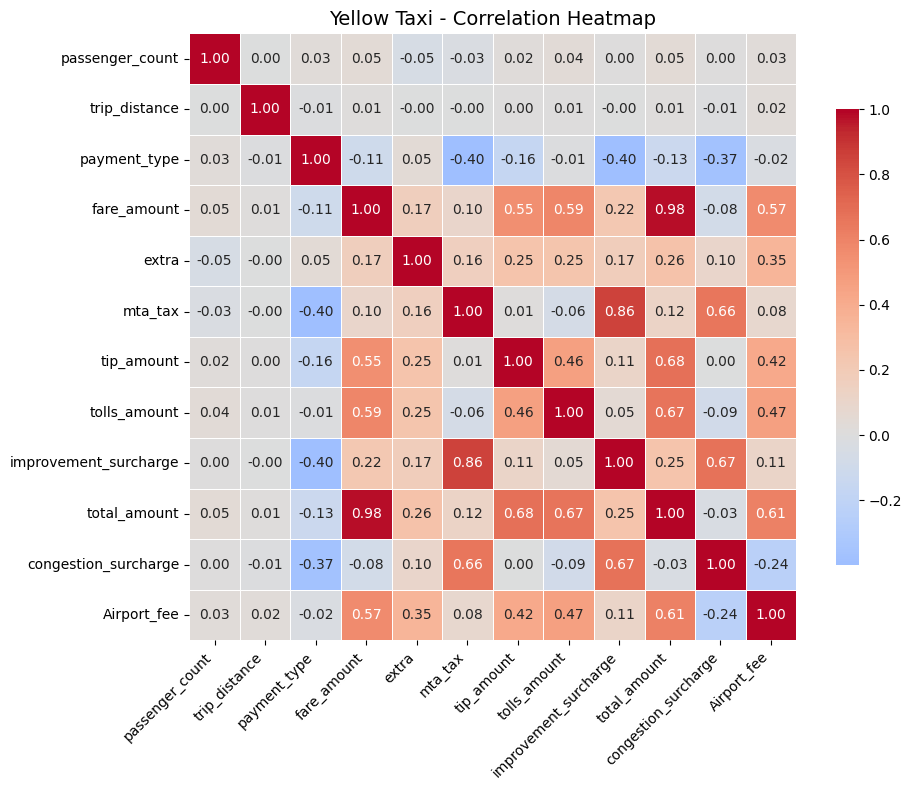


🔗 Correlation Heatmap for: Green Taxi (Pearson method)


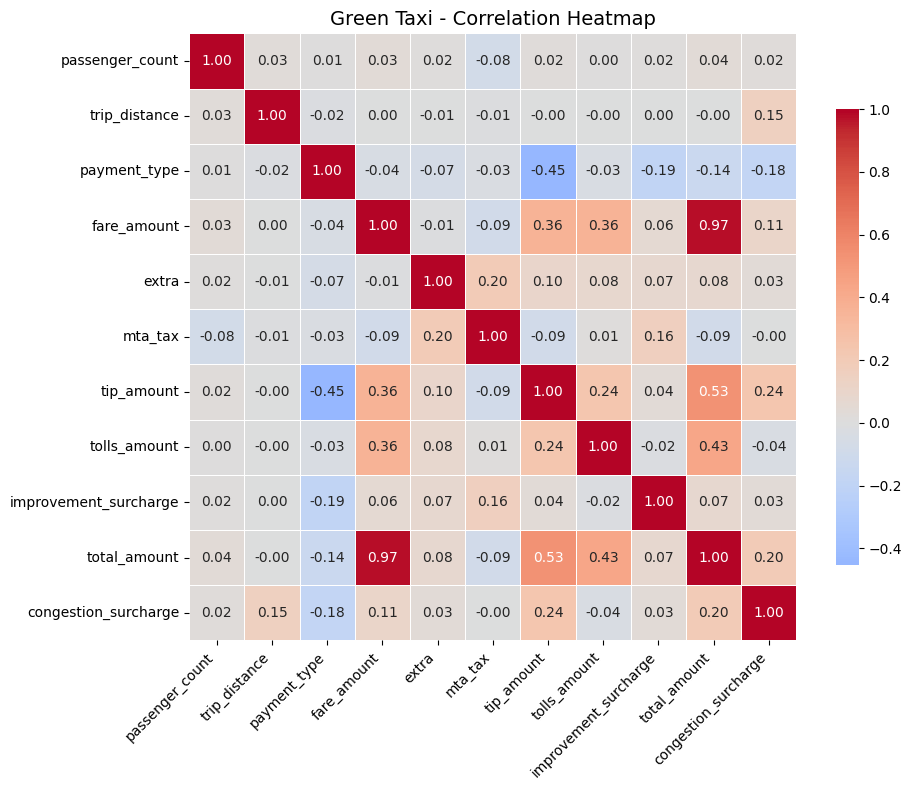

In [6]:
# List of relevant columns to plot correlation between
target_columns = [
    'passenger_count', 'trip_distance', 'payment_type', 'fare_amount',
    'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
    'total_amount', 'congestion_surcharge', 'Airport_fee'
]

def correlation_summary(df, df_name='DataFrame', figsize=(10, 8), method='pearson'):
    print(f"\n{'='*80}")
    print(f"🔗 Correlation Heatmap for: {df_name} ({method.title()} method)")

    # Select only the specified columns that exist in the DataFrame
    existing_cols = [col for col in target_columns if col in df.columns]
    if len(existing_cols) < 2:
        print("⚠️ Not enough relevant columns found to compute correlation.")
        return

    num_cols = df[existing_cols].select_dtypes(include='number')
    if num_cols.shape[1] < 2:
        print("⚠️ Not enough numeric columns among the selected features.")
        return

    # Compute correlation matrix
    corr_matrix = num_cols.corr(method=method)

    # Plot heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75}
    )
    plt.title(f"{df_name} - Correlation Heatmap", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Example usage
correlation_summary(yellow, 'Yellow Taxi')
correlation_summary(green, 'Green Taxi')


📈 Plotting Fare vs Distance for: Yellow Taxi (Log Scale)


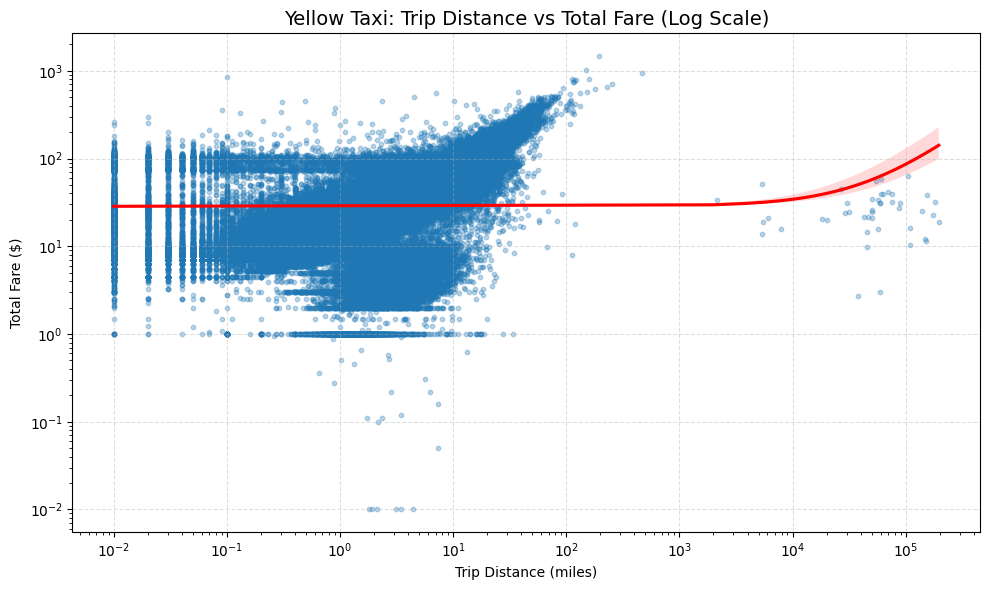


📈 Plotting Fare vs Distance for: Green Taxi (Log Scale)


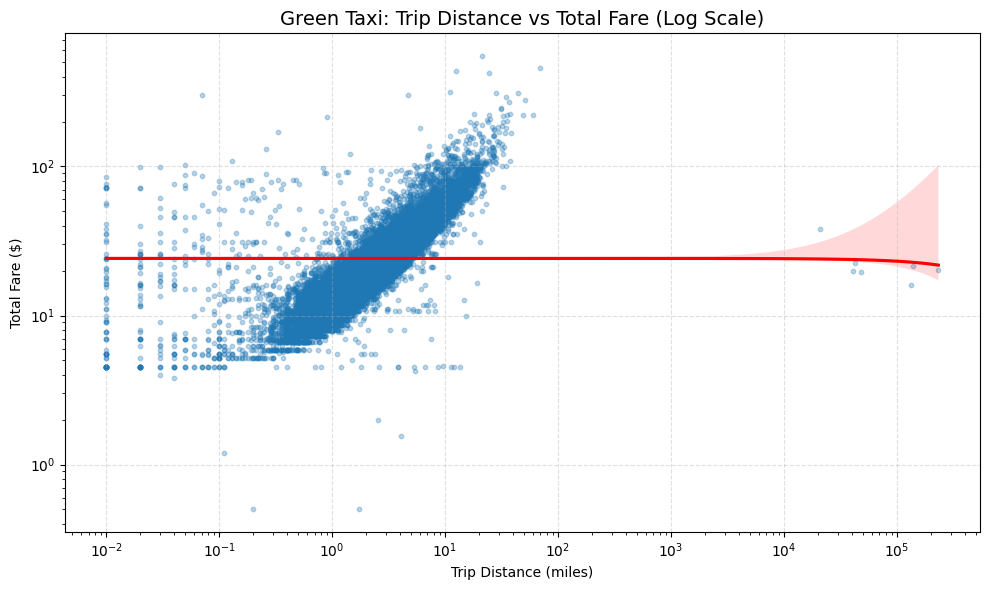

In [7]:
# fare vs distance correlation with logged scale

def plot_fare_vs_distance_logged(
    df, 
    df_name='Taxi Data', 
    add_regression=True, 
    alpha=0.3, 
    log_scale=False,
    clip_min=0.01
):
    """
    Plots scatterplot of trip_distance vs total_amount for a given taxi DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'trip_distance' and 'total_amount'.
        df_name (str): Name to display on plot.
        add_regression (bool): Whether to include regression line.
        alpha (float): Transparency of points.
        log_scale (bool): Whether to apply log scale to both axes.
        clip_min (float): Minimum value to clip for log scale (avoid log(0)).
    """
    if 'trip_distance' not in df.columns or 'total_amount' not in df.columns:
        print(f"⚠️ '{df_name}' is missing required columns.")
        return

    print(f"\n{'='*80}")
    print(f"📈 Plotting Fare vs Distance for: {df_name} {'(Log Scale)' if log_scale else ''}")

    # Filter or clip data to avoid log(0)
    plot_df = df.copy()
    if log_scale:
        plot_df = plot_df[(plot_df['trip_distance'] > 0) & (plot_df['total_amount'] > 0)]
        plot_df['trip_distance'] = plot_df['trip_distance'].clip(lower=clip_min)
        plot_df['total_amount'] = plot_df['total_amount'].clip(lower=clip_min)

    plt.figure(figsize=(10, 6))

    if add_regression:
        sns.regplot(
            data=plot_df,
            x='trip_distance',
            y='total_amount',
            scatter_kws={'alpha': alpha, 's': 10},
            line_kws={'color': 'red'}
        )
    else:
        sns.scatterplot(
            data=plot_df,
            x='trip_distance',
            y='total_amount',
            alpha=alpha,
            s=10
        )

    plt.title(f"{df_name}: Trip Distance vs Total Fare{' (Log Scale)' if log_scale else ''}", fontsize=14)
    plt.xlabel("Trip Distance (miles)")
    plt.ylabel("Total Fare ($)")

    if log_scale:
        plt.xscale('log')
        plt.yscale('log')

    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


# Linear scale (default)
plot_fare_vs_distance_logged(yellow, df_name='Yellow Taxi', log_scale=True)

# Log scale for better visibility of dense areas
plot_fare_vs_distance_logged(green, df_name='Green Taxi', log_scale=True)


## **Checking for duplicate rows**

In [8]:
# checking for duplicate rows
def check_duplicates(df, df_name='DataFrame'):

    """Check for duplicate rows in a DataFrame and export them if found."""


    print(f"\n{'='*80}")
    print(f"🔍 Checking for duplicates in: {df_name}")
    duplicate_rows = df.duplicated().sum()
    
    if duplicate_rows > 0:
        print(f"⚠️ Found {duplicate_rows} duplicate rows.")
    else:
        print("✅ No duplicate rows found.")
    
    # Define the output directory and ensure it exists
    import os
    output_dir = "cleaned_data"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")

    if duplicate_rows > 0:
        duplicates = df[df.duplicated(keep=False)]  # Get all duplicates (keeping all copies)
        output_path = os.path.join(output_dir, f"{df_name}_duplicates.csv")
        duplicates.to_csv(output_path, index=False)
        print(f"Duplicate rows exported to {output_path}")
        
        # Drop duplicates (keeping the first occurrence)
        df = df.drop_duplicates().reset_index(drop=True)
        print(f"🔄 Dropped {duplicate_rows} duplicate rows from {df_name}.")
    else:
        print("No duplicate rows to export.")
    
    return df  # Return the DataFrame with duplicates removed

# Check for duplicates in each DataFrame
yellow = check_duplicates(yellow, 'Yellow Taxi')
green = check_duplicates(green, 'Green Taxi')





🔍 Checking for duplicates in: Yellow Taxi
✅ No duplicate rows found.
No duplicate rows to export.

🔍 Checking for duplicates in: Green Taxi
✅ No duplicate rows found.
No duplicate rows to export.


## **Checking Missing values**


🕳️ Missing Value Summary for: yellow
                      Missing Count  Missing %
passenger_count              200800       9.75
RatecodeID                   200800       9.75
store_and_fwd_flag           200800       9.75
congestion_surcharge         200800       9.75
Airport_fee                  200800       9.75
DO_ServiceZone                18639       0.91
DO_Zone                        9474       0.46
DO_Borough                     9165       0.45
PU_ServiceZone                 7311       0.36
PU_Zone                        6089       0.30
PU_Borough                     1222       0.06


<Figure size 1000x400 with 0 Axes>

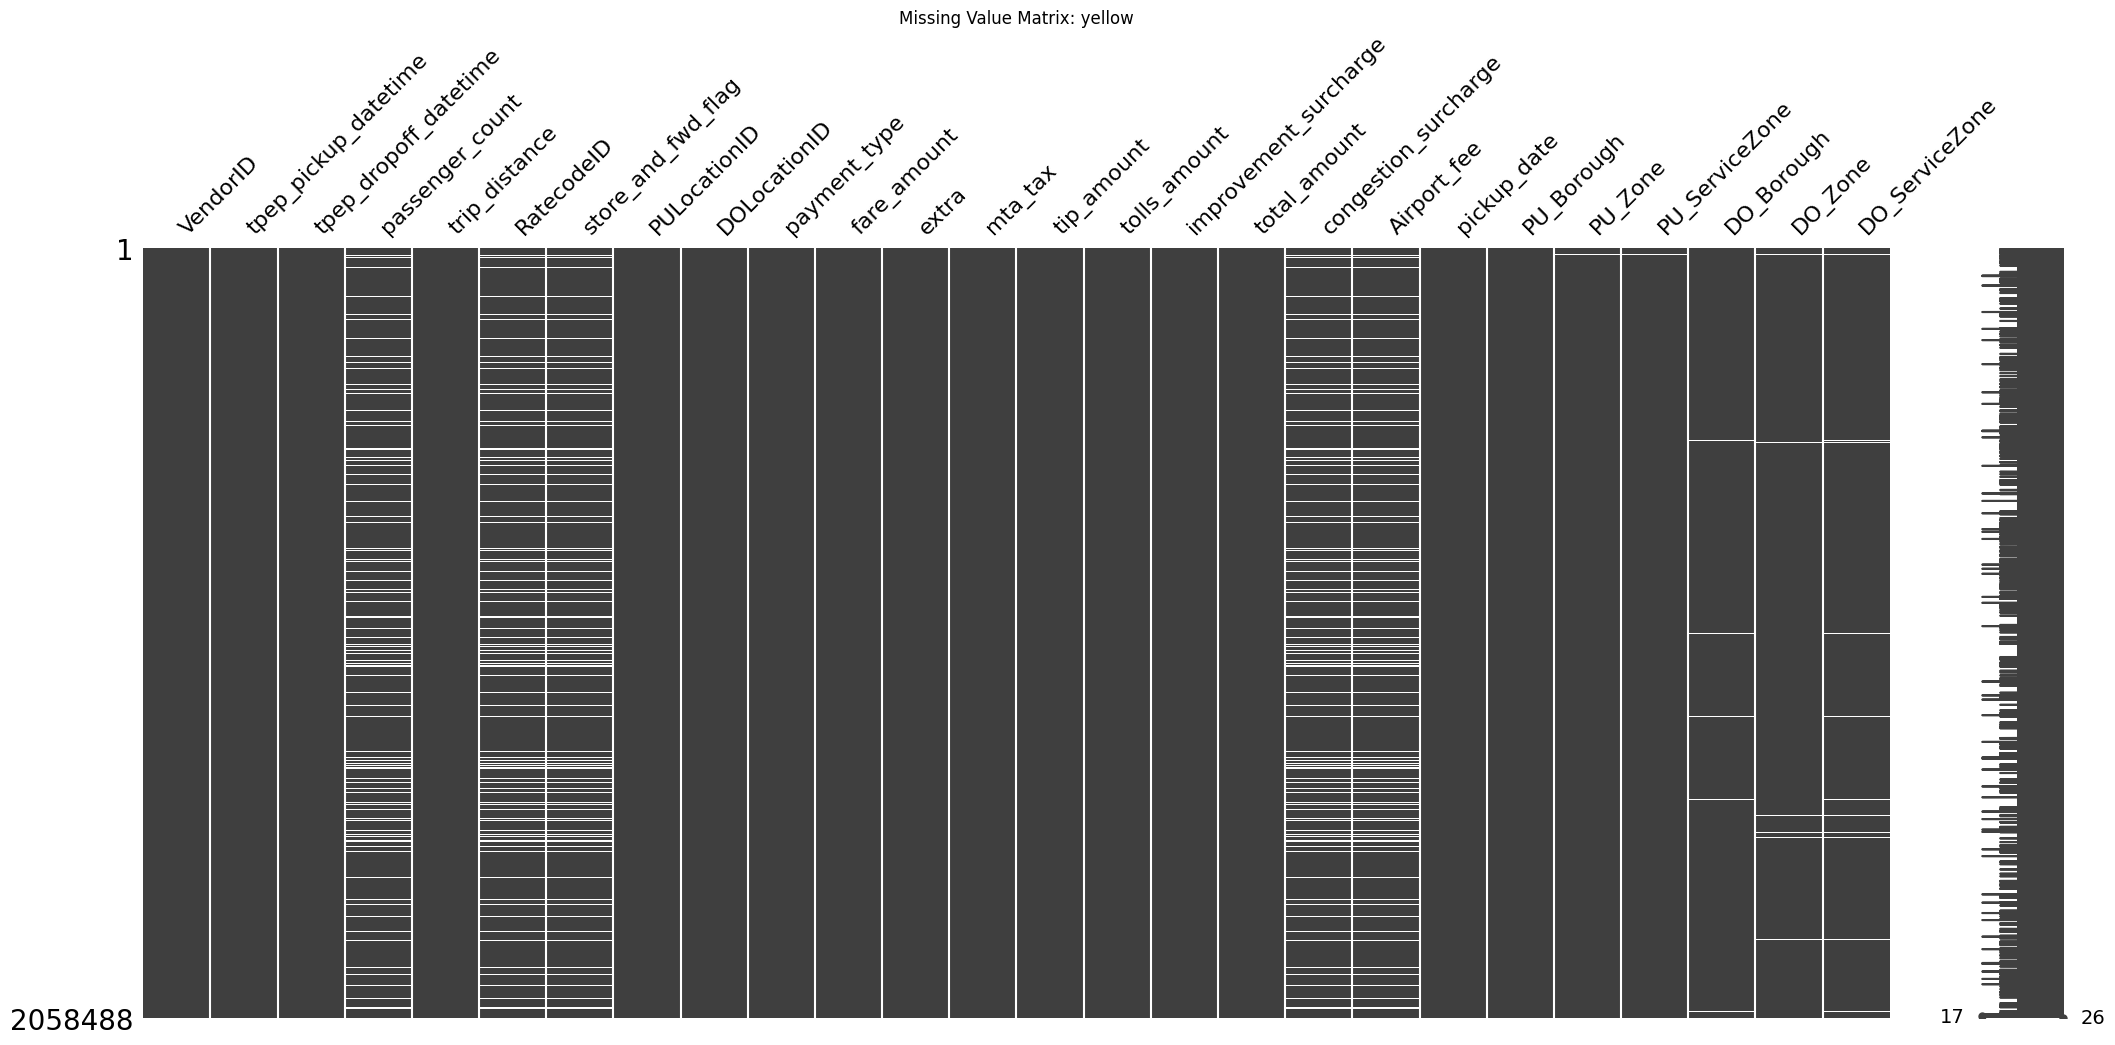

<Figure size 600x400 with 0 Axes>

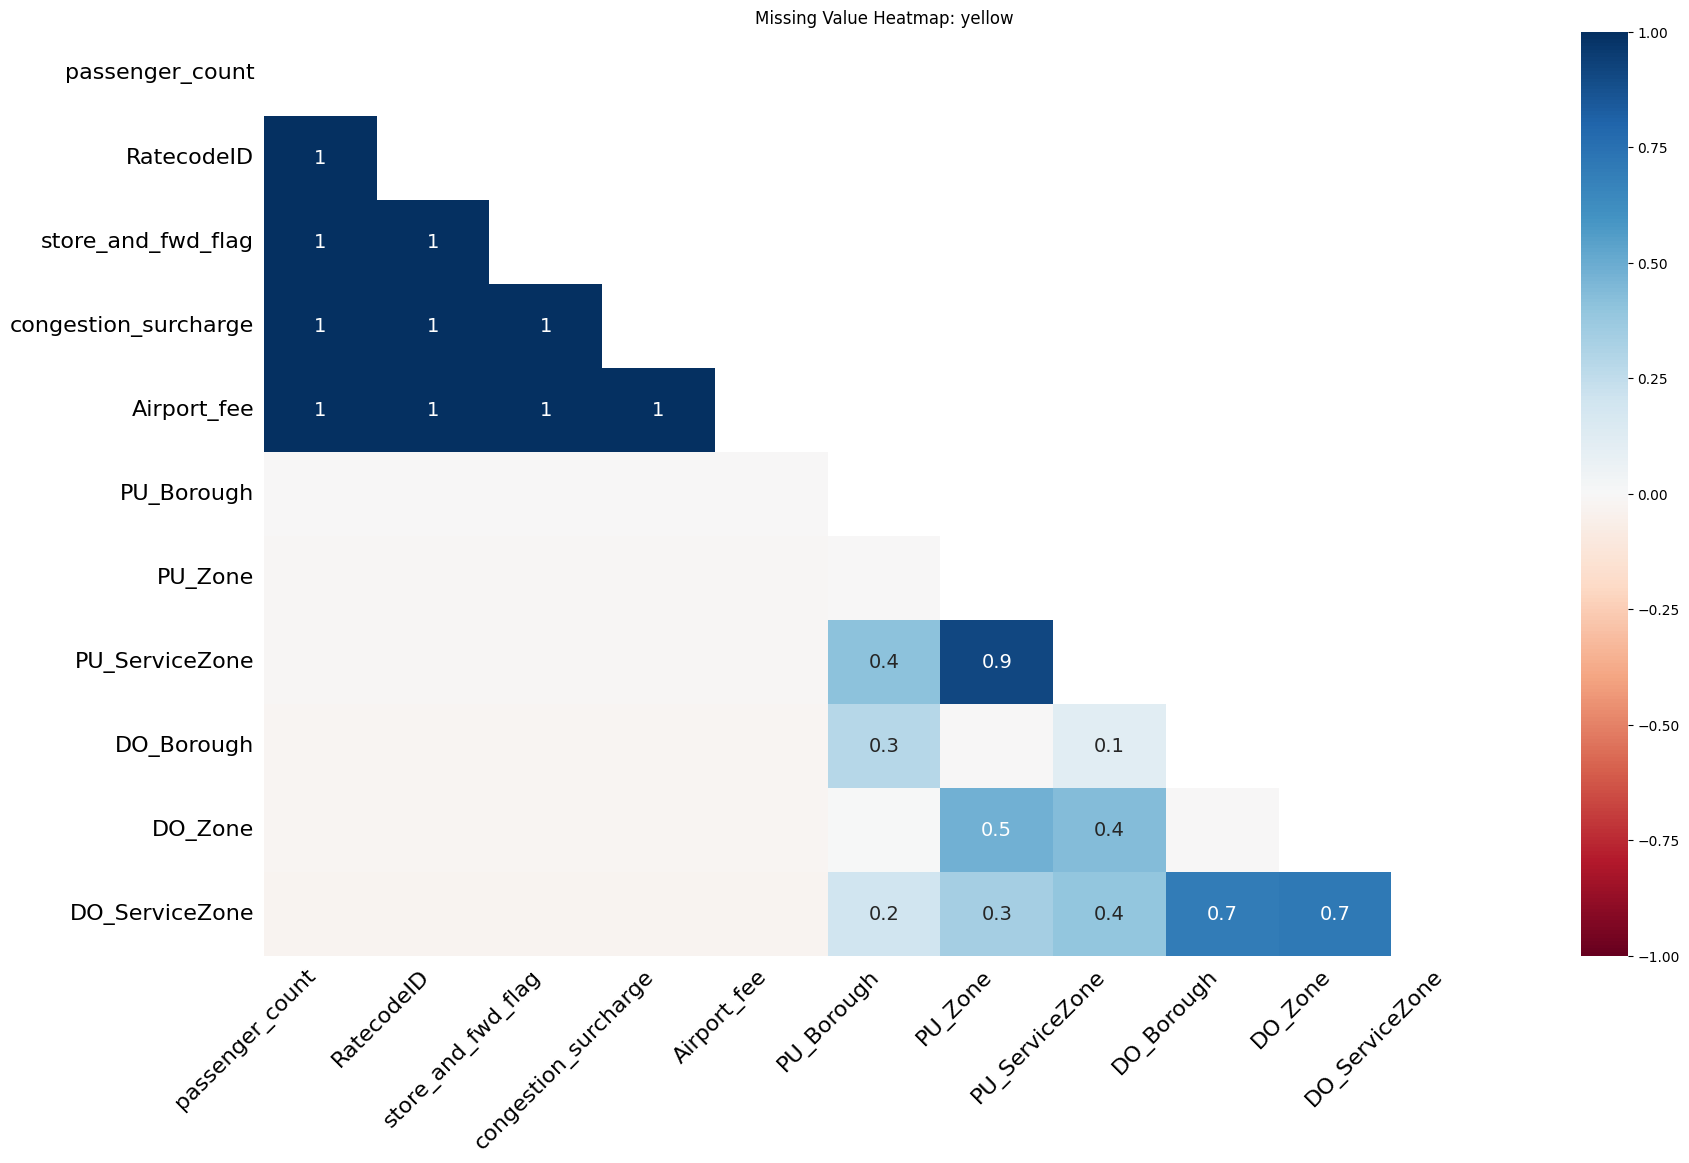


🕳️ Missing Value Summary for: green
                      Missing Count  Missing %
ehail_fee                     33012     100.00
trip_type                      1207       3.66
store_and_fwd_flag             1206       3.65
passenger_count                1206       3.65
RatecodeID                     1206       3.65
payment_type                   1206       3.65
congestion_surcharge           1206       3.65
DO_ServiceZone                  424       1.28
DO_Zone                         283       0.86
DO_Borough                      141       0.43
PU_ServiceZone                   93       0.28
PU_Zone                          69       0.21
PU_Borough                       24       0.07


<Figure size 1000x400 with 0 Axes>

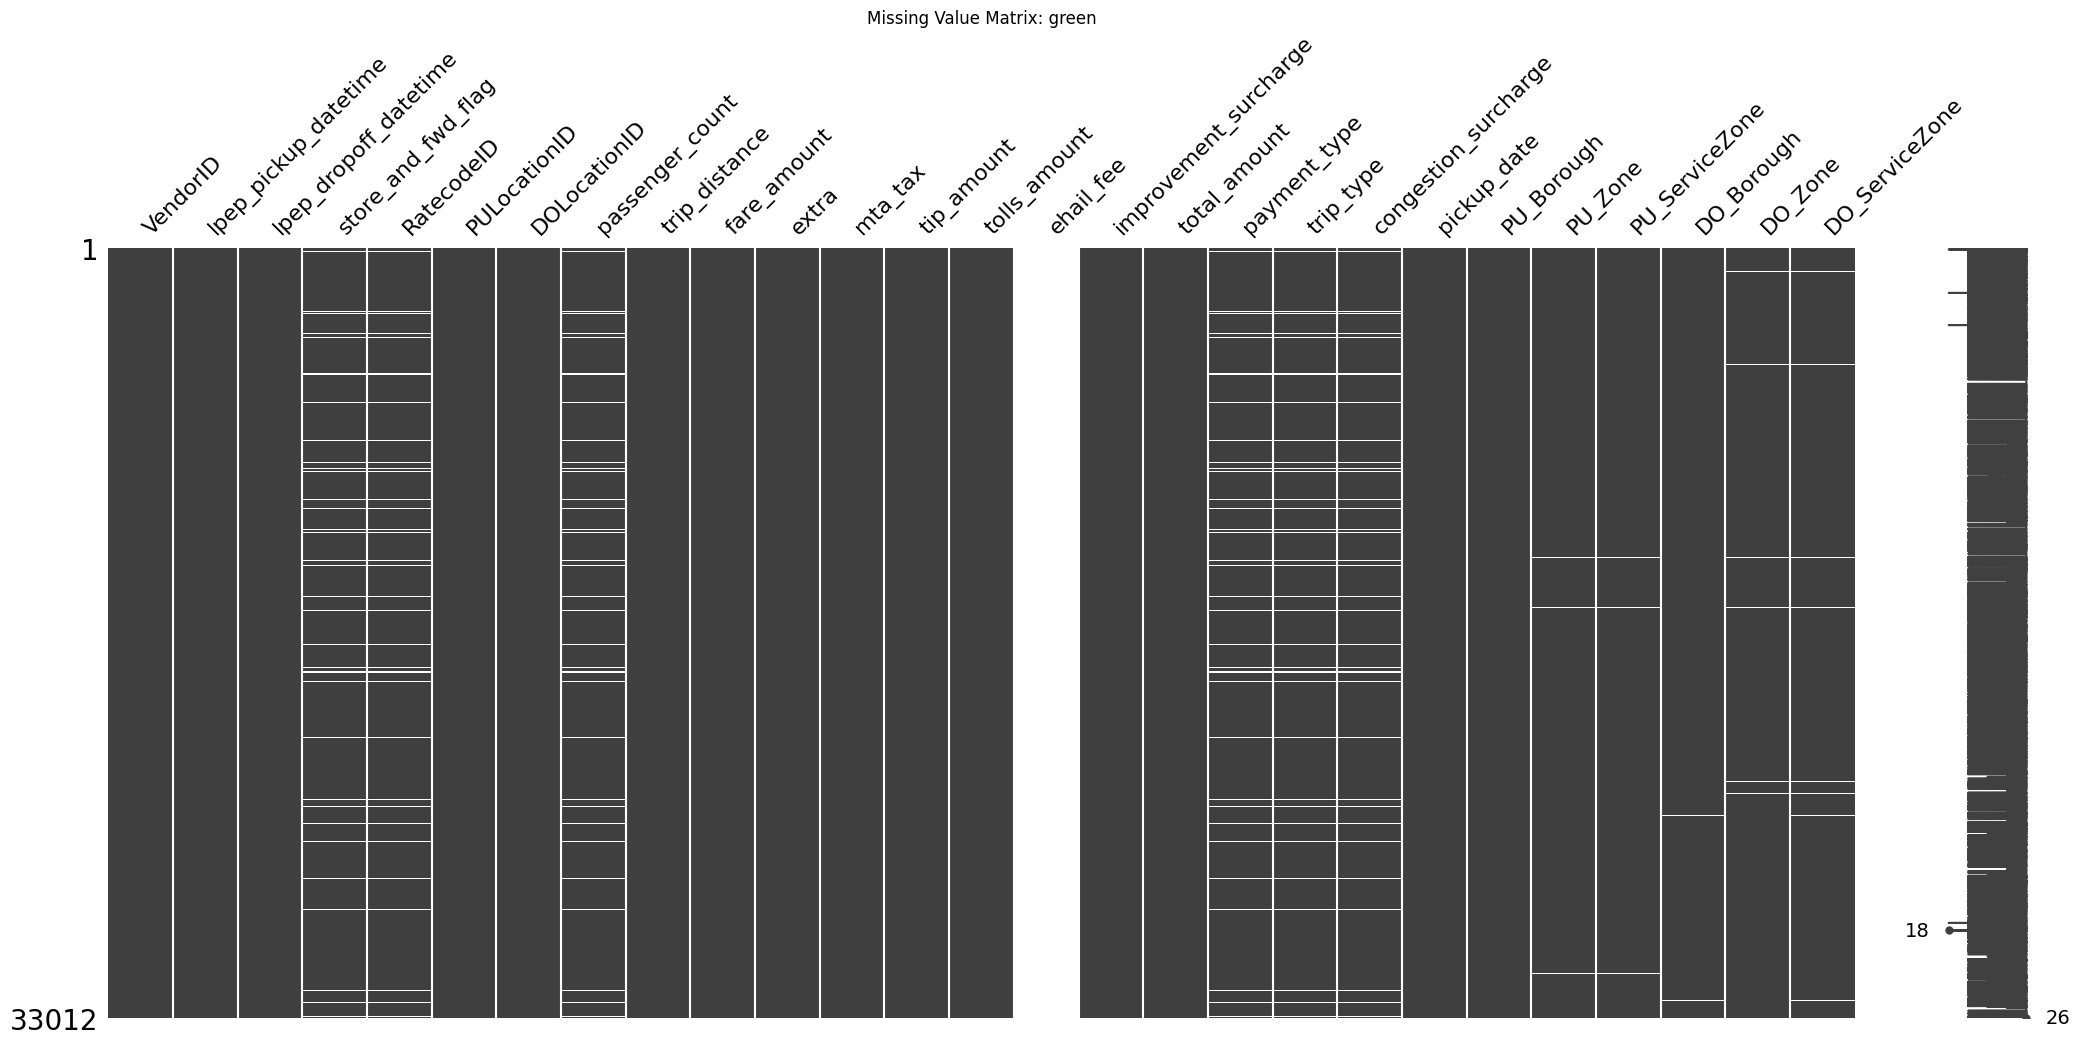

<Figure size 600x400 with 0 Axes>

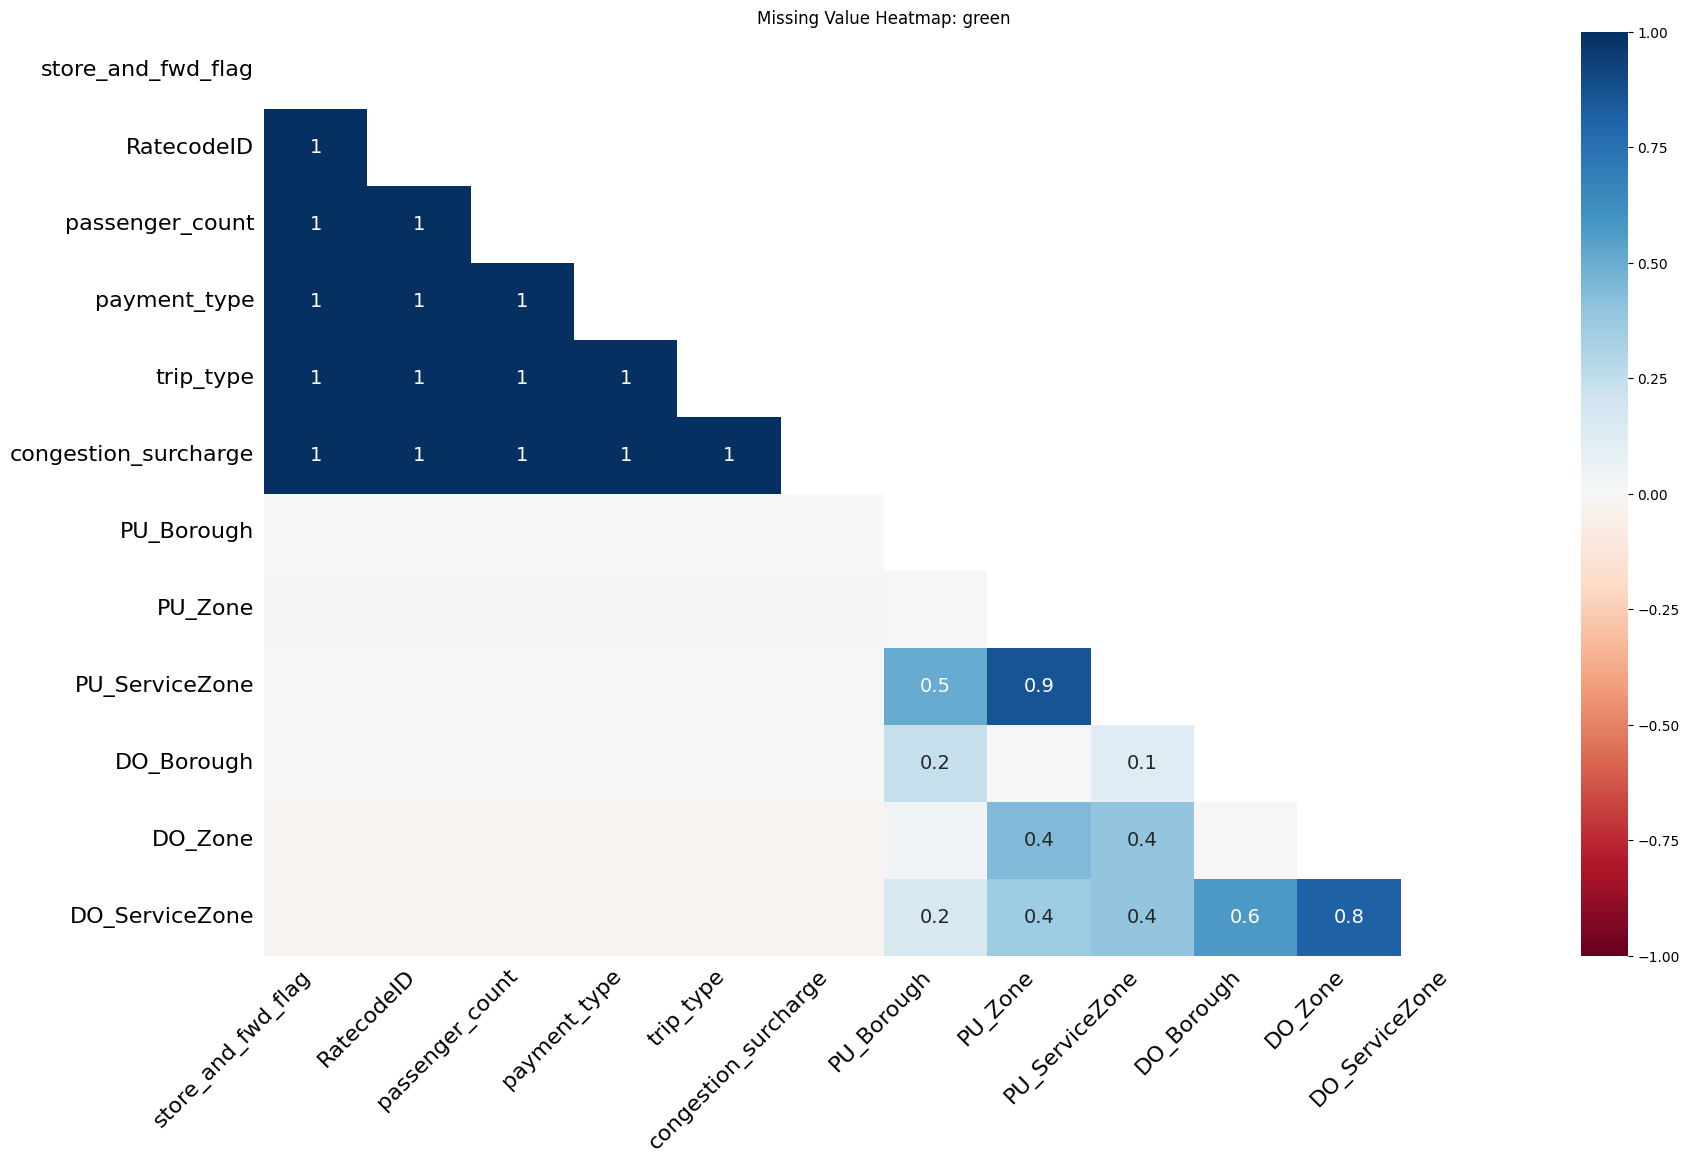

In [9]:
def missing_summary(df, df_name='DataFrame', plot=False):
    print(f"\n{'='*80}")
    print(f"🕳️ Missing Value Summary for: {df_name}")
    
    # Get missing values count and percentage
    missing = df.isna().sum()
    missing = missing[missing > 0]
    
    if missing.empty:
        print("✅ No missing values.")
        return
    
    missing_percent = (missing / len(df)) * 100
    summary = pd.DataFrame({
        'Missing Count': missing,
        'Missing %': missing_percent.round(2)
    }).sort_values(by='Missing %', ascending=False)

    print(summary.to_string())  # Changed from display() to print()

    # Show visualizations if enabled
    if plot:  # Changed from show_plots to plot
        plt.figure(figsize=(10, 4))
        msno.matrix(df)
        plt.title(f'Missing Value Matrix: {df_name}')
        plt.show()

        plt.figure(figsize=(6, 4))
        msno.heatmap(df)
        plt.title(f'Missing Value Heatmap: {df_name}')
        plt.show()

# DataFrames to check for missing values
missing_summary(yellow, 'yellow', plot=True)
missing_summary(green, 'green', plot=True)




#


# **Data Cleaning** 


## **Data Quality alert:**
**(Undefined NYC Locations):**

- Issue Identified: found **pickup (PU) and dropoff (DO)** borough records marked as 'Unknown', 'N/A', or null (NaN). By cross-referencing NYC taxi zone metadata, we confirmed that specific Location IDs (e.g., 264, 265) are systematically associated with these undefined borough classifications.

- Impact: Records with unmappable boroughs lack geographical context, compromising the validity of NYC-specific transportation analytics, including demand patterns, zone performance, and route efficiency.

| LocationID | Borough  | Zone            | service_zone |
|------------|----------|-----------------|--------------|
| 264        | Unknown  | N/A             | N/A          |
| 265        | N/A      | Outside of NYC  | N/A          |

In [10]:
# convert pu & do location IDs to string as they are categorical
def convert_location_ids_to_string(df, pickup_col, dropoff_col):
    """
    Convert pickup and dropoff location IDs to string type for consistency.
    
    Parameters:
    - df: pandas DataFrame
    - pickup_col: name of the pickup location ID column
    - dropoff_col: name of the dropoff location ID column
    
    Returns:
    - DataFrame with specified columns converted to string type
    """
    # Convert pickup location ID to string type
    if pickup_col not in df.columns or dropoff_col not in df.columns:
        raise ValueError(f"Columns '{pickup_col}' or '{dropoff_col}' not found in DataFrame.")
    df[pickup_col] = df[pickup_col].astype('Int64').astype('string')

    # Convert dropoff location ID to string type
    if dropoff_col not in df.columns:
        raise ValueError(f"Column '{dropoff_col}' not found in DataFrame.")
    df[dropoff_col] = df[dropoff_col].astype('Int64').astype('string')
    return df

# Convert location IDs to string for each DataFrame
yellow = convert_location_ids_to_string(yellow, 'PULocationID', 'DOLocationID')
green = convert_location_ids_to_string(green, 'PULocationID', 'DOLocationID')

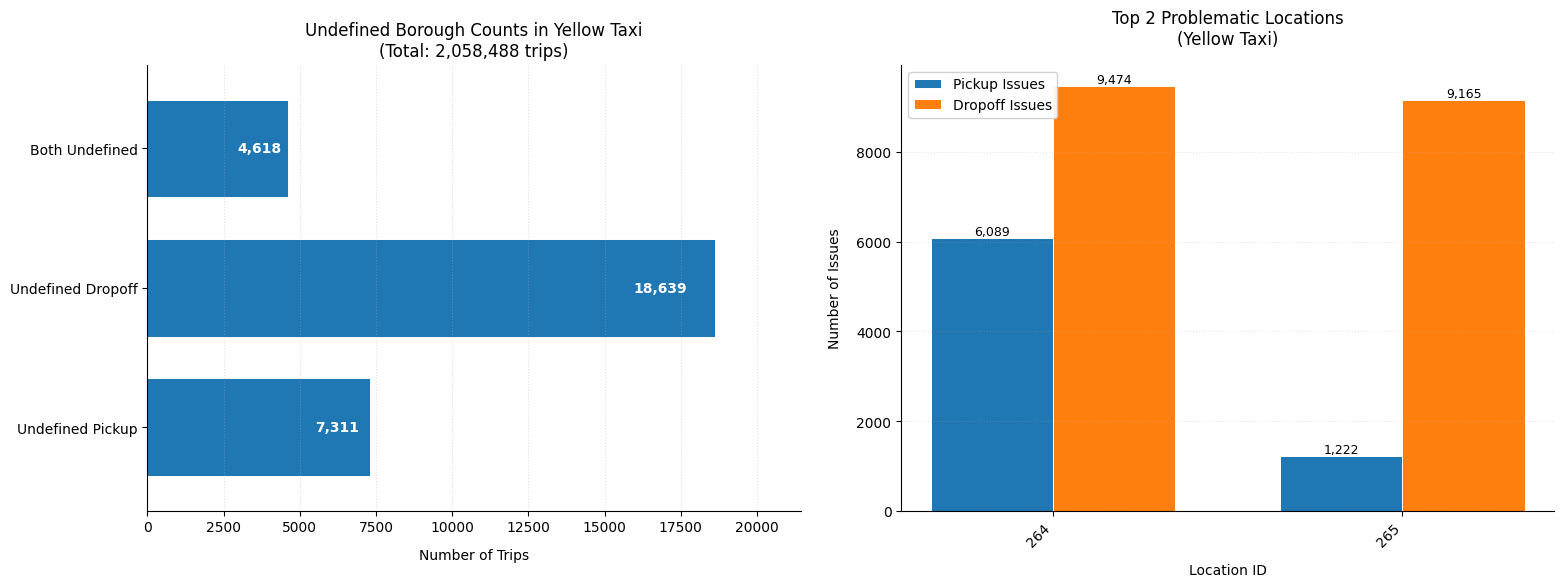


📊 Undefined Borough Analysis: Yellow Taxi
Total records: 2,058,488
Records with ANY undefined borough: 21,332 (1.0%)
Records with undefined PU borough: 7,311 (0.4%)
Records with undefined DO borough: 18,639 (0.9%)
Records with BOTH undefined: 4,618 (0.2%)

🔍 All problematic LocationIDs:
  LocationID  undefined_pickup  undefined_dropoff
0        264              6089               9474
1        265              1222               9165


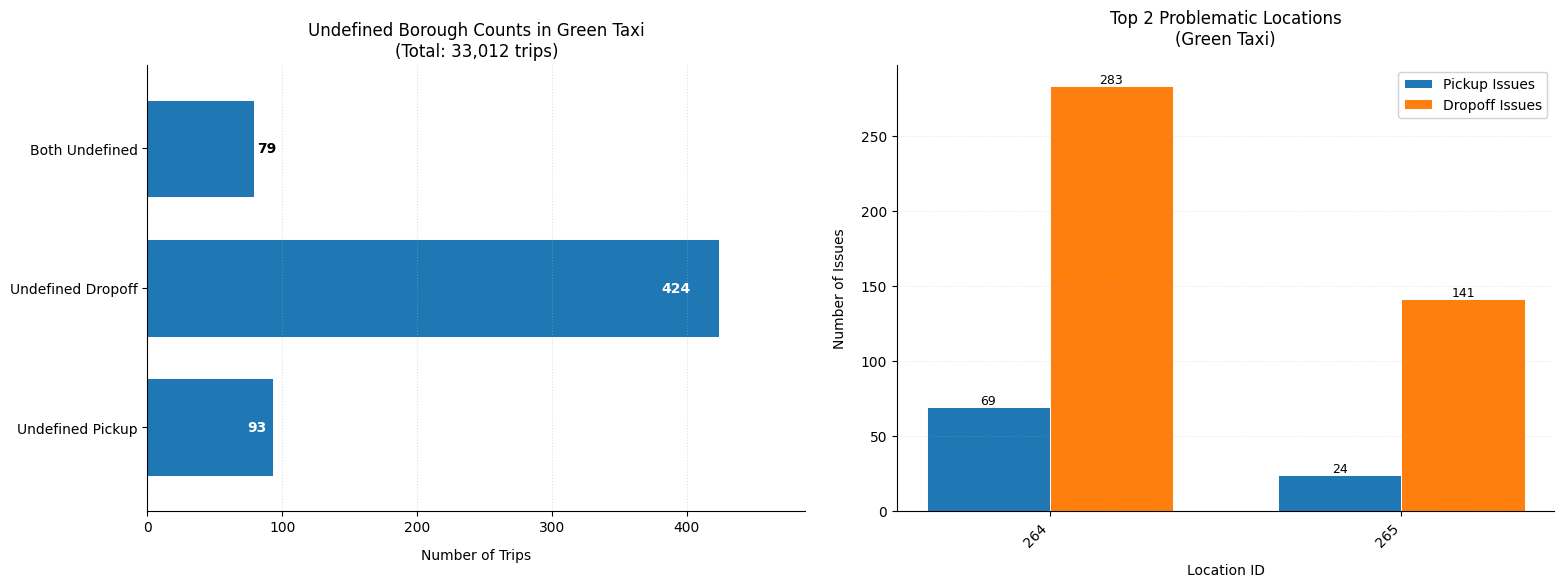


📊 Undefined Borough Analysis: Green Taxi
Total records: 33,012
Records with ANY undefined borough: 438 (1.3%)
Records with undefined PU borough: 93 (0.3%)
Records with undefined DO borough: 424 (1.3%)
Records with BOTH undefined: 79 (0.2%)

🔍 All problematic LocationIDs:
  LocationID  undefined_pickup  undefined_dropoff
0        264                69                283
1        265                24                141


In [11]:
# analyze undefined boroughs - to see the output and distriubtion undefined boroughs
def analyze_undefined_boroughs(df, df_name='DataFrame',
                             pu_borough_col='PU_Borough',
                             do_borough_col='DO_Borough',
                             pu_locid_col='PULocationID',
                             do_locid_col='DOLocationID',
                             undefined_values=['Unknown', 'N/A']):
    """
    Analyze and visualize records with undefined boroughs (pickup, dropoff, or both).
    Returns: stats dict, undefined records DataFrame, and location counts DataFrame.
    """

    # 1. Identify undefined boroughs
    pu_undefined = (df[pu_borough_col].isin(undefined_values)) | (df[pu_borough_col].isna())
    do_undefined = (df[do_borough_col].isin(undefined_values)) | (df[do_borough_col].isna())

    # 2. Masks for undefined rows
    any_undefined_mask = pu_undefined | do_undefined
    both_undefined_mask = pu_undefined & do_undefined

    # 3. Extract undefined records (PU or DO or both)
    undefined_records = df[any_undefined_mask].copy()

    # 4. Extract LocationIDs where borough is undefined (
    pu_problem_locs_raw = df.loc[pu_undefined, pu_locid_col]
    do_problem_locs_raw = df.loc[do_undefined, do_locid_col]

    # 5. Count LocationIDs (all of them, not limited to top)
    pu_counts = pu_problem_locs_raw.value_counts(dropna = False).sort_index()
    do_counts = do_problem_locs_raw.value_counts(dropna = False).sort_index()

    # Label missing ones
    pu_counts.index = pu_counts.index.fillna('Missing')
    do_counts.index = do_counts.index.fillna('Missing')

    # Convert to string
    pu_counts.index = pu_counts.index.astype(str)
    do_counts.index = do_counts.index.astype(str)

    # 6. Stats summary
    stats = {
    'total_records': len(df),
    'undefined_pu': pu_undefined.sum(),
    'undefined_do': do_undefined.sum(),
    'any_undefined': any_undefined_mask.sum(),
    'both_undefined': both_undefined_mask.sum(),
    'undefined_pu_pct': f"{pu_undefined.mean():.1%}",
    'undefined_do_pct': f"{do_undefined.mean():.1%}",
    'any_undefined_pct': f"{any_undefined_mask.mean():.1%}",
    'both_undefined_pct': f"{both_undefined_mask.mean():.1%}",
    }


    # 7. Visuals

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # === 7a. Improved Horizontal Bar Chart ===
    # Create DataFrame with proper structure
    borough_counts = pd.DataFrame({
        'Count': [stats['undefined_pu'], stats['undefined_do'], stats['both_undefined']]
    }, index=['Undefined Pickup', 'Undefined Dropoff', 'Both Undefined'])

    # Calculate maximum value for dynamic scaling
    max_count = borough_counts['Count'].max()

    # Plot with improved styling
    ax = borough_counts.plot(kind='barh', ax=ax1, 
                            title=f'Undefined Borough Counts in {df_name}\n(Total: {len(df):,} trips)',
                            legend=False,
                            color=['#1f77b4', '#ff7f0e', '#2ca02c'],
                            width=0.7,  # Better bar thickness
                            edgecolor='white',  # Clean bar edges
                            linewidth=0.7)

    # Set dynamic x-limit with padding
    ax.set_xlim([0, max_count * 1.15])  # 15% padding
    ax.set_xlabel('Number of Trips', labelpad=10)
    ax.grid(axis='x', linestyle=':', alpha=0.4)

    # Add intelligent value labels
    for i, v in enumerate(borough_counts['Count']):
        # Position inside bar if >20% of max, otherwise outside
        if v > max_count * 0.2:
            ax.text(v * 0.95, i, f"{v:,}", 
                    color='white', va='center', ha='right',
                    fontweight='bold')
        else:
            ax.text(v * 1.03, i, f"{v:,}", 
                    color='black', va='center',
                    fontweight='bold')

    # Remove spines for cleaner look
    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)

    # === 7b. Enhanced Clustered Bar Chart ===
    # Prepare location data
    location_df = pd.DataFrame({
        'PU Issues': pu_counts,
        'DO Issues': do_counts
    }).fillna(0).head(10)  # Limit to top 10 for readability

    location_df.index = location_df.index.astype(str)
    x = np.arange(len(location_df))
    bar_width = 0.35  # Slightly narrower bars

    # Plot with improved styling
    bars1 = ax2.bar(x - bar_width/2, location_df['PU Issues'], 
                width=bar_width, color='#1f77b4', label='Pickup Issues',
                edgecolor='white', linewidth=0.7)
    bars2 = ax2.bar(x + bar_width/2, location_df['DO Issues'], 
                width=bar_width, color='#ff7f0e', label='Dropoff Issues',
                edgecolor='white', linewidth=0.7)

    # Configure axes and labels
    ax2.set_xticks(x)
    ax2.set_xticklabels(location_df.index, rotation=45, ha='right')
    ax2.set_xlabel('Location ID', labelpad=10)
    ax2.set_ylabel('Number of Issues', labelpad=10)
    ax2.set_title(f'Top {len(location_df)} Problematic Locations\n({df_name})', pad=15)

    # Add value labels above bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # Only label non-zero bars
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f"{height:,}", ha='center', va='bottom',
                        fontsize=9)

    add_labels(bars1)
    add_labels(bars2)

    # Add legend and grid
    ax2.legend(framealpha=0.9)
    ax2.grid(axis='y', linestyle=':', alpha=0.3)

    # Remove top and right spines
    for spine in ['right', 'top']:
        ax2.spines[spine].set_visible(False)

    # Final layout adjustment
    plt.tight_layout(pad=2)  # Slightly more padding than default
    plt.subplots_adjust(top=0.9)  # Adjust top spacing for titles
    plt.show()

    # 8. Print summary
    print(f"\n{'='*80}")
    print(f"📊 Undefined Borough Analysis: {df_name}")
    print(f"Total records: {stats['total_records']:,}")
    print(f"Records with ANY undefined borough: {stats['any_undefined']:,} ({stats['any_undefined_pct']})")
    print(f"Records with undefined PU borough: {stats['undefined_pu']:,} ({stats['undefined_pu_pct']})")
    print(f"Records with undefined DO borough: {stats['undefined_do']:,} ({stats['undefined_do_pct']})")
    print(f"Records with BOTH undefined: {stats['both_undefined']:,} ({stats['both_undefined_pct']})")

    print("\n🔍 All problematic LocationIDs:")
    undefined_count = pd.DataFrame({
        'undefined_pickup': pu_counts.sort_values(ascending=False),
        'undefined_dropoff': do_counts.sort_values(ascending=False)
    }).reset_index().rename(columns={'index': 'LocationID'})


    print(f"{undefined_count}")
    print("="*80)

    return stats, undefined_records, location_df

stats, undefined_rows, location_table = analyze_undefined_boroughs(yellow, "Yellow Taxi")
stats, undefined_rows, location_table = analyze_undefined_boroughs(green, "Green Taxi")


## **Handling Undefined and Special LocationIDs (264 & 265)**

In the NYC Taxi & FHV datasets, some trips include LocationIDs that are either undefined (264) or refer to areas outside the official TLC zone system (265). Rather than dropping these records, I chose to retain them in the dataset and explicitly relabel their associated Borough, Zone, and Service Zone fields with descriptive placeholders such as 'Undefined' or 'Outside NYC'.

This approach ensures:

Data integrity is preserved — no trips are lost, which supports accurate trip-level statistics (e.g., total rides, distributions).

Clarity in aggregation — these relabeled trips do not mix with valid NYC boroughs during groupby summaries or visualizations.

Better transparency — this handling makes it easy to quantify and isolate special cases in follow-up analyses.



In [12]:
def relabel_special_locations(df, 
                            undefined_locations= ['264', '265'],
                            output_dir=None,
                            df_name='DataFrame'):
    """
    Updates PU/DO Borough, Zone, and ServiceZone fields for special LocationIDs.
    
    Parameters:
        df (pd.DataFrame): Input trip data with PU and DO location metadata
        undefined_locations (list): LocationIDs to treat as special cases
        output_dir (str): Optional directory for saving summary stats
        df_name (str): Name for reporting
        
    Returns:
        pd.DataFrame: Modified DataFrame with consistent location labels
        pd.DataFrame: Summary of changes made
    """
    
    # Create mapping dictionary for consistent labeling
    LABEL_MAP = {
        '264': {
            'borough': 'Undefined',
            'zone': 'Undefined',
            'service_zone': 'Undefined'
        },
        '265': {
            'borough': 'Outside NYC',
            'zone': 'Outside NYC',
            'service_zone': 'Outside NYC'
        }
    }
    
    # Track changes
    change_log = []
    
    # Process pickup locations
    for loc in undefined_locations:
        mask = df['PULocationID'] == loc
        if mask.any():
            df.loc[mask, 'PU_Borough'] = LABEL_MAP[loc]['borough']
            df.loc[mask, 'PU_Zone'] = LABEL_MAP[loc]['zone']
            df.loc[mask, 'PU_ServiceZone'] = LABEL_MAP[loc]['service_zone']
            change_log.append(('Pickup', loc, mask.sum()))
    
    # Process dropoff locations
    for loc in undefined_locations:
        mask = df['DOLocationID'] == loc
        if mask.any():
            df.loc[mask, 'DO_Borough'] = LABEL_MAP[loc]['borough']
            df.loc[mask, 'DO_Zone'] = LABEL_MAP[loc]['zone']
            df.loc[mask, 'DO_ServiceZone'] = LABEL_MAP[loc]['service_zone']
            change_log.append(('Dropoff', loc, mask.sum()))
    
    # Create summary DataFrame
    change_summary = pd.DataFrame(change_log, 
                                columns=['TripPoint', 'LocationID', 'RecordsUpdated'])
    
    # Print summary
    print(f"\n{'='*80}")
    print(f"📍 Special Location Relabeling Summary: {df_name}")
    print(f"{'='*80}")
    if not change_summary.empty:
        print(change_summary.to_markdown(tablefmt="grid", index=False))
        print(f"\nTotal records updated: {change_summary['RecordsUpdated'].sum():,}")
    else:
        print("No special locations found to relabel")
    print("="*80)
    
    # Optionally save summary
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        summary_path = os.path.join(output_dir, f"special_locations_summary_{df_name}.csv")
        change_summary.to_csv(summary_path, index=False)
        print(f"Saved summary to: {summary_path}")
    
    return df, change_summary
# usage

# With output directory
yellow, changes = relabel_special_locations(yellow,output_dir="cleaned_data",df_name="Yellow taxi")
green, changes = relabel_special_locations(green,output_dir="cleaned_data",df_name="Green taxi")


📍 Special Location Relabeling Summary: Yellow taxi
+-------------+--------------+------------------+
| TripPoint   |   LocationID |   RecordsUpdated |
+=============+==============+==================+
| Pickup      |          264 |             6089 |
+-------------+--------------+------------------+
| Pickup      |          265 |             1222 |
+-------------+--------------+------------------+
| Dropoff     |          264 |             9474 |
+-------------+--------------+------------------+
| Dropoff     |          265 |             9165 |
+-------------+--------------+------------------+

Total records updated: 25,950
Saved summary to: cleaned_data\special_locations_summary_Yellow taxi.csv

📍 Special Location Relabeling Summary: Green taxi
+-------------+--------------+------------------+
| TripPoint   |   LocationID |   RecordsUpdated |
+=============+==============+==================+
| Pickup      |          264 |               69 |
+-------------+--------------+-------------

# **Detect the type of missingness and Imputation techniques**

## **1- Missing values for yellow**

### **Dectecting missingness type**

In [13]:
missing_summary(yellow)


🕳️ Missing Value Summary for: DataFrame
                      Missing Count  Missing %
passenger_count              200800       9.75
RatecodeID                   200800       9.75
store_and_fwd_flag           200800       9.75
congestion_surcharge         200800       9.75
Airport_fee                  200800       9.75


In [14]:
# mask the data with missing values to detect any pattern(desscribe)

missing_rows = yellow[yellow.isna().any(axis=1)]
missing_rows.describe(include='all')

VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count   200800.000000                      200800                      200800   
unique            NaN                         NaN                         NaN   
top               NaN                         NaN                         NaN   
freq              NaN                         NaN                         NaN   
mean         1.789572  2024-07-14 03:38:21.576384  2024-07-14 03:55:44.086010   
min          1.000000         2024-01-01 00:17:11         2024-01-01 00:25:23   
25%          2.000000         2024-04-16 15:16:22  2024-04-16 15:38:39.250000   
50%          2.000000         2024-07-12 09:13:58  2024-07-12 09:26:03.500000   
75%          2.000000  2024-10-08 21:40:11.500000  2024-10-08 21:55:12.750000   
max          6.000000         2024-12-31 23:44:03         2024-12-31 23:59:03   
std          0.419654                         NaN                         NaN   

        passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
count               0.0  200800.000000         0.0                  0   
unique              NaN            NaN         NaN                  0   
top                 NaN            NaN         NaN                NaN   
freq                NaN            NaN         NaN                NaN   
mean                NaN      16.920955         NaN                NaN   
min                 NaN       0.000000         NaN                NaN   
25%                 NaN       1.300000         NaN                NaN   
50%                 NaN       2.290000         NaN                NaN   
75%                 NaN       3.950000         NaN                NaN   
max                 NaN  195916.810000         NaN                NaN   
std                 NaN    1190.253489         NaN                NaN   

       PULocationID DOLocationID  payment_type    fare_amount          extra  \
count        200800       200800      200800.0  200800.000000  200800.000000   
unique          251          249           NaN            NaN            NaN   
top              79           79           NaN            NaN            NaN   
freq           7225         6357           NaN            NaN            NaN   
mean            NaN          NaN           0.0      19.858448       0.064305   
min             NaN          NaN           0.0     -88.050000      -2.500000   
25%             NaN          NaN           0.0      12.140000       0.000000   
50%             NaN          NaN           0.0      17.700000       0.000000   
75%             NaN          NaN           0.0      25.560000       0.000000   
max             NaN          NaN           0.0     635.750000      10.000000   
std             NaN          NaN           0.0      12.613744       0.480805   

              mta_tax     tip_amount   tolls_amount  improvement_surcharge  \
count   200800.000000  200800.000000  200800.000000          200800.000000   
unique            NaN            NaN            NaN                    NaN   
top               NaN            NaN            NaN                    NaN   
freq              NaN            NaN            NaN                    NaN   
mean         0.498332       0.749549       0.237378               0.998250   
min         -0.500000       0.000000       0.000000              -1.000000   
25%          0.500000       0.000000       0.000000               1.000000   
50%          0.500000       0.000000       0.000000               1.000000   
75%          0.500000       0.000000       0.000000               1.000000   
max          1.000000      40.000000      51.760000               1.000000   
std          0.029390       2.229832       1.425524               0.040745   

         total_amount  congestion_surcharge  Airport_fee pickup_date  \
count   200800.000000                   0.0          0.0      200800   
unique            NaN                   NaN          NaN         NaN   
top               NaN                   NaN      

In [15]:
# Show value counts for VendorID in the missing group

print(missing_rows['payment_type'].value_counts())



payment_type
0    200800
Name: count, dtype: int64


**___________________________________________________________________________________________________________________________________________________________________**

The observed missingness pattern is best classified as **Missing At Random (MAR)**, as it is fully dependent on an observed variable—specifically, **payment_type = 0**, which corresponds to Flex Fare trips. All records with missing values belong to this category. This suggests that the missingness is not due to chance, but rather is driven by structural differences in how Flex Fare trips are recorded—possibly due to a distinct data pipeline, reduced metadata capture, or alternative dispatch systems used for these trip types.

**___________________________________________________________________________________________________________________________________________________________________**

### **Airport Fee Imputation**

This imputation follows strict business rules derived from NYC TLC regulations and taxi industry standards:

 **-Eligibility Criteria**  
   - Only trips originating at JFK (PULocationID=132) or LaGuardia (PULocationID=138) airports qualify for the $1.75 airport fee
   - Verified against both location IDs and zone names as redundant validation

In [16]:
def impute_airport_fee(df):
    """
    Simplified Airport_fee cleaner:
    - Sets $1.75 fee for JFK (132) and LGA (138) pickups
    - Sets $0.00 for all other locations
    - Handles negatives, missing values, and incorrect amounts
    - Provides clear before/after reporting
    """
    import os
    
    # Keep original for comparison
    original = df.copy()
    
    # Constants
    AIRPORT_IDS = {132, 138}  # JFK and LGA
    AIRPORT_ZONES = {'JFK Airport', 'LaGuardia Airport'}
    CORRECT_FEE = 1.75
    
    # Determine airport pickups
    is_airport = (
        df['PULocationID'].isin(AIRPORT_IDS) | 
        df['PU_Zone'].isin(AIRPORT_ZONES)
    )
    
    # --- Pre-Cleaning Report ---
    print("\n=== BEFORE CLEANING ===")
    print(f"Total rows: {len(df):,}")
    print(f"Missing fees: {df['Airport_fee'].isna().sum():,}")
    print(f"Negative fees: {(df['Airport_fee'] < 0).sum():,}")
    print(f"Zero fees: {(df['Airport_fee'] == 0).sum():,}")
    print(f"Correct fees ($1.75): {(df['Airport_fee'] == CORRECT_FEE).sum():,}")
    print(f"Other amounts: {((df['Airport_fee'] > 0) & (df['Airport_fee'] != CORRECT_FEE)).sum():,}")
    
    # --- Cleaning Process ---
    changes = 0
    
    # 1. Fix missing values
    missing = df['Airport_fee'].isna()
    df.loc[missing & is_airport, 'Airport_fee'] = CORRECT_FEE
    df.loc[missing & ~is_airport, 'Airport_fee'] = 0.0
    changes += missing.sum()
    
    # 2. Fix negative values
    negatives = (df['Airport_fee'] < 0)
    df.loc[negatives & is_airport, 'Airport_fee'] = CORRECT_FEE
    df.loc[negatives & ~is_airport, 'Airport_fee'] = 0.0
    changes += negatives.sum()
    
    # 3. Fix incorrect positive amounts
    incorrect = (df['Airport_fee'] > 0) & (df['Airport_fee'] != CORRECT_FEE)
    df.loc[incorrect & is_airport, 'Airport_fee'] = CORRECT_FEE
    df.loc[incorrect & ~is_airport, 'Airport_fee'] = 0.0
    changes += incorrect.sum()
    
    # --- Post-Cleaning Report ---
    print("\n=== AFTER CLEANING ===")
    print(f"Total changes made: {changes:,}")
    print(f"Now correct ($1.75 at airports): {(df['Airport_fee'] == CORRECT_FEE).sum():,}") 
    print(f"Now zero (non-airports): {(df['Airport_fee'] == 0).sum():,}")
    print(f"Remaining issues: {(df['Airport_fee'].isna().sum() + (df['Airport_fee'] < 0).sum()):,}")
    
    # Save changed records
    changed = df[df['Airport_fee'] != original['Airport_fee']]
    os.makedirs('cleaned_data', exist_ok=True)
    changed.to_csv('cleaned_data/yellow_airport_fee_corrections.csv', index=False)
    print(f"\nSaved {len(changed):,} corrected records to 'cleaned_data/yellow_airport_fee_corrections.csv'")
    
    return df

# Usage
yellow = impute_airport_fee(yellow)


=== BEFORE CLEANING ===
Total rows: 2,058,488
Missing fees: 200,800
Negative fees: 4,852
Zero fees: 1,691,712
Correct fees ($1.75): 161,122
Other amounts: 2

=== AFTER CLEANING ===
Total changes made: 205,654
Now correct ($1.75 at airports): 166,404
Now zero (non-airports): 1,892,084
Remaining issues: 0

Saved 205,654 corrected records to 'cleaned_data/yellow_airport_fee_corrections.csv'


### **Passenger Count Imputation**

    - Replacing invalid values (0, >6, NaN) with mode per pickup location
    - Falls back to overall mode (1) if group has no valid mode

In [17]:
def impute_passenger_count_by_location(df, df_name='data_frame', group_col='PULocationID'):
    """
    Cleans 'passenger_count' by:
    - Replacing invalid values (0, >6, NaN) with mode per pickup location
    - Falls back to overall mode (1) if group has no valid mode
    - Tracks all changes and exports modified rows with before values

    Parameters:
    - df (pd.DataFrame): Input dataset
    - df_name (str): Name for file export
    - group_col (str): Grouping column (default: PULocationID)

    Returns:
    - pd.DataFrame: Cleaned DataFrame
    """
    import os
    import pandas as pd
    import numpy as np

    df = df.copy()
    original = df.copy()
    
    # --- Step 1: Pre-cleaning Report ---
    print(f"\n=== [PRE-CLEANING] passenger_count ===")
    total = len(df)
    nulls = df['passenger_count'].isna().sum()
    zeros = (df['passenger_count'] == 0).sum()
    too_high = (df['passenger_count'] > 6).sum()
    valid = ((df['passenger_count'] >= 1) & (df['passenger_count'] <= 6)).sum()

    print(f"Total rows: {total:,}")
    print(f"Missing values: {nulls:,}")
    print(f"Zero values: {zeros:,}")
    print(f"Oversized values (>6): {too_high:,}")
    print(f"Valid (1–6): {valid:,}")
    
    # --- Step 2: Flag invalids as NaN ---
    df['passenger_count'] = df['passenger_count'].apply(
        lambda x: x if pd.notnull(x) and 1 <= x <= 6 else np.nan
    )
    
    # --- Step 3: Compute mode per group ---
    mode_by_group = df.groupby(group_col)['passenger_count'].agg(
        lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
    )

    # --- Step 4: Impute group mode ---
    df['passenger_count'] = df.apply(
        lambda row: mode_by_group[row[group_col]]
        if pd.isnull(row['passenger_count']) else row['passenger_count'],
        axis=1
    )
    
    # --- Step 5: Fallback to global mode = 1 ---
    df['passenger_count'] = df['passenger_count'].fillna(1)
    
    # --- Step 6: Report Changes ---
    print(f"\n=== [POST-CLEANING] ===")
    changes = (df['passenger_count'] != original['passenger_count']).sum()
    print(f"🔧 Total values imputed: {changes:,}")
    print(f"Remaining missing: {df['passenger_count'].isna().sum():,}")
    print(f"Now valid (1–6): {((df['passenger_count'] >= 1) & (df['passenger_count'] <= 6)).sum():,}")
    
    # --- Step 7: Save changes ---
    changed = original[df['passenger_count'] != original['passenger_count']].copy()
    changed['passenger_count_after'] = df.loc[changed.index, 'passenger_count']

    if not changed.empty:
        os.makedirs('cleaned_data', exist_ok=True)
        path = f'cleaned_data/{df_name}__passenger_count_corrections.csv'
        changed.to_csv(path, index=False)
        print(f"\n💾 Saved {len(changed):,} corrected rows to '{path}'")
    else:
        print("\n✅ No changes were needed — column already clean.")

    return df
yellow = impute_passenger_count_by_location(yellow,df_name = "yellow")


=== [PRE-CLEANING] passenger_count ===
Total rows: 2,058,488
Missing values: 200,800
Zero values: 19,955
Oversized values (>6): 21
Valid (1–6): 1,837,712

=== [POST-CLEANING] ===
🔧 Total values imputed: 220,776
Remaining missing: 0
Now valid (1–6): 2,058,488

💾 Saved 220,776 corrected rows to 'cleaned_data/yellow__passenger_count_corrections.csv'


### **Congestion Surcharge Imputation**

- **Business Logic:**

    Imputes missing/negative congestion surcharges according to NYC TLC regulations:
    - $2.50 applies to all trips that enter Manhattan south of 96th Street
    - $0.00 for all other trips
    - Based on official NYC TLC fare rules:
      https://www.nyc.gov/site/tlc/passengers/taxi-fare.page
    
    Processing Steps:
    1. Identifies invalid data (negative values or missing/NaN)
    2. Calculates typical surcharge by (pickup,dropoff) location pairs
    3. Imputes $2.50 where congestion pricing applies (per spatial patterns)
    4. Sets $0.00 where no congestion fee should apply
    5. Preserves originally valid $2.50 values

In [18]:
def impute_congestion_surcharge(df, df_name='data_frame'):
    """
    Cleans 'congestion_surcharge' by:
    - Keeping only $2.50 as valid value
    - Imputing missing/invalid entries based on (PU, DO) mode
    - Defaults to $0.00 if no mode available
    - Logs changes and saves modified records with before/after values
    """
    import os
    import pandas as pd
    import numpy as np

    df = df.copy()
    original = df.copy()
    
    # --- Step 1: Report Before ---
    print("\n=== [PRE-CLEANING] congestion_surcharge ===")
    total = len(df)
    valid = (df['congestion_surcharge'] == 2.50).sum()
    invalid = (df['congestion_surcharge'] != 2.50).sum()
    print(f"Total rows: {total:,}")
    print(f"Valid $2.50: {valid:,}")
    print(f"Invalid or NaN: {invalid:,}")
    
    # --- Step 2: Mark invalids ---
    invalid_mask = (df['congestion_surcharge'] != 2.50)
    
    # --- Step 3: Compute mode from valid data only ---
    valid_df = df[~invalid_mask]
    mode_lookup = valid_df.groupby(['PULocationID', 'DOLocationID'])['congestion_surcharge'].agg(
        lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
    )
    
    # --- Step 4: Apply imputations ---
    def impute_fee(row):
        key = (row['PULocationID'], row['DOLocationID'])
        return mode_lookup.get(key, 0.00)

    df.loc[invalid_mask, 'congestion_surcharge'] = df[invalid_mask].apply(impute_fee, axis=1)
    df['congestion_surcharge'] = df['congestion_surcharge'].fillna(0.00)

    # --- Step 5: Reporting after ---
    print("\n=== [POST-CLEANING] ===")
    changes = (df['congestion_surcharge'] != original['congestion_surcharge']).sum()
    print(f"🔧 Total values updated: {changes:,}")
    print(f"Now $2.50: {(df['congestion_surcharge'] == 2.50).sum():,}")
    print(f"Now $0.00: {(df['congestion_surcharge'] == 0).sum():,}")
    
    # --- Step 6: Save changed records only ---
    changed = original[df['congestion_surcharge'] != original['congestion_surcharge']].copy()
    changed['congestion_surcharge_after'] = df.loc[changed.index, 'congestion_surcharge']

    if not changed.empty:
        os.makedirs('cleaned_data', exist_ok=True)
        path = f'cleaned_data/{df_name}__congestion_fee_corrections.csv'
        changed.to_csv(path, index=False)
        print(f"\n💾 Saved {len(changed):,} corrected rows to '{path}'")
    else:
        print("\n✅ No changes were needed — column already clean.")

    return df
yellow = impute_congestion_surcharge(yellow, df_name="yellow")


=== [PRE-CLEANING] congestion_surcharge ===
Total rows: 2,058,488
Valid $2.50: 1,683,204
Invalid or NaN: 375,284

=== [POST-CLEANING] ===
🔧 Total values updated: 341,374
Now $2.50: 2,004,647
Now $0.00: 53,841

💾 Saved 341,374 corrected rows to 'cleaned_data/yellow__congestion_fee_corrections.csv'


### **RatecodeID Imputations**
RatecodeID
The final rate code in effect at the end of the trip. As NYC states
 99 = Null/unknown

**- Official NYC TLC Rate Codes**
| Code | Description                  | 
|------|------------------------------|
| 1    | Standard rate                |
| 2    | JFK Airport trip             | 
| 3    | Newark Airport trip          |
| 4    | Nassau/Westchester trip      |
| 5    | Negotiated fare              |
| 6    | Group ride                   |
| 99   | Null/Unknown (our imputation)|

**- Cleaning Rules**
1. **Data Integrity Principle**  
   Preserve all existing valid codes (1-6) exactly as recorded

2. **Missing Data Handling**  
   Impute `NaN` values with code `99` to explicitly mark as "Unknown" rather than silently dropping

In [19]:
yellow['RatecodeID'].value_counts(dropna= False)

RatecodeID
1.0     1735878
NaN      200800
2.0       70566
99.0      23615
5.0       15981
3.0        6521
4.0        5125
6.0           2
Name: count, dtype: int64

In [20]:
def clean_ratecodeid_simple(df, df_name='dataframe'):
    """
    Cleans the 'RatecodeID' column by handling missing values only.

    Rules:
    - NaN values are replaced with 99 (indicating 'unknown' or 'null')
    - All existing (non-NaN) values are kept as-is, even if not in [1–6]
    - Tracks changes and exports only affected rows with original values

    Parameters:
    - df (pd.DataFrame): Input DataFrame
    - df_name (str): Optional name used in the exported filename

    Returns:
    - pd.DataFrame: Cleaned DataFrame
    """
    import os
    import pandas as pd

    df = df.copy()
    original = df.copy()
    NULL_CODE = 99

    # --- Step 1: Pre-cleaning Report ---
    print(f"\n=== [PRE-CLEANING] RatecodeID ===")
    total_rows = len(df)
    null_count = df['RatecodeID'].isna().sum()
    print(f"Total rows: {total_rows:,}")
    print(f"NaN (missing) RatecodeID values: {null_count:,}")
    print(f"Non-missing values: {total_rows - null_count:,}")

    # --- Step 2: Cleaning ---
    df['RatecodeID'] = df['RatecodeID'].fillna(NULL_CODE)

    # --- Step 3: Post-cleaning Report ---
    print(f"\n=== [POST-CLEANING] ===")
    changes = (df['RatecodeID'] != original['RatecodeID']).sum()
    print(f"🔧 Total NaN replaced: {changes:,}")
    print(f"Now with value 99 (null/unknown): {(df['RatecodeID'] == NULL_CODE).sum():,}")

    # --- Step 4: Save Only Changed Rows ---
    changed = original[df['RatecodeID'] != original['RatecodeID']].copy()
    changed['RatecodeID_after'] = NULL_CODE

    if not changed.empty:
        os.makedirs('cleaned_data', exist_ok=True)
        filename = f'cleaned_data/{df_name}__ratecodeid_corrections.csv'
        changed.to_csv(filename, index=False)
        print(f"\n💾 Saved {len(changed):,} corrected rows to '{filename}'")
    else:
        print("\n✅ No changes were made — column was already clean.")

    return df
yellow = clean_ratecodeid_simple(yellow,df_name="yellow")


=== [PRE-CLEANING] RatecodeID ===
Total rows: 2,058,488
NaN (missing) RatecodeID values: 200,800
Non-missing values: 1,857,688

=== [POST-CLEANING] ===
🔧 Total NaN replaced: 200,800
Now with value 99 (null/unknown): 224,415

💾 Saved 200,800 corrected rows to 'cleaned_data/yellow__ratecodeid_corrections.csv'


### **store_and_fwd_flag Imputation**

- Invalid or missing values (NaN or others) are replaced with the mode of valid data

In [21]:
def clean_store_and_fwd_flag(df, df_name='dataframe'):
    """
    Cleans the 'store_and_fwd_flag' column in a DataFrame.

    Rules:
    - Valid values are 'Y' (store-and-forward) or 'N' (real-time transmission)
    - Invalid or missing values (NaN or others) are replaced with the mode of valid data
    - Tracks and reports all changes
    - Saves only changed rows with before/after values to a CSV in 'cleaned_data/' directory

    Parameters:
    - df (pd.DataFrame): Input DataFrame
    - df_name (str): Optional name used for the output CSV file

    Returns:
    - pd.DataFrame: Cleaned DataFrame
    """
    import os
    import pandas as pd

    df = df.copy()
    original = df.copy()

    # --- Step 1: Pre-cleaning Report ---
    print(f"\n=== [PRE-CLEANING] store_and_fwd_flag ===")
    total_rows = len(df)
    valid_mask = df['store_and_fwd_flag'].isin(['Y', 'N'])
    invalid_mask = ~valid_mask | df['store_and_fwd_flag'].isna()

    valid_count = valid_mask.sum()
    invalid_count = invalid_mask.sum()

    print(f"Total rows: {total_rows:,}")
    print(f"✔ Valid flags ('Y' or 'N'): {valid_count:,} ({valid_count/total_rows:.2%})")
    print(f"✖ Invalid or missing flags: {invalid_count:,} ({invalid_count/total_rows:.2%})")

    # --- Step 2: Determine Replacement Value ---
    valid_values = df.loc[valid_mask, 'store_and_fwd_flag']
    mode_value = valid_values.mode()[0] if not valid_values.empty else 'N'

    # --- Step 3: Apply Cleaning ---
    df.loc[invalid_mask, 'store_and_fwd_flag'] = mode_value

    # --- Step 4: Post-cleaning Report ---
    print(f"\n=== [POST-CLEANING] ===")
    changes = (df['store_and_fwd_flag'] != original['store_and_fwd_flag']).sum()
    print(f"Now 'Y': {(df['store_and_fwd_flag'] == 'Y').sum():,}")
    print(f"Now 'N': {(df['store_and_fwd_flag'] == 'N').sum():,}")

    # --- Step 5: Save Only Changed Rows ---
    changed_rows = original.loc[invalid_mask].copy()
    changed_rows['store_and_fwd_flag_after'] = mode_value

    if not changed_rows.empty:
        os.makedirs('cleaned_data', exist_ok=True)
        filename = f'cleaned_data/{df_name}_store_and_fwd_flag_corrections.csv'
        changed_rows.to_csv(filename, index=False)
        print(f"\n💾 Saved {len(changed_rows):,} corrected rows to '{filename}'")
    else:
        print("\n✅ No corrections were needed — column was already clean.")

    return df
yellow = clean_store_and_fwd_flag(yellow,df_name ="yellow")


=== [PRE-CLEANING] store_and_fwd_flag ===
Total rows: 2,058,488
✔ Valid flags ('Y' or 'N'): 1,857,688 (90.25%)
✖ Invalid or missing flags: 200,800 (9.75%)

=== [POST-CLEANING] ===
Now 'Y': 8,735
Now 'N': 2,049,753

💾 Saved 200,800 corrected rows to 'cleaned_data/yellow_store_and_fwd_flag_corrections.csv'


In [22]:
missing_summary(yellow)


🕳️ Missing Value Summary for: DataFrame
✅ No missing values.


## **2- Missing values for Green**

### **Dectecting missingness type**

In [23]:
missing_summary(green)


🕳️ Missing Value Summary for: DataFrame
                      Missing Count  Missing %
ehail_fee                     33012     100.00
trip_type                      1207       3.66
store_and_fwd_flag             1206       3.65
passenger_count                1206       3.65
RatecodeID                     1206       3.65
payment_type                   1206       3.65
congestion_surcharge           1206       3.65


In [24]:
missing_rows_green = green[green.isna().any(axis=1)]
missing_rows_green.describe(include='all')

VendorID        lpep_pickup_datetime       lpep_dropoff_datetime  \
count   33012.000000                       33012                       33012   
unique           NaN                         NaN                         NaN   
top              NaN                         NaN                         NaN   
freq             NaN                         NaN                         NaN   
mean        1.875500  2024-06-29 11:52:18.871743  2024-06-29 12:11:15.927178   
min         1.000000         2024-01-01 00:20:20         2024-01-01 00:27:59   
25%         2.000000  2024-03-30 11:15:02.250000  2024-03-30 11:34:37.500000   
50%         2.000000         2024-06-25 16:55:28         2024-06-25 17:00:09   
75%         2.000000  2024-09-29 12:57:40.750000         2024-09-29 13:10:03   
max         2.000000         2025-01-01 12:28:53         2025-01-01 12:40:35   
std         0.330156                         NaN                         NaN   

       store_and_fwd_flag    RatecodeID PULocationID DOLocationID  \
count               31806  31806.000000        33012        33012   
unique                  2           NaN          229          245   
top                     N           NaN           74           75   
freq                31713           NaN         7439         1840   
mean                  NaN      1.198988          NaN          NaN   
min                   NaN      1.000000          NaN          NaN   
25%                   NaN      1.000000          NaN          NaN   
50%                   NaN      1.000000          NaN          NaN   
75%                   NaN      1.000000          NaN          NaN   
max                   NaN     99.000000          NaN          NaN   
std                   NaN      1.015609          NaN          NaN   

        passenger_count  trip_distance   fare_amount         extra  \
count      31806.000000   33012.000000  33012.000000  33012.000000   
unique              NaN            NaN           NaN           NaN   
top                 NaN            NaN           NaN           NaN   
freq                NaN            NaN           NaN           NaN   
mean           1.309376      22.816102     18.289112      0.940537   
min            0.000000       0.000000    -79.000000     -5.000000   
25%            1.000000       1.120000     10.000000      0.000000   
50%            1.000000       1.850000     14.200000      0.000000   
75%            1.000000       3.230000     20.500000      2.500000   
max            9.000000  233972.430000    546.200000      7.750000   
std            0.967410    1728.419790     16.761944      1.415135   

             mta_tax    tip_amount  tolls_amount  ehail_fee  \
count   33012.000000  33012.000000  33012.000000        0.0   
unique           NaN           NaN           NaN        NaN   
top              NaN           NaN           NaN        NaN   
freq             NaN           NaN           NaN        NaN   
mean        0.579426      2.546786      0.243893        NaN   
min        -0.500000     -0.900000      0.000000        NaN   
25%         0.500000      0.000000      0.000000        NaN   
50%         0.500000      2.000000      0.000000        NaN   
75%         0.500000      3.800000      0.000000        NaN   
max         4.250000    146.000000     43.140000        NaN   
std         0.367635      3.377922      1.379359        NaN   

        improvement_surcharge  total_amount  payment_type     trip_type  \
count            33012.000000  33012.000000  31806.000000  31805.000000   
unique                    NaN           NaN           NaN           NaN   
top                       NaN           NaN           NaN           NaN   
freq                      NaN           NaN           NaN           NaN   
mean                 0.980271     24.201865      1.294881      1.043578   
min                 -1.000000    -80.000000      1.000000      1.000000   
25%                  1.000000     13.800000      1.000000      1.000000   
50%                  1.0

In [25]:
missing_rows_green['VendorID'].value_counts()

VendorID
2    28902
1     4110
Name: count, dtype: int64

**________________________________________________________________________________________________________________**
**Green Taxi** Missingness type:

The observed missingness pattern in the Green Taxi dataset is best classified as **Missing At Random (MAR)**, as it is strongly associated with an observed **variable—VendorID = 2**. Out of all rows containing missing values, over 95% are from this vendor, indicating that the missingness is not due to random chance but is instead driven by systematic differences in how Vendor 2 collects or transmits data. This suggests a distinct data pipeline or reporting behavior, possibly involving automated systems, incomplete uploads, or reduced metadata capture. The consistency of this pattern across multiple fields—such as trip_type, payment_type, and store_and_fwd_flag—further supports the conclusion that missingness is structurally induced rather than incidental.

**________________________________________________________________________________________________________________**


### **Drop "ehail_fee"** as it 100% missing and no metadata about it 

In [26]:
# drop ehail_fee
def drop_ehail_fee(df):
    """
    Drops the ehail_fee column if it exists in the DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
    
    Returns:
        pd.DataFrame: DataFrame without ehail_fee column
    """
    if 'ehail_fee' in df.columns:
        df = df.drop(columns=['ehail_fee'])
        print("Dropped ehail_fee column")
    else:
        print("ehail_fee column not found - no action taken")
    
    return df

# Usage example:
green = drop_ehail_fee(green)

Dropped ehail_fee column


### **Trip type imputation** 
- As metadata:A code indicating whether the trip was a street-hail or a dispatch that is automatically assigned based on the metered rate in use but can be altered by the driver.

1 = Street-hail

2 = Dispatch

In [27]:
green['trip_type'].value_counts(dropna= False)

trip_type
1.0    30419
2.0     1386
NaN     1207
Name: count, dtype: int64

In [28]:

#impute the trip_type by the mode of the data set


def impute_trip_type_with_mode(df, output_dir='cleaned_data'):
    """
    Imputes missing 'trip_type' values using the mode of the column.
    Logs imputation summary and saves ONLY changed rows to CSV.
    
    Returns:
        pd.DataFrame: Updated DataFrame with imputed 'trip_type' values.
    """
    df = df.copy()

    # Step 1: Compute mode (most frequent value)
    mode_value = df['trip_type'].mode(dropna=True)[0]

    # Step 2: Identify rows with missing 'trip_type'
    missing_mask = df['trip_type'].isna()
    missing_count = missing_mask.sum()

    print("\n=== IMPUTING 'trip_type' WITH MODE ===")
    print(f"Mode of 'trip_type': {mode_value}")
    print(f"Missing values to impute: {missing_count}")

    if missing_count > 0:
        # Step 3: Create copy of changed rows with before/after info
        changed_rows = df[missing_mask].copy()
        changed_rows['trip_type_before'] = changed_rows['trip_type']
        changed_rows['trip_type_after'] = mode_value

        # Step 4: Impute values
        df.loc[missing_mask, 'trip_type'] = mode_value

        # Step 5: Save changed rows to CSV only
        os.makedirs(output_dir, exist_ok=True)
        change_path = os.path.join(output_dir, 'green_imputed_trip_type_rows.csv')
        changed_rows.to_csv(change_path, index=False)
        print(f"✅ Changed rows saved to: {change_path}")
    else:
        print("✅ No missing 'trip_type' values found. Nothing to impute.")

    return df
green= impute_trip_type_with_mode(green)


=== IMPUTING 'trip_type' WITH MODE ===
Mode of 'trip_type': 1.0
Missing values to impute: 1207
✅ Changed rows saved to: cleaned_data\green_imputed_trip_type_rows.csv


### **store_and_fwd_flag Imputation** 

In [29]:
green = clean_store_and_fwd_flag(green, df_name="green")


=== [PRE-CLEANING] store_and_fwd_flag ===
Total rows: 33,012
✔ Valid flags ('Y' or 'N'): 31,806 (96.35%)
✖ Invalid or missing flags: 1,206 (3.65%)

=== [POST-CLEANING] ===
Now 'Y': 93
Now 'N': 32,919

💾 Saved 1,206 corrected rows to 'cleaned_data/green_store_and_fwd_flag_corrections.csv'


### **RatecodeID for green**
RatecodeID
The final rate code in effect at the end of the trip. As NYC states
 99 = Null/unknown

In [30]:
green = clean_ratecodeid_simple(green,df_name="green")


=== [PRE-CLEANING] RatecodeID ===
Total rows: 33,012
NaN (missing) RatecodeID values: 1,206
Non-missing values: 31,806

=== [POST-CLEANING] ===
🔧 Total NaN replaced: 1,206
Now with value 99 (null/unknown): 1,207

💾 Saved 1,206 corrected rows to 'cleaned_data/green__ratecodeid_corrections.csv'


### **Passenger count imputation for green**

In [31]:

green = impute_passenger_count_by_location(green,df_name = "green")


=== [PRE-CLEANING] passenger_count ===
Total rows: 33,012
Missing values: 1,206
Zero values: 324
Oversized values (>6): 7
Valid (1–6): 31,475

=== [POST-CLEANING] ===
🔧 Total values imputed: 1,537
Remaining missing: 0
Now valid (1–6): 33,012

💾 Saved 1,537 corrected rows to 'cleaned_data/green__passenger_count_corrections.csv'


### **Congestion_surcharge imputation** 

In [32]:
green = impute_congestion_surcharge(green, df_name="green")


=== [PRE-CLEANING] congestion_surcharge ===
Total rows: 33,012
Valid $2.50: 226
Invalid or NaN: 32,786

=== [POST-CLEANING] ===
🔧 Total values updated: 11,834
Now $2.50: 4,545
Now $0.00: 28,467

💾 Saved 11,834 corrected rows to 'cleaned_data/green__congestion_fee_corrections.csv'


### **Payment_type_imputations**

In [33]:
def clean_payment_type_nans(df, output_dir='cleaned_data', filename='green_payment_type_corrections.csv'):
    """
    Cleans 'payment_type' by replacing NaNs with 5 (unknown/undefined).
    Tracks modified rows and saves them with before/after value.
    """
    import os
    import pandas as pd

    df = df.copy()
    UNKNOWN_PAYMENT_TYPE = 5

    # --- Pre-Cleaning Report ---
    print("\n=== [PRE-CLEANING] 'payment_type' ===")
    total = len(df)
    n_missing = df['payment_type'].isna().sum()
    print(f"Total rows: {total:,}")
    print(f"Missing values: {n_missing:,}")
    print(f"Non-missing values: {total - n_missing:,}")

    # Store original for comparison
    original = df['payment_type'].copy()

    # --- Cleaning ---
    df['payment_type'] = df['payment_type'].fillna(UNKNOWN_PAYMENT_TYPE)

    # --- Post-Cleaning Report ---
    changed_mask = df['payment_type'] != original
    changes = changed_mask.sum()
    print("\n=== [POST-CLEANING] ===")
    print(f"Total NaNs replaced with {UNKNOWN_PAYMENT_TYPE}: {changes:,}")
    print(f"Final count of value = 5: {(df['payment_type'] == UNKNOWN_PAYMENT_TYPE).sum():,}")

    # --- Save Changed Rows ---
    if changes > 0:
        changed = df.loc[changed_mask].copy()
        changed['payment_type_before'] = original.loc[changed_mask]
        changed['payment_type_after'] = changed['payment_type']
        os.makedirs(output_dir, exist_ok=True)
        path = os.path.join(output_dir, filename)
        changed.to_csv(path, index=False)
        print(f"\n💾 Saved {len(changed):,} corrected rows to: {path}")
    else:
        print("\n✅ No changes were needed — column already clean.")

    return df
green = clean_payment_type_nans(green)


=== [PRE-CLEANING] 'payment_type' ===
Total rows: 33,012
Missing values: 1,206
Non-missing values: 31,806

=== [POST-CLEANING] ===
Total NaNs replaced with 5: 1,206
Final count of value = 5: 1,208

💾 Saved 1,206 corrected rows to: cleaned_data\green_payment_type_corrections.csv


In [34]:
missing_summary(green)


🕳️ Missing Value Summary for: DataFrame
✅ No missing values.


# -------------------------------------------------------------------------------------

# **Fare amount cleaning**

- as NYC taxi documentaions


| **Fare Component**                              | **Amount**                                      |
|-------------------------------------------------|-------------------------------------------------|
| Initial charge                                  | $3.00                                           |
| Distance/time increment                         | $0.70 per 1/5 mile or per 60s slow traffic      |
| MTA State Surcharge                            | $0.50 per trip                                  |
| Improvement surcharge                           | $1.00 per trip                                  |
| Night surcharge (8 PM–6 AM)                     | $1.00                                           |
| Rush-hour surcharge (wkdays 4–8 PM)             | $2.50                                           |
| Congestion surcharge (Manhattan <96 St)         | $2.50                                           |
| MTA Congestion Toll (Manhattan <60 St zone)     | $0.75                                           |
| Tolls + tips                                    | Vary by trip, optional                          |


Fare Amount Statistics:
count    2.058488e+06
mean     1.927846e+01
std      1.963681e+01
min     -9.000000e+02
25%      9.300000e+00
50%      1.350000e+01
75%      2.260000e+01
max      5.000000e+03
Name: fare_amount, dtype: float64

Fare Distribution:
   Fare Class  Trip Count  Percentage
0       <= $0       37287        1.81
1       $0–15     1117294       54.28
2      $15–30      571480       27.76
3      $30–45      162140        7.88
4      $45–60       56535        2.75
5      $60–75       88725        4.31
6      $75–90       13149        0.64
7     $90–105        6162        0.30
8    $105–120        2029        0.10
9    $120–135         885        0.04
10   $135–150         724        0.04
11     > $150        2078        0.10


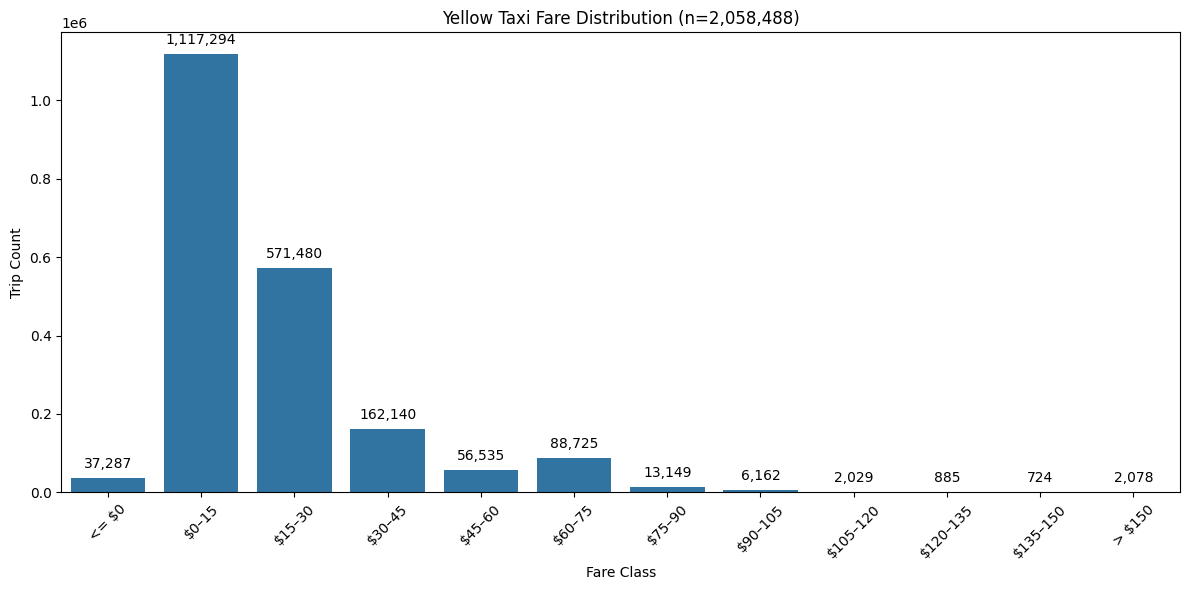

In [35]:
def analyze_taxi_fares(df, taxi_type='yellow'):
    """
    Unified function for taxi fare analysis that:
    
    1. Analyzes fare distribution
    2. Generates visualization
    
    Parameters:
        df (pd.DataFrame): Input DataFrame (yellow or green taxi data)
        taxi_type (str): 'yellow' or 'green' (for title customization)
        
        
    Returns:
        tuple: (stats, fare_distribution_df, plot_object)
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    

    
    # 1. Calculate fare distribution
    def _calculate_distribution(fare_series):
        bins = [-float('inf'), 0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, float('inf')]
        labels = ['<= $0', '$0–15', '$15–30', '$30–45', '$45–60', '$60–75', 
                 '$75–90', '$90–105', '$105–120', '$120–135', '$135–150', '> $150']
        
        fare_class = pd.cut(fare_series, bins=bins, labels=labels, right=True, include_lowest=True)
        counts = fare_class.value_counts().sort_index()
        percentages = (counts / counts.sum()) * 100
        
        return pd.DataFrame({
            'Fare Class': labels,
            'Trip Count': counts.values,
            'Percentage': percentages.round(2).values
        })
    
    # 2. Generate statistics and distribution
    stats = df['fare_amount'].describe()
    dist_df = _calculate_distribution(df['fare_amount'])
    
    # 3. Create visualization
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Fare Class', y='Trip Count', data=dist_df)
    
    for p in ax.patches:
        ax.annotate(f"{p.get_height():,.0f}", 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom', xytext=(0, 5),
                   textcoords='offset points')
    
    plt.title(f'{taxi_type.capitalize()} Taxi Fare Distribution (n={len(df):,})')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    print("\nFare Amount Statistics:")
    print(stats)
    print("\nFare Distribution:")
    print(dist_df)
    
    return stats, dist_df, plt

# Example usage:
yellow_stats, yellow_dist, yellow_plot = analyze_taxi_fares(yellow, 'yellow')
yellow_plot.show()




Fare Amount Statistics:
count    33012.000000
mean        18.289112
std         16.761944
min        -79.000000
25%         10.000000
50%         14.200000
75%         20.500000
max        546.200000
Name: fare_amount, dtype: float64

Fare Distribution:
   Fare Class  Trip Count  Percentage
0       <= $0         129        0.39
1       $0–15       18526       56.12
2      $15–30       10139       30.71
3      $30–45        2558        7.75
4      $45–60         831        2.52
5      $60–75         460        1.39
6      $75–90         181        0.55
7     $90–105          59        0.18
8    $105–120          47        0.14
9    $120–135          22        0.07
10   $135–150          15        0.05
11     > $150          45        0.14


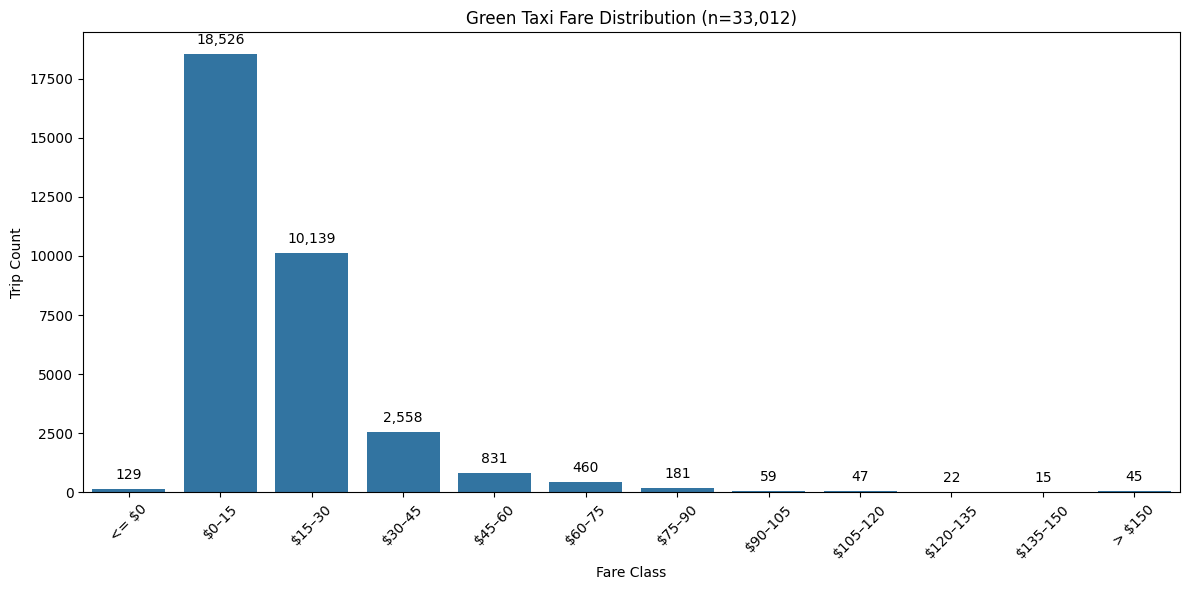

In [36]:
# for green

green_stats, green_dist, green_plot = analyze_taxi_fares(green, 'green')
green_plot.show()

 Justification for **Dropping Invalid Zero-Fare Trips**:instances where the `fare_amount` is recorded as zero, but the `payment_type` indicates a method other than "No Charge" (payment_type `3`).

This function addresses a critical data quality issue within the taxi trip records: instances where the `fare_amount` is recorded as zero, but the `payment_type` indicates a method other than "No Charge" (payment_type `3`). Such records represent a logical inconsistency, as a trip resulting in a valid payment (e.g., credit card, cash, or flex fare) should always incur a non-zero fare, at minimum the base fare of $3.00 plus applicable surcharges. These discrepancies typically arise from data logging errors, system malfunctions, or unrecorded trip cancellations where the fare meter was not accurately reset or finalized.

Retaining these inconsistent records would introduce significant bias into financial analyses, potentially understating revenue, distorting average fare calculations, and misleading predictive models. By systematically identifying and removing these invalid entries, we ensure the integrity of financial metrics and improve the reliability of subsequent data analysis and machine learning tasks. Crucially, the function is designed to **preserve legitimate "No Charge" trips** (where `fare_type` equals `3`), demonstrating a nuanced approach to data cleaning that distinguishes true errors from valid operational scenarios. The explicit reporting of removed rows and the saving of these records for audit purposes uphold principles of data governance and transparency.

In [37]:
def drop_invalid_zero_fares(df, df_name="dataframe"):
    """
    Drops all zero-fare trips where payment_type ≠ 3 (No Charge)
    - Works for both yellow and green taxi DataFrames
    - Preserves legitimate no-charge trips (payment_type=3)
    - Provides before/after reporting
    - Saves removed records with dynamic filename
    
    Parameters:
        df (pd.DataFrame): Input DataFrame (yellow or green taxi data)
        df_name (str): Name of the dataset for reporting/file naming
        
    Returns:
        pd.DataFrame: Cleaned DataFrame
    """
    import os
    import pandas as pd
    
    original_count = len(df)
    
    # --- Pre-Cleaning Report ---
    print(f"\n=== ZERO FARE CLEANING ({df_name.upper()}) ===")
    zero_fares = df[(df['fare_amount'] == 0) & (df['payment_type'] != 3)]
    valid_zero = df[(df['fare_amount'] == 0) & (df['payment_type'] == 3)]
    print(f"Total rows: {original_count:,}")
    print(f"Invalid zero-fares (payment≠3): {len(zero_fares):,}")
    print(f"Valid no-charge trips (payment=3): {len(valid_zero):,}")
    
    # --- Cleaning Process ---
    cleaned_df = df[~((df['fare_amount'] == 0) & (df['payment_type'] != 3))]
    
    # --- Post-Cleaning Report ---
    print("\n=== RESULTS ===")
    print(f"Rows removed: {len(zero_fares):,}")
    print(f"New dataset size: {len(cleaned_df):,} ({len(cleaned_df)/original_count:.1%} of original)")
    
    # Save removed records with dynamic filename
    if not zero_fares.empty:
        os.makedirs('cleaned_data', exist_ok=True)
        filename = f"cleaned_data/{df_name}_zero_fares_invalid_paytype.csv"
        zero_fares.to_csv(filename, index=False)
        print(f"\nSaved {len(zero_fares):,} removed records to '{filename}'")
    
    return cleaned_df

# Usage examples:
yellow = drop_invalid_zero_fares(yellow, df_name="yellow")



=== ZERO FARE CLEANING (YELLOW) ===
Total rows: 2,058,488
Invalid zero-fares (payment≠3): 784
Valid no-charge trips (payment=3): 107

=== RESULTS ===
Rows removed: 784
New dataset size: 2,057,704 (100.0% of original)

Saved 784 removed records to 'cleaned_data/yellow_zero_fares_invalid_paytype.csv'


In [38]:
green = drop_invalid_zero_fares(green, df_name="green")


=== ZERO FARE CLEANING (GREEN) ===
Total rows: 33,012
Invalid zero-fares (payment≠3): 13
Valid no-charge trips (payment=3): 8

=== RESULTS ===
Rows removed: 13
New dataset size: 32,999 (100.0% of original)

Saved 13 removed records to 'cleaned_data/green_zero_fares_invalid_paytype.csv'


### Justification for Fixing and Handling Negative Fare Amounts

The `fix_orphan_negated_fares` function addresses a critical data anomaly where `fare_amount` and other monetary fields are recorded as negative values. In the context of taxi trip data, negative fares are logically impossible for a service rendered, as they imply that the driver paid the passenger, or that a credit was issued without a corresponding positive initial charge. Such inconsistencies severely compromise the integrity of financial analyses, leading to inaccurate revenue calculations, skewed average fare metrics, and unreliable model training.

This function implements a sophisticated and targeted data correction strategy. It specifically identifies "orphan negated fares"—records where all fare-related monetary components (e.g., `fare_amount`, `tolls_amount`, `tip_amount`) are negative, and their absolute sum precisely matches the absolute `total_amount`. This pattern is highly indicative of a valid trip transaction that has been inadvertently recorded with inverted signs, possibly due to a system error during data capture or processing. By correcting these identified instances through a simple sign inversion, the function intelligently **recovers valuable, otherwise lost, trip data**, preserving accurate transaction details that would be discarded by a simpler approach.

For records with negative fare amounts that do not conform to this specific "sign-flip" pattern, indicating more complex or uninterpretable inconsistencies (e.g., partial negative values, negative values that don't sum correctly), the function judiciously **removes them from the dataset**. This pragmatic decision ensures that only verifiable and corrected data points are retained, preventing the propagation of fundamentally flawed records into downstream analyses. All records processed, both those fixed and those dropped, are meticulously exported to a dedicated CSV file, providing a complete audit trail and supporting data governance best practices. This approach significantly enhances the reliability and trustworthiness of the dataset for all analytical and modeling purposes.

In [39]:
def fix_orphan_negated_fares(df, df_name="dataframe", export_dir="cleaned_data"):
    """
    Corrects orphaned negative fares in NYC taxi data with dynamic dataset naming.
    
    Enhanced Features:
    - Works for both yellow and green taxi DataFrames
    - Auto-generates filename based on dataset name
    - Creates output directory if needed
    - Improved reporting with dataset context
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        df_name (str): Name of dataset ('yellow' or 'green')
        export_dir (str): Directory for output files
    
    Returns:
        pd.DataFrame: Cleaned DataFrame
    """
    import os
    import pandas as pd
    
    # Create output directory
    os.makedirs(export_dir, exist_ok=True)
    
    # Dynamic filename
    export_path = f"{export_dir}/{df_name}_fixed_negative_fares.csv"
    
    # 1. Define fare-related fields (compatible with both taxi types)
    fare_fields = [
        "fare_amount", "extra", "mta_tax", "tip_amount",
        "tolls_amount", "improvement_surcharge",
        "congestion_surcharge", "total_amount"
    ]
    
    # Only include Airport_fee if present
    if 'Airport_fee' in df.columns:
        fare_fields.append("Airport_fee")

    # 2. Filter negative fares
    neg_fare_df = df[df["fare_amount"] < 0].copy()
    neg_fare_df["was_fixed"] = "no"

    # 3. Detection rule
    def is_orphan_negated(row):
        try:
            components = [row[field] for field in fare_fields if field != "total_amount"]
            if any(pd.isna(components)) or pd.isna(row["total_amount"]):
                return False

            abs_sum = round(sum(abs(val) for val in components if not pd.isna(val)), 2)
            abs_total = round(abs(row["total_amount"]), 2)
            return (abs_sum == abs_total) and (row["total_amount"] < 0)
        except:
            return False

    # 4. Apply correction
    mask = neg_fare_df.apply(is_orphan_negated, axis=1)
    neg_fare_df.loc[mask, fare_fields] = neg_fare_df.loc[mask, fare_fields].abs()
    neg_fare_df.loc[mask, "was_fixed"] = "yes"

    # 5. Update main DataFrame
    unfixed_index = neg_fare_df[neg_fare_df["was_fixed"] == "no"].index
    df = df.drop(index=unfixed_index)
    df.update(neg_fare_df.loc[mask, fare_fields])

    # 6. Save audit report
    neg_fare_df.to_csv(export_path, index=False)

    # 7. Enhanced reporting
    total_records = len(df) + len(unfixed_index)
    total_neg = len(neg_fare_df)
    fixed_count = mask.sum()
    
    print(f"\n=== NEGATIVE FARE CORRECTION ({df_name.upper()}) ===")
    print(f"Total records processed         : {total_records:,}")
    print(f"Negative fare records found     : {total_neg:,} ({(total_neg/total_records)*100:.2f}%)")
    print(f"Records corrected (full reversals) : {fixed_count:,}")
    print(f"Records dropped (partial negatives): {len(unfixed_index):,}")
    print(f"\nAudit report saved to: {export_path}")
    
    return df

# Usage examples:
yellow = fix_orphan_negated_fares(yellow, df_name="yellow")



=== NEGATIVE FARE CORRECTION (YELLOW) ===
Total records processed         : 2,057,704
Negative fare records found     : 36,396 (1.77%)
Records corrected (full reversals) : 24,814
Records dropped (partial negatives): 11,582

Audit report saved to: cleaned_data/yellow_fixed_negative_fares.csv


In [40]:
green = fix_orphan_negated_fares(green, df_name="green")


=== NEGATIVE FARE CORRECTION (GREEN) ===
Total records processed         : 32,999
Negative fare records found     : 108 (0.33%)
Records corrected (full reversals) : 98
Records dropped (partial negatives): 10

Audit report saved to: cleaned_data/green_fixed_negative_fares.csv


# **Trip distance cleaing**


=== YELLOW TAXI DISTANCE ANALYSIS ===

Distance Statistics:
count    2.046122e+06
mean     4.802764e+00
std      3.883698e+02
min      0.000000e+00
25%      1.010000e+00
50%      1.750000e+00
75%      3.360000e+00
max      1.959168e+05
Name: trip_distance, dtype: float64

Distance Distribution:
   Distance Class (mi)  Trip Count  Percentage
0                 <= 0       37091        1.81
1                  0–1      471032       23.02
2                  1–2      648190       31.68
3                  2–3      315929       15.44
4                  3–4      149136        7.29
5                  4–5       79459        3.88
6                  5–6       51664        2.52
7                  6–7       36598        1.79
8                  7–8       28392        1.39
9                  8–9       31073        1.52
10                9–10       32314        1.58
11               10–12       43508        2.13
12               12–14       17444        0.85
13               14–16       14562        0.7

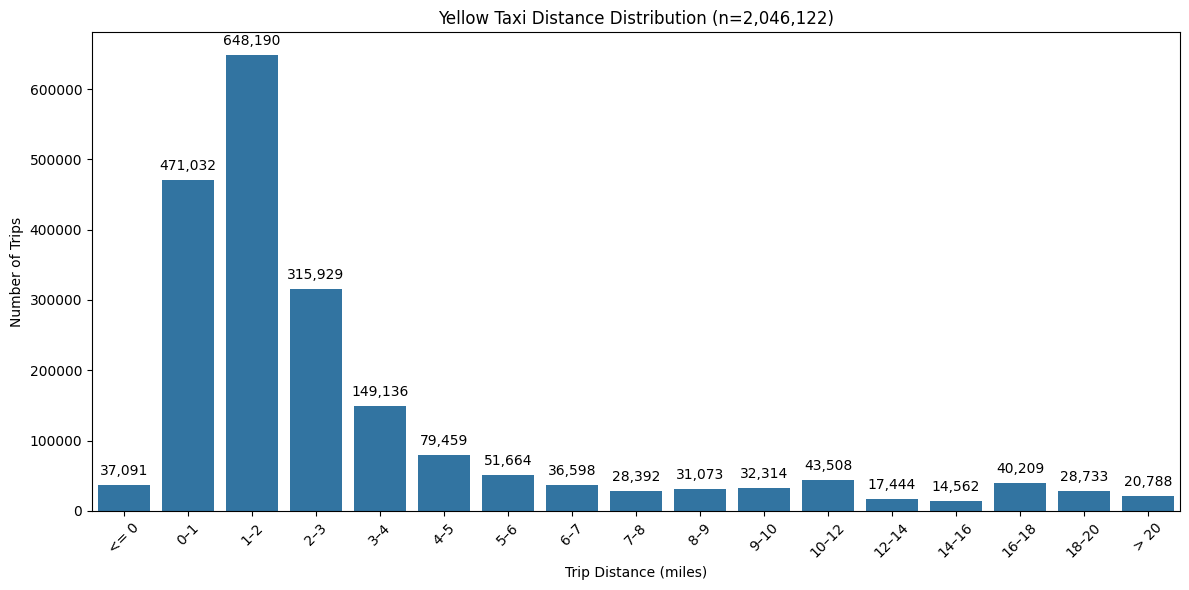

In [41]:
def analyze_taxi_distances(df, df_name="dataframe", distance_col='trip_distance'):
    """
    Unified function for taxi distance analysis that:
    1. Analyzes distance distribution
    2. Generates visualization with dataset context
    3. Provides statistical summary
    
    Parameters:
        df (pd.DataFrame): Input DataFrame (yellow or green taxi data)
        df_name (str): Name of dataset ('yellow' or 'green')
        distance_col (str): Name of distance column
        
    Returns:
        tuple: (stats, distance_distribution_df, plot_object)
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # 1. Calculate statistics
    stats = df[distance_col].describe()
    
    # 2. Calculate distance distribution
    def _calculate_distribution(distance_series):
        bins = [-float('inf'), 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                12, 14, 16, 18, 20, float('inf')]
        labels = [
            '<= 0', '0–1', '1–2', '2–3', '3–4', '4–5', '5–6', '6–7', '7–8',
            '8–9', '9–10', '10–12', '12–14', '14–16', '16–18', '18–20', '> 20'
        ]
        
        distance_class = pd.cut(distance_series, bins=bins, labels=labels, 
                               right=True, include_lowest=True)
        counts = distance_class.value_counts().sort_index()
        percentages = (counts / counts.sum()) * 100
        
        return pd.DataFrame({
            'Distance Class (mi)': labels,
            'Trip Count': counts.values,
            'Percentage': percentages.round(2).values
        })
    
    dist_df = _calculate_distribution(df[distance_col])
    
    # 3. Create visualization
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Distance Class (mi)', y='Trip Count', data=dist_df)
    
    for p in ax.patches:
        ax.annotate(f"{p.get_height():,.0f}", 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom', xytext=(0, 5),
                   textcoords='offset points')
    
    plt.title(f'{df_name.capitalize()} Taxi Distance Distribution (n={len(df):,})')
    plt.xlabel('Trip Distance (miles)')
    plt.ylabel('Number of Trips')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # 4. Reporting
    print(f"\n=== {df_name.upper()} TAXI DISTANCE ANALYSIS ===")
    print("\nDistance Statistics:")
    print(stats)
    print("\nDistance Distribution:")
    print(dist_df)
    
    return stats, dist_df, plt

# Usage examples:
yellow_stats, yellow_dist, yellow_plot = analyze_taxi_distances(yellow, 'yellow')
yellow_plot.show()




=== GREEN TAXI DISTANCE ANALYSIS ===

Distance Statistics:
count     32989.000000
mean         22.831206
std        1729.022136
min           0.000000
25%           1.120000
50%           1.850000
75%           3.230000
max      233972.430000
Name: trip_distance, dtype: float64

Distance Distribution:
   Distance Class (mi)  Trip Count  Percentage
0                 <= 0        1755        5.32
1                  0–1        5270       15.98
2                  1–2       10792       32.71
3                  2–3        6066       18.39
4                  3–4        3233        9.80
5                  4–5        1406        4.26
6                  5–6        1016        3.08
7                  6–7         929        2.82
8                  7–8         664        2.01
9                  8–9         408        1.24
10                9–10         303        0.92
11               10–12         417        1.26
12               12–14         242        0.73
13               14–16         154    

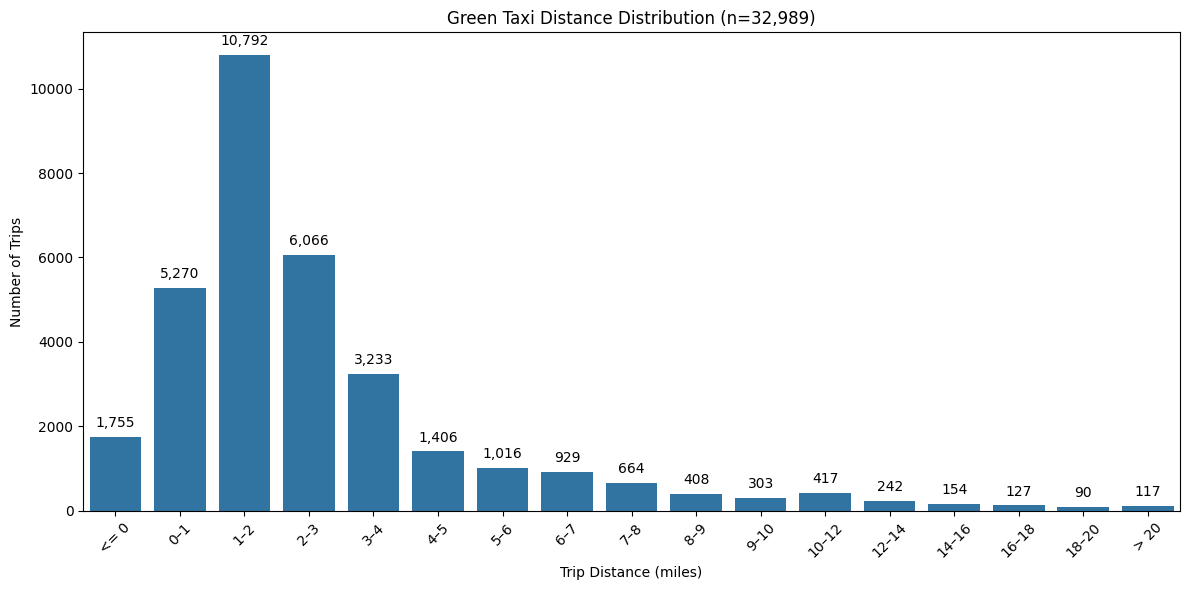

In [42]:
# for green

green_stats, green_dist, green_plot = analyze_taxi_distances(green, 'green')
green_plot.show()

🔍 Investigation of Short-Distance Trips (0.0-0.1 miles)
Total trips in dataset: 2,046,122
Short trips identified: 46,907 (2.29%)
Reference trips (>0.1mi): 1,999,215

📊 Fare Amount Comparison:
       Short Trips  All Valid Trips
count     46907.00       1999215.00
mean         27.02            19.80
std          43.31            17.83
min           0.00             0.00
25%           3.70             9.30
50%          15.41            14.20
75%          32.66            22.60
max        5000.00          1458.30


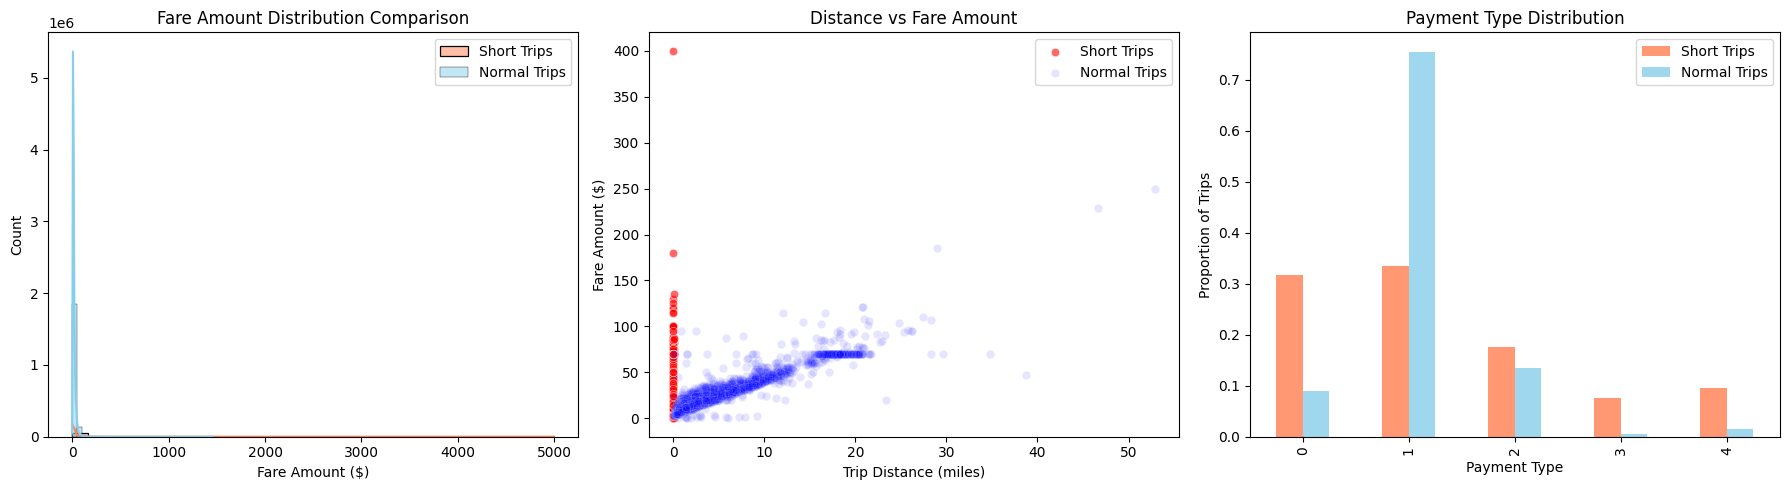


🔎 Suspicious Pattern Detection:
- 24767 short trips (52.8%) have fares above normal median ($14.20)


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def investigate_short_distance_trips(df, dist_col='trip_distance', fare_col='fare_amount'):
    """
    Analyzes ultra-short taxi trips (0.0-0.1 miles) to detect potential data issues or 
    legitimate short hops, comparing them against fare amounts and overall trip patterns.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing taxi trip records
        dist_col (str): Column name for trip distance (default: 'trip_distance')
        fare_col (str): Column name for fare amount (default: 'fare_amount')

    Returns:
        pd.DataFrame: DataFrame containing only the short-distance trips (0.0-0.1 miles)
        
    Outputs:
        - Prints statistical summary comparing short trips vs all trips
        - Displays three comparative visualizations:
            1. Fare amount distributions
            2. Distance vs fare scatterplot
            3. Payment type distribution
        
    Business Logic:
        - Focuses on trips ≤ 0.1 miles which may indicate:
            * Meter calibration issues
            * GPS inaccuracies at pickup/dropoff
            * Legitimate very short hops
        - Compares against normal trip patterns to identify anomalies
    """
    # Filter the short-distance trips and valid trips for comparison
    short_trips = df[(df[dist_col] >= 0.0) & (df[dist_col] <= 0.1)].copy()
    valid_trips = df[df[dist_col] > 0.1].copy()
    
    print(f"🔍 Investigation of Short-Distance Trips (0.0-0.1 miles)")
    print(f"Total trips in dataset: {len(df):,}")
    print(f"Short trips identified: {len(short_trips):,} ({(len(short_trips)/len(df)*100):.2f}%)")
    print(f"Reference trips (>0.1mi): {len(valid_trips):,}")

    # Comparative statistics
    print("\n📊 Fare Amount Comparison:")
    print(pd.DataFrame({
        'Short Trips': short_trips[fare_col].describe(),
        'All Valid Trips': valid_trips[fare_col].describe()
    }).round(2))

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Fare distribution comparison
    sns.histplot(short_trips[fare_col], bins=30, kde=True, 
                 ax=axes[0], color='coral', label='Short Trips')
    sns.histplot(valid_trips[fare_col], bins=30, kde=True, 
                 ax=axes[0], color='skyblue', alpha=0.5, label='Normal Trips')
    axes[0].set_title("Fare Amount Distribution Comparison")
    axes[0].set_xlabel("Fare Amount ($)")
    axes[0].legend()
    
    # Plot 2: Distance vs Fare scatter
    sample_short = short_trips.sample(min(500, len(short_trips)))
    sample_valid = valid_trips.sample(min(5000, len(valid_trips)))
    sns.scatterplot(data=sample_short, x=dist_col, y=fare_col, 
                    ax=axes[1], color='red', alpha=0.6, label='Short Trips')
    sns.scatterplot(data=sample_valid, x=dist_col, y=fare_col, 
                    ax=axes[1], color='blue', alpha=0.1, label='Normal Trips')
    axes[1].set_title("Distance vs Fare Amount")
    axes[1].set_xlabel("Trip Distance (miles)")
    axes[1].set_ylabel("Fare Amount ($)")
    axes[1].legend()
    
    # Plot 3: Payment type distribution
    payment_comparison = pd.DataFrame({
        'Short Trips': short_trips['payment_type'].value_counts(normalize=True),
        'Normal Trips': valid_trips['payment_type'].value_counts(normalize=True)
    })
    payment_comparison.plot(kind='bar', ax=axes[2], 
                           color=['coral', 'skyblue'], alpha=0.8)
    axes[2].set_title("Payment Type Distribution")
    axes[2].set_xlabel("Payment Type")
    axes[2].set_ylabel("Proportion of Trips")
    
    plt.tight_layout()
    plt.show()
    
    # Additional statistics
    print("\n🔎 Suspicious Pattern Detection:")
    high_fare_short = short_trips[short_trips[fare_col] > valid_trips[fare_col].median()]
    print(f"- {len(high_fare_short)} short trips ({len(high_fare_short)/len(short_trips):.1%})",
          f"have fares above normal median (${valid_trips[fare_col].median():.2f})")
    
    return short_trips

# Example usage
short_trips_df = investigate_short_distance_trips(
    yellow, 
    dist_col='trip_distance', 
    fare_col='fare_amount'
)

🔍 Investigation of Short-Distance Trips (0.0-0.1 miles)
Total trips in dataset: 32,989
Short trips identified: 2,065 (6.26%)
Reference trips (>0.1mi): 30,924

📊 Fare Amount Comparison:
       Short Trips  All Valid Trips
count      2065.00         30924.00
mean         22.74            18.08
std          25.68            15.86
min           0.00             0.00
25%           7.90            10.00
50%          17.50            13.50
75%          29.50            20.50
max         450.00           546.20


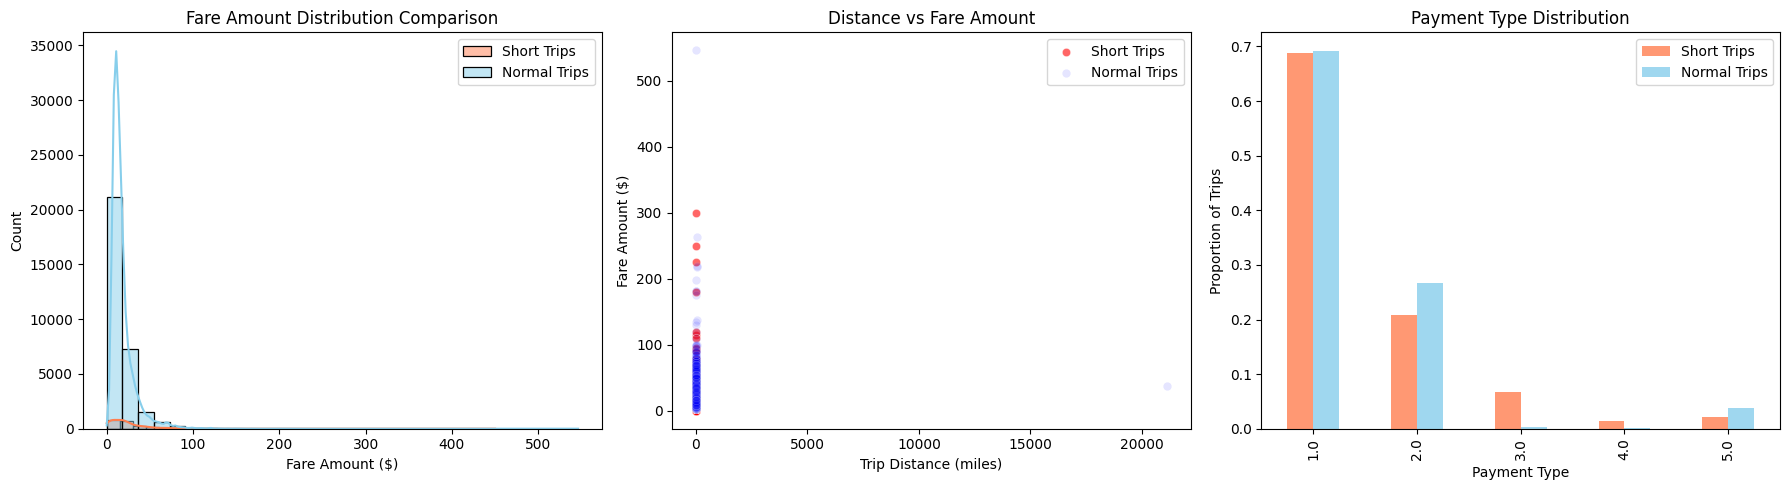


🔎 Suspicious Pattern Detection:
- 1278 short trips (61.9%) have fares above normal median ($13.50)


In [44]:
# for green
short_trips_df_green = investigate_short_distance_trips(
    green, 
    dist_col='trip_distance', 
    fare_col='fare_amount'
)

In [45]:
#zero distance trips 

zero_distace = yellow['trip_distance'] == 0.00
def display_zero_distances(df, distance_col='trip_distance', display_rows=5):
    """
    Display records with zero trip distances in the DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing trip data.
        distance_col (str): Name of the column containing trip distances.
        display_rows (int): Number of rows to preview from zero-distance entries.
        
    Returns:
        pd.DataFrame: DataFrame with zero distances and their counts.
    """
    zero_distances = df[df[distance_col] == 0.00]
    
    if zero_distances.empty:
        print("✅ No zero trip distances found.")
        return pd.DataFrame()
    
    zero_count = len(zero_distances)
    total_count = len(df)
    print(f"⚠️ Found {zero_count} zero trip distances "
          f"({(zero_count / total_count) * 100:.4f}% of all records):")
    
    print(f"\n🔍 Sample of {display_rows} zero-distance trips:")
    display(zero_distances.head(display_rows))
    
    print("\n📊 Summary of Zero Distances:")
    print(zero_distances[distance_col].describe())
    
    return zero_distances
# Display zero distances in the yellow DataFrame
zero_distances_yellow = display_zero_distances(yellow, distance_col='trip_distance')



⚠️ Found 37091 zero trip distances (1.8127% of all records):

🔍 Sample of 5 zero-distance trips:


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
2           1  2024-01-01 12:06:50   2024-01-01 12:10:49              1.0   
38          1  2024-01-01 04:14:30   2024-01-01 04:28:50              1.0   
54          1  2024-01-01 11:19:32   2024-01-01 11:26:31              1.0   
79          1  2024-01-01 07:52:11   2024-01-01 07:59:24              1.0   
111         1  2024-01-01 22:34:41   2024-01-01 22:35:03              1.0   

     trip_distance  RatecodeID store_and_fwd_flag PULocationID DOLocationID  \
2              0.0        99.0                  N          230           43   
38             0.0        99.0                  N           13          229   
54             0.0        99.0                  N          224           87   
79             0.0        99.0                  N          162          237   
111            0.0         1.0                  N          132          132   

     payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
2               0        12.16   0.00      0.5         0.0           0.0   
38              0        25.84   0.00      0.5         0.0           0.0   
54              0        11.75   0.00      0.5         0.0           0.0   
79              0         9.08   0.00      0.5         0.0           0.0   
111             3         3.00   2.75      0.5         0.0           0.0   

     improvement_surcharge  total_amount  congestion_surcharge  Airport_fee  \
2                      1.0         16.16                   2.5         0.00   
38                     1.0         29.84                   2.5         0.00   
54                     1.0         15.75                   2.5         0.00   
79                     1.0         13.08                   2.5         0.00   
111                    1.0          7.25                   2.5         1.75   

    pickup_date PU_Borough                         PU_Zone PU_ServiceZone  \
2    2024-01-01  Manhattan       Times Sq/Theatre District    Yellow Zone   
38   2024-01-01  Manhattan               Battery Park City    Yellow Zone   
54   2024-01-01  Manhattan  Stuy Town/Peter Cooper Village    Yellow Zone   
79   2024-01-01  Manhattan                    Midtown East    Yellow Zone   
111  2024-01-01     Queens                     JFK Airport       Airports   

    DO_Borough                        DO_Zone DO_ServiceZone  
2    Manhattan                   Central Park    Yellow Zone  
38   Manhattan  Sutton Place/Turtle Bay North    Yellow Zone  
54   Manhattan       Financial District North    Yellow Zone  
79   Manhattan          Upper East Side South    Yellow Zone  
111     Queens                    JFK Airport       Airports


📊 Summary of Zero Distances:
count    37091.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: trip_distance, dtype: float64


In [46]:
# Display zero distances in the green DataFrame
zero_distances_green = display_zero_distances(green, distance_col='trip_distance')

⚠️ Found 1755 zero trip distances (5.3200% of all records):

🔍 Sample of 5 zero-distance trips:


VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0          1  2024-01-01 06:25:24   2024-01-01 06:25:27                  N   
8          2  2024-01-01 06:48:52   2024-01-01 06:49:36                  N   
10         2  2024-01-01 02:10:59   2024-01-01 02:11:03                  N   
30         1  2024-01-01 11:45:12   2024-01-01 12:10:42                  N   
67         1  2024-01-02 10:02:09   2024-01-02 10:02:52                  N   

    RatecodeID PULocationID DOLocationID  passenger_count  trip_distance  \
0          1.0          165          165              1.0            0.0   
8          5.0          260          260              2.0            0.0   
10         5.0          218          218              1.0            0.0   
30         1.0           85          216              1.0            0.0   
67         5.0          223          223              1.0            0.0   

    fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0           3.0    0.0      1.5       25.00           0.0   
8          15.0    0.0      0.0        0.09           0.0   
10         25.0    0.0      0.0        0.00           0.0   
30         33.5    0.0      1.5        0.00           0.0   
67         15.0    0.0      0.0        0.00           0.0   

    improvement_surcharge  total_amount  payment_type  trip_type  \
0                     1.0         29.50           1.0        1.0   
8                     1.0         16.09           1.0        2.0   
10                    1.0         26.00           1.0        2.0   
30                    1.0         35.00           1.0        1.0   
67                    0.0         15.00           1.0        2.0   

    congestion_surcharge pickup_date PU_Borough                    PU_Zone  \
0                    0.0  2024-01-01   Brooklyn                    Midwood   
8                    0.0  2024-01-01     Queens                   Woodside   
10                   0.0  2024-01-01     Queens  Springfield Gardens North   
30                   0.0  2024-01-01   Brooklyn                    Erasmus   
67                   0.0  2024-01-02     Queens                   Steinway   

   PU_ServiceZone DO_Borough                    DO_Zone DO_ServiceZone  
0       Boro Zone   Brooklyn                    Midwood      Boro Zone  
8       Boro Zone     Queens                   Woodside      Boro Zone  
10      Boro Zone     Queens  Springfield Gardens North      Boro Zone  
30      Boro Zone     Queens           South Ozone Park      Boro Zone  
67      Boro Zone     Queens                   Steinway      Boro Zone


📊 Summary of Zero Distances:
count    1755.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: trip_distance, dtype: float64


In [47]:
# zero distances where pulocationid =!= dolocationid (yellow taxi )
def display_zero_distance_mismatch(df, pu_locid_col='PULocationID', do_locid_col='DOLocationID', distance_col='trip_distance', display_rows=5):
    """
    Display records with zero trip distances where pickup and dropoff locations do not match.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing trip data.
        pu_locid_col (str): Name of the pickup location ID column.
        do_locid_col (str): Name of the dropoff location ID column.
        distance_col (str): Name of the column containing trip distances.
        display_rows (int): Number of rows to preview from zero-distance entries.
        
    Returns:
        pd.DataFrame: DataFrame with zero distances and their counts.
    """
    zero_distance_mismatch = df[(df[distance_col] == 0.00) & (df[pu_locid_col] != df[do_locid_col])]
    
    if zero_distance_mismatch.empty:
        print("✅ No zero trip distances with mismatched locations found.")
        return pd.DataFrame()
    
    zero_count = len(zero_distance_mismatch)
    total_count = len(df)
    print(f"⚠️ Found {zero_count} zero trip distances with mismatched locations "
          f"({(zero_count / total_count) * 100:.4f}% of all records):")
    
    print(f"\n🔍 Sample of {display_rows} mismatched zero-distance trips:")
    display(zero_distance_mismatch.head(display_rows))
    
    print("\n📊 Summary of Zero Distances with Mismatched Locations:")
    print(zero_distance_mismatch[distance_col].describe())
    
    return zero_distance_mismatch
# Display zero distances with mismatched locations in the yellow DataFrame
zero_distance_mismatch_yellow = display_zero_distance_mismatch(
    yellow, 
    pu_locid_col='PULocationID', 
    do_locid_col='DOLocationID', 
    distance_col='trip_distance'
)

⚠️ Found 19695 zero trip distances with mismatched locations (0.9626% of all records):

🔍 Sample of 5 mismatched zero-distance trips:


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
2           1  2024-01-01 12:06:50   2024-01-01 12:10:49              1.0   
38          1  2024-01-01 04:14:30   2024-01-01 04:28:50              1.0   
54          1  2024-01-01 11:19:32   2024-01-01 11:26:31              1.0   
79          1  2024-01-01 07:52:11   2024-01-01 07:59:24              1.0   
130         1  2024-01-01 15:49:03   2024-01-01 16:11:52              1.0   

     trip_distance  RatecodeID store_and_fwd_flag PULocationID DOLocationID  \
2              0.0        99.0                  N          230           43   
38             0.0        99.0                  N           13          229   
54             0.0        99.0                  N          224           87   
79             0.0        99.0                  N          162          237   
130            0.0        99.0                  N          148          142   

     payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
2               0        12.16    0.0      0.5         0.0           0.0   
38              0        25.84    0.0      0.5         0.0           0.0   
54              0        11.75    0.0      0.5         0.0           0.0   
79              0         9.08    0.0      0.5         0.0           0.0   
130             0        27.84    0.0      0.5         0.0           0.0   

     improvement_surcharge  total_amount  congestion_surcharge  Airport_fee  \
2                      1.0         16.16                   2.5          0.0   
38                     1.0         29.84                   2.5          0.0   
54                     1.0         15.75                   2.5          0.0   
79                     1.0         13.08                   2.5          0.0   
130                    1.0         31.84                   2.5          0.0   

    pickup_date PU_Borough                         PU_Zone PU_ServiceZone  \
2    2024-01-01  Manhattan       Times Sq/Theatre District    Yellow Zone   
38   2024-01-01  Manhattan               Battery Park City    Yellow Zone   
54   2024-01-01  Manhattan  Stuy Town/Peter Cooper Village    Yellow Zone   
79   2024-01-01  Manhattan                    Midtown East    Yellow Zone   
130  2024-01-01  Manhattan                 Lower East Side    Yellow Zone   

    DO_Borough                        DO_Zone DO_ServiceZone  
2    Manhattan                   Central Park    Yellow Zone  
38   Manhattan  Sutton Place/Turtle Bay North    Yellow Zone  
54   Manhattan       Financial District North    Yellow Zone  
79   Manhattan          Upper East Side South    Yellow Zone  
130  Manhattan            Lincoln Square East    Yellow Zone


📊 Summary of Zero Distances with Mismatched Locations:
count    19695.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: trip_distance, dtype: float64


In [48]:
zero_distance_mismatch_green= display_zero_distance_mismatch(
    green, 
    pu_locid_col='PULocationID', 
    do_locid_col='DOLocationID', 
    distance_col='trip_distance'
)

⚠️ Found 1070 zero trip distances with mismatched locations (3.2435% of all records):

🔍 Sample of 5 mismatched zero-distance trips:


VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
30          1  2024-01-01 11:45:12   2024-01-01 12:10:42                  N   
72          1  2024-01-02 08:10:53   2024-01-02 08:10:53                  N   
74          1  2024-01-02 11:04:59   2024-01-02 11:16:49                  N   
77          2  2024-01-02 04:52:51   2024-01-02 04:52:54                  N   
102         1  2024-01-02 09:14:09   2024-01-02 09:28:35                  N   

     RatecodeID PULocationID DOLocationID  passenger_count  trip_distance  \
30          1.0           85          216              1.0            0.0   
72          1.0           74          264              1.0            0.0   
74          1.0           85          188              1.0            0.0   
77          5.0          212          264              1.0            0.0   
102         1.0          235           74              1.0            0.0   

     fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
30          33.5    0.0      1.5         0.0           0.0   
72           8.6    0.0      1.5         0.0           0.0   
74          17.5    0.0      1.5         0.0           0.0   
77          15.0    0.0      0.0         0.0           0.0   
102         23.5    0.0      1.5         0.0           0.0   

     improvement_surcharge  total_amount  payment_type  trip_type  \
30                     1.0          35.0           1.0        1.0   
72                     1.0          10.1           2.0        1.0   
74                     1.0          19.0           1.0        1.0   
77                     1.0          16.0           1.0        2.0   
102                    1.0          25.0           1.0        1.0   

     congestion_surcharge pickup_date PU_Borough  \
30                    0.0  2024-01-01   Brooklyn   
72                    0.0  2024-01-02  Manhattan   
74                    0.0  2024-01-02   Brooklyn   
77                    0.0  2024-01-02      Bronx   
102                   0.0  2024-01-02      Bronx   

                               PU_Zone PU_ServiceZone DO_Borough  \
30                             Erasmus      Boro Zone     Queens   
72                   East Harlem North      Boro Zone  Undefined   
74                             Erasmus      Boro Zone   Brooklyn   
77                  Soundview/Bruckner      Boro Zone  Undefined   
102  University Heights/Morris Heights      Boro Zone  Manhattan   

                       DO_Zone DO_ServiceZone  
30            South Ozone Park      Boro Zone  
72                   Undefined      Undefined  
74   Prospect-Lefferts Gardens      Boro Zone  
77                   Undefined      Undefined  
102          East Harlem North      Boro Zone


📊 Summary of Zero Distances with Mismatched Locations:
count    1070.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: trip_distance, dtype: float64


## Handle zero trip distance mismatch
- BY imputing the median distance of their of their pair groupp pu/do location id 

In [49]:
def impute_zero_trip_distance_mismatchloc(df, df_name="dataframe", export_dir="cleaned_data"):
    """
    Fixes zero trip distances where PU ≠ DO using route medians.
    
    Features:
    - Imputes zero trip_distance based on median of PU-DO pairs
    - Drops rows where no median is available
    - Generates a full fix report: 'imputed' vs 'dropped'
    - Supports both Yellow and Green datasets via df_name
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        df_name (str): Used for report file naming
        export_dir (str): Directory to store the report

    Returns:
        pd.DataFrame: Cleaned DataFrame with imputed values and unfixable rows removed
    """
    import os
    import pandas as pd
    import numpy as np

    original = df.copy()

    # --- Pre-Cleaning Report ---
    print(f"\n=== TRIP DISTANCE CLEANING ({df_name.upper()}) ===")
    zero_trips = (df['trip_distance'] == 0)
    eligible = zero_trips & (df['PULocationID'] != df['DOLocationID'])
    print(f"Total rows: {len(df):,}")
    print(f"Zero-distance trips: {zero_trips.sum():,}")
    print(f"Eligible for imputation (PU≠DO): {eligible.sum():,}")

    # Step 1: Build PU-DO median dictionary
    pu_do_medians = (
        df[df['trip_distance'] > 0]
        .groupby(['PULocationID', 'DOLocationID'])['trip_distance']
        .median()
        .to_dict()
    )

    # Step 2: Mark fixability
    df['was_fixed'] = ''
    route_keys = list(zip(df['PULocationID'], df['DOLocationID']))
    fixable_mask = pd.Series(route_keys, index=df.index).isin(pu_do_medians)

    # Step 3: Apply fixes
    df.loc[eligible, 'was_fixed'] = np.where(
        fixable_mask[eligible],
        'yes',
        'no'
    )
    for idx in df[eligible & fixable_mask].index:
        pu, do = df.at[idx, 'PULocationID'], df.at[idx, 'DOLocationID']
        df.at[idx, 'trip_distance'] = pu_do_medians[(pu, do)]

    # Step 4: Filter cleaned vs unfixable
    fixed = df[df['was_fixed'] == 'yes']
    unfixable = df[df['was_fixed'] == 'no']
    cleaned_df = df[~df.index.isin(unfixable.index)]

    # --- Post-Cleaning Report ---
    print("\n=== RESULTS ===")
    print(f"Rows successfully fixed: {len(fixed):,}")
    print(f"Rows dropped (no median available): {len(unfixable):,}")
    print(f"Final dataset size: {len(cleaned_df):,} ({len(cleaned_df)/len(original):.1%} of original)")

    # Step 5: Save fix report
    if len(fixed) > 0 or len(unfixable) > 0:
        os.makedirs(export_dir, exist_ok=True)
        fix_report = pd.concat([
            fixed.assign(action='imputed'),
            unfixable.assign(action='dropped')
        ])
        report_path = os.path.join(export_dir, f'{df_name}_trip_distance_fix_report.csv')
        fix_report.to_csv(report_path, index=False)
        print(f"\nSaved fix report with {len(fix_report):,} records to {report_path}")

    # Step 6: Return cleaned version
    return cleaned_df.drop(columns=['was_fixed'], errors='ignore')

# Usage
yellow = impute_zero_trip_distance_mismatchloc(yellow, df_name="yellow")


=== TRIP DISTANCE CLEANING (YELLOW) ===
Total rows: 2,046,122
Zero-distance trips: 37,091
Eligible for imputation (PU≠DO): 19,695

=== RESULTS ===
Rows successfully fixed: 19,198
Rows dropped (no median available): 497
Final dataset size: 2,045,625 (100.0% of original)

Saved fix report with 19,695 records to cleaned_data\yellow_trip_distance_fix_report.csv


In [50]:
# for green 
green = impute_zero_trip_distance_mismatchloc(green, df_name="green")



=== TRIP DISTANCE CLEANING (GREEN) ===
Total rows: 32,989
Zero-distance trips: 1,755
Eligible for imputation (PU≠DO): 1,070

=== RESULTS ===
Rows successfully fixed: 493
Rows dropped (no median available): 577
Final dataset size: 32,412 (98.3% of original)

Saved fix report with 1,070 records to cleaned_data\green_trip_distance_fix_report.csv


#  **Feature Engineering: Duration**

In [51]:
# duration 
def add_duration_column(df, pickup_col='pickup_datetime', dropoff_col='dropoff_datetime'):
    """
    Adds a 'duration_inMin' column to the DataFrame, representing the trip duration in fractional minutes.
    Handles invalid datetime strings safely.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing pickup and dropoff datetime columns.
        pickup_col (str): Name of the pickup datetime column.
        dropoff_col (str): Name of the dropoff datetime column.
        
    Returns:
        pd.DataFrame: DataFrame with an added 'duration_inMin' column.
    """
    df[pickup_col] = pd.to_datetime(df[pickup_col], errors='coerce')
    df[dropoff_col] = pd.to_datetime(df[dropoff_col], errors='coerce')
    
    # calculate duration in minutes
    df['duration_inMin'] = (df[dropoff_col] - df[pickup_col]).dt.total_seconds() / 60.0


    
    return df
    

# Add duration column to each DataFrame
yellow = add_duration_column(yellow, pickup_col='tpep_pickup_datetime', dropoff_col='tpep_dropoff_datetime')



# Display the description of the duration column in each DataFrame  
print("\nDuration Column Description for Yellow Taxi:")
print(yellow['duration_inMin'].describe())






Duration Column Description for Yellow Taxi:
count    2.045625e+06
mean     1.749575e+01
std      3.472270e+01
min     -5.665000e+01
25%      7.833333e+00
50%      1.300000e+01
75%      2.113333e+01
max      6.887817e+03
Name: duration_inMin, dtype: float64


we detect Negative duration !!

In [52]:
green = add_duration_column(green, pickup_col='lpep_pickup_datetime', dropoff_col='lpep_dropoff_datetime')
# Display the description of the duration column green
print("\nDuration Column Description for Green Taxi:")
print(green['duration_inMin'].describe())


Duration Column Description for Green Taxi:
count    32412.000000
mean        18.758840
std         76.529227
min          0.000000
25%          7.483333
50%         11.783333
75%         17.916667
max       1439.066667
Name: duration_inMin, dtype: float64


## **Duration destribtion for (Yellow & Green)**


=== YELLOW TAXI DURATION ANALYSIS ===

Duration Statistics (minutes):
count    2.045625e+06
mean     1.749575e+01
std      3.472270e+01
min     -5.665000e+01
25%      7.833333e+00
50%      1.300000e+01
75%      2.113333e+01
max      6.887817e+03
Name: duration_inMin, dtype: float64

Duration Distribution:
  Duration Class  Trip Count  Percentage
0       <= 0 min         622        0.03
1       0–15 min     1183441       57.85
2      15–30 min      607457       29.70
3      30–45 min      156738        7.66
4      45–60 min       56946        2.78
5      60–75 min       24468        1.20
6      75–90 min        9369        0.46
7     90–105 min        3302        0.16
8    105–120 min        1150        0.06
9      > 120 min        2132        0.10


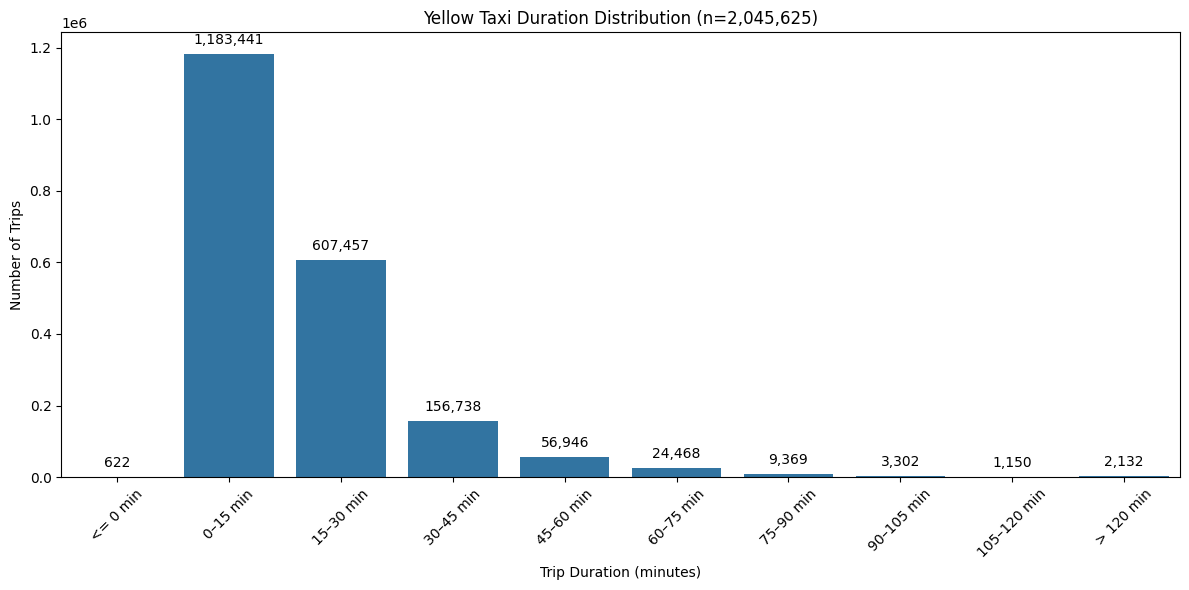

In [53]:
def analyze_taxi_durations(df, df_name="dataframe", duration_col='duration_inMin'):
    """
    Unified function for taxi duration analysis that:
    1. Analyzes duration distribution
    2. Generates visualization with dataset context
    3. Provides statistical summary
    
    Parameters:
        df (pd.DataFrame): Input DataFrame (yellow or green taxi data)
        df_name (str): Name of dataset ('yellow' or 'green')
        duration_col (str): Name of duration column (in minutes)
        
    Returns:
        tuple: (stats, duration_distribution_df, plot_object)
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # 1. Calculate statistics
    stats = df[duration_col].describe()
    
    # 2. Calculate duration distribution
    def _calculate_distribution(duration_series):
        bins = [-float('inf'), 0, 15, 30, 45, 60, 75, 90, 105, 120, float('inf')]
        labels = [
            '<= 0 min', '0–15 min', '15–30 min', '30–45 min',
            '45–60 min', '60–75 min', '75–90 min',
            '90–105 min', '105–120 min', '> 120 min'
        ]
        
        duration_class = pd.cut(duration_series, bins=bins, labels=labels, 
                              right=True, include_lowest=True)
        counts = duration_class.value_counts().sort_index()
        percentages = (counts / counts.sum()) * 100
        
        return pd.DataFrame({
            'Duration Class': labels,
            'Trip Count': counts.values,
            'Percentage': percentages.round(2).values
        })
    
    dist_df = _calculate_distribution(df[duration_col])
    
    # 3. Create visualization
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Duration Class', y='Trip Count', data=dist_df)
    
    for p in ax.patches:
        ax.annotate(f"{p.get_height():,.0f}", 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom', xytext=(0, 5),
                   textcoords='offset points')
    
    plt.title(f'{df_name.capitalize()} Taxi Duration Distribution (n={len(df):,})')
    plt.xlabel('Trip Duration (minutes)')
    plt.ylabel('Number of Trips')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # 4. Reporting
    print(f"\n=== {df_name.upper()} TAXI DURATION ANALYSIS ===")
    print("\nDuration Statistics (minutes):")
    print(stats)
    print("\nDuration Distribution:")
    print(dist_df)
    
    return stats, dist_df, plt

# Usage examples:
yellow_stats, yellow_dist, yellow_plot = analyze_taxi_durations(yellow, 'yellow')
yellow_plot.show()




=== GREEN TAXI DURATION ANALYSIS ===

Duration Statistics (minutes):
count    32412.000000
mean        18.758840
std         76.529227
min          0.000000
25%          7.483333
50%         11.783333
75%         17.916667
max       1439.066667
Name: duration_inMin, dtype: float64

Duration Distribution:
  Duration Class  Trip Count  Percentage
0       <= 0 min          30        0.09
1       0–15 min       21239       65.53
2      15–30 min        8702       26.85
3      30–45 min        1651        5.09
4      45–60 min         408        1.26
5      60–75 min         132        0.41
6      75–90 min          61        0.19
7     90–105 min          30        0.09
8    105–120 min           6        0.02
9      > 120 min         153        0.47


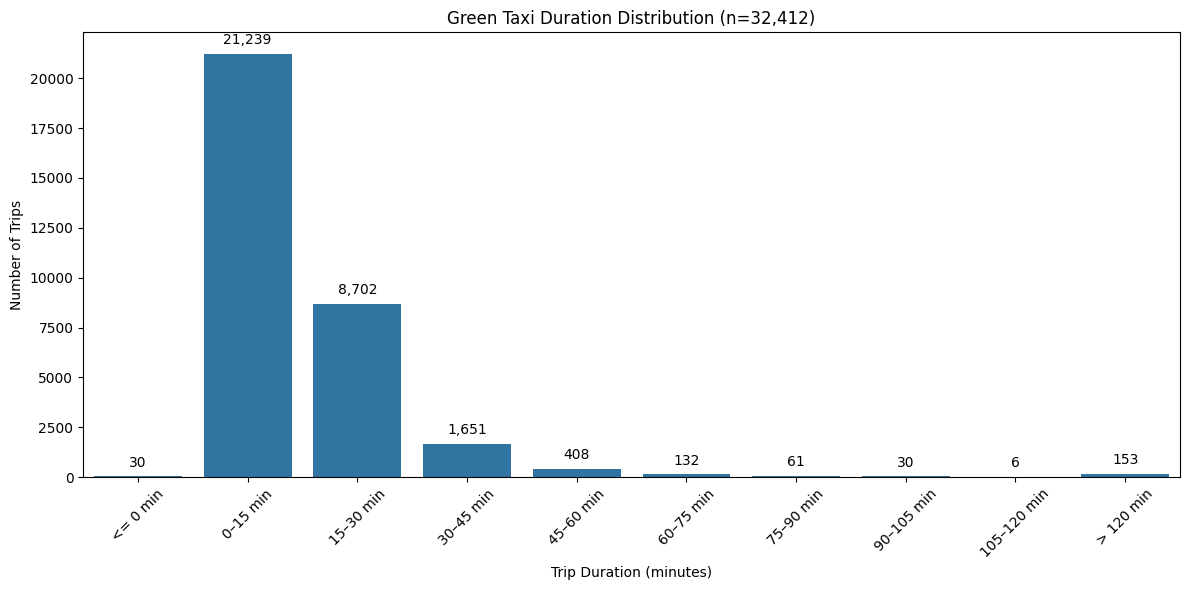

In [54]:
# green taxi
green_stats, green_dist, green_plot = analyze_taxi_durations(green, 'green')
green_plot.show()

# **feature engineering:**

## Average speed in mph**  
- A new feature, average_speed (in mph), is calculated using distance and duration. To prevent division-by-zero errors, the duration denominator is adjusted with a small constant. Trips with either zero distance or zero duration are handled safely

In [55]:
def add_average_speed_column(df, distance_col='trip_distance', duration_col='duration_inMin'):
    """
    Adds an 'average_speed' column in miles per hour to the DataFrame.
    Avoids division by zero and assigns 0 mph when distance or duration is zero.
    """
    df = df.copy()
    
    # Compute safe speed only where duration > 0 and distance > 0
    valid_mask = (df[duration_col] > 0) & (df[distance_col] > 0)

    # Create a new column with default 0, then assign speed where valid
    df['average_speed'] = 0.0
    df.loc[valid_mask, 'average_speed'] = (
        df.loc[valid_mask, distance_col] / (df.loc[valid_mask, duration_col] / 60)
    )

    return df


In [56]:
# for yellow
yellow = add_average_speed_column(yellow)
yellow['average_speed'].describe()

count    2.045625e+06
mean     1.934425e+01
std      2.769363e+03
min      0.000000e+00
25%      6.775777e+00
50%      9.228169e+00
75%      1.275949e+01
max      2.963097e+06
Name: average_speed, dtype: float64

In [57]:
# for green
green = add_average_speed_column(green)
green['average_speed'].describe()

count    3.241200e+04
mean     1.613161e+02
std      1.305003e+04
min      0.000000e+00
25%      8.032258e+00
50%      1.018537e+01
75%      1.331459e+01
max      1.754793e+06
Name: average_speed, dtype: float64

## time-based columns
-add time-based columns

In [58]:
def add_time_columns(df, df_name="dataframe", 
                    pickup_col='tpep_pickup_datetime', 
                    dropoff_col='tpep_dropoff_datetime'):
    """
    Enhanced function to add time-based columns with:
    - Automatic column name detection for yellow/green taxis
    - Hour, day of week, and month extraction
    - Data validation and reporting
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        df_name (str): Name of dataset ('yellow' or 'green')
        pickup_col (str): Name of pickup datetime column
        dropoff_col (str): Name of dropoff datetime column
        
    Returns:
        pd.DataFrame: DataFrame with added time columns
    """
    import pandas as pd
    
    # Create copy to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Validate columns exist
    missing_cols = [col for col in [pickup_col, dropoff_col] if col not in df.columns]
    if missing_cols:
        raise ValueError(f"{df_name} DataFrame missing columns: {missing_cols}")
    
    try:
        # Convert to datetime and extract features
        df[pickup_col] = pd.to_datetime(df[pickup_col], errors='coerce')
        df[dropoff_col] = pd.to_datetime(df[dropoff_col], errors='coerce')
        
        # Count nulls from conversion
        pickup_nulls = df[pickup_col].isna().sum()
        dropoff_nulls = df[dropoff_col].isna().sum()
        
        # Extract time features
        time_features = {
            'pickup_hour': df[pickup_col].dt.hour,
            'pickup_dayofweek': df[pickup_col].dt.dayofweek,
            'pickup_month': df[pickup_col].dt.month,
            'dropoff_hour': df[dropoff_col].dt.hour,
            'is_weekend': df[pickup_col].dt.dayofweek.isin([5, 6])
        }
        
        # Add features to DataFrame
        for col_name, feature in time_features.items():
            df[col_name] = feature
            
        # Report success
        print(f"Successfully added time columns to {df_name} data:")
        print(f"- Added columns: {list(time_features.keys())}")
        print(f"- Time range: {df[pickup_col].min()} to {df[pickup_col].max()}")
        if pickup_nulls > 0 or dropoff_nulls > 0:
            print(f"- Warning: {pickup_nulls} nulls in pickup times, {dropoff_nulls} nulls in dropoff times")
        
    except Exception as e:
        print(f"Error processing {df_name} data: {str(e)}")
        raise
        
    return df

In [59]:
# Usage for Yellow:
yellow = add_time_columns(yellow, 'yellow', 
                        pickup_col='tpep_pickup_datetime',
                        dropoff_col='tpep_dropoff_datetime')

Successfully added time columns to yellow data:
- Added columns: ['pickup_hour', 'pickup_dayofweek', 'pickup_month', 'dropoff_hour', 'is_weekend']
- Time range: 2002-12-31 23:09:40 to 2024-12-31 23:59:50


In [60]:
# Usage for green:

green = add_time_columns(green, 'green',
                       pickup_col='lpep_pickup_datetime',
                       dropoff_col='lpep_dropoff_datetime')

Successfully added time columns to green data:
- Added columns: ['pickup_hour', 'pickup_dayofweek', 'pickup_month', 'dropoff_hour', 'is_weekend']
- Time range: 2024-01-01 00:20:20 to 2025-01-01 12:28:53


## Median speed
-  Median speed per (PULocationID, Pickup Hour) — this lets you gauge what's "normal" in a place at a particular time of day.

In [61]:
def add_median_speed_transform(df,
                             groupby_columns=['PULocationID', 'pickup_hour'],
                             speed_col='average_speed',
                             new_col='median_speed'):
    """
    Computes median speed for each group and broadcasts to rows WITHOUT merging.
    More memory-efficient for large datasets.
    """
    import pandas as pd
    
    # Convert to numeric (keeps NAs)
    df[speed_col] = pd.to_numeric(df[speed_col], errors='coerce')
    
    # Calculate and broadcast medians
    df[new_col] = df.groupby(groupby_columns, observed=True)[speed_col].transform('median')
    
    return df


In [62]:
# Add median speed column to the yellow DataFrame
yellow = add_median_speed_transform(yellow, 
                                     groupby_columns=['PULocationID', 'pickup_hour'], 
                                     speed_col='average_speed', 
                                     new_col='median_speed')
# the median speed column
yellow['median_speed'].describe()

count    2.045625e+06
mean     1.007827e+01
std      2.326831e+01
min      0.000000e+00
25%      7.575452e+00
50%      8.885496e+00
75%      1.049276e+01
max      2.242197e+04
Name: median_speed, dtype: float64

In [63]:
# Add median speed column to the green DataFrame
green = add_median_speed_transform(green, 
                                     groupby_columns=['PULocationID', 'pickup_hour'], 
                                     speed_col='average_speed', 
                                     new_col='median_speed')
# the median speed column
green['median_speed'].describe()

count    3.241200e+04
mean     7.449716e+01
std      8.290132e+03
min      0.000000e+00
25%      9.185243e+00
50%      9.925234e+00
75%      1.143974e+01
max      1.346255e+06
Name: median_speed, dtype: float64

## Tagging Likely Traffic Congestion

To identify taxi trips likely affected by congestion, we introduced a function `tag_congestion()` that flags unusually slow trips using both relative and absolute speed rules:

- **Relative slowdown**: A trip is flagged if its average speed is less than 50% of the typical (median) speed for similar trips.
- **Absolute slowdown**: Trips slower than 5 mph are also flagged, regardless of the median.
- **Error filtering**: Trips with extremely high speeds (above 70 mph) are excluded to avoid data quality issues.

This logic helps detect congestion patterns without external traffic data, making it ideal for large-scale taxi analytics.


In [64]:
def tag_congestion(df, slow_ratio=0.5, absolute_slow=5, abs_fast=70):
    """
    Flag likely congestion events based on multiple criteria:
    1. Trip is significantly slower than location-time median (ratio rule).
    2. Or absolute speed is below congestion threshold.
    3. Disregard obviously erroneous cases (too fast).
    """
    df = df.copy()
    df['is_congestion'] = (
        (
            (df['average_speed'] < df['median_speed'] * slow_ratio) & 
            (df['average_speed'] >= absolute_slow)
        )
        | 
        (df['average_speed'] < absolute_slow)
    ) & (df['average_speed'] <= abs_fast)

    return df


In [65]:
# Tag congestion in the yellow DataFrame

yellow = tag_congestion(yellow, slow_ratio=0.5, absolute_slow=5, abs_fast=70)
# Count congestion events
yellow['is_congestion'].value_counts()

is_congestion
False    1817782
True      227843
Name: count, dtype: int64

In [66]:
# Tag congestion in the  green DataFrame

green = tag_congestion(green, slow_ratio=0.5, absolute_slow=5, abs_fast=70)
# Count congestion events
green['is_congestion'].value_counts()

is_congestion
False    30257
True      2155
Name: count, dtype: int64

## add_fare_efficiency_columns

- Fare per mile
- Fare per minute


This function calculates two efficiency metrics: fare per mile and fare per minute, helping identify overpriced short trips or inefficient long-duration rides. It safely handles zero or missing values and adds the results as new columns to the dataset.


In [67]:
def add_fare_efficiency_columns(
    df,
    fare_col='fare_amount',
    distance_col='trip_distance',
    duration_col='duration_inMin'
):
    """
    Adds 'fare_per_mile' and (if duration column exists) 'fare_per_minute' to the DataFrame.
    Ensures safe division (avoids divide-by-zero and negative values).
    """
    df = df.copy()

    # Fare per mile
    valid_distance_mask = df[distance_col] > 0
    df['fare_per_mile'] = 0.0
    df.loc[valid_distance_mask, 'fare_per_mile'] = (
        df.loc[valid_distance_mask, fare_col] / df.loc[valid_distance_mask, distance_col]
    )

    # Fare per minute — only if duration column exists
    if duration_col in df.columns:
        valid_duration_mask = df[duration_col] > 0
        df['fare_per_minute'] = 0.0
        df.loc[valid_duration_mask, 'fare_per_minute'] = (
            df.loc[valid_duration_mask, fare_col] / df.loc[valid_duration_mask, duration_col]
        )
    else:
        print(f"⚠️ Column '{duration_col}' not found — skipping fare_per_minute.")

    return df


In [68]:
yellow = add_fare_efficiency_columns(yellow,fare_col='fare_amount',
                                     distance_col='trip_distance',
                                     duration_col='duration_inMin')


In [69]:
green = add_fare_efficiency_columns(green,fare_col='fare_amount',
                                     distance_col='trip_distance',
                                     duration_col='duration_inMin')

# Sanitize_taxi_data: as a final security check 

- Ensures high-quality NYC taxi data by correcting negative charges and removing unrealistic records based on predefined thresholds, enabling accurate and reliable model training.

sanitize_taxi_data : Business Rules and Justification
To ensure the quality and reliability of NYC Yellow Taxi data, this cleaning function applies a series of threshold-based filters to remove records with extreme or suspicious values. These thresholds are grounded in business logic and real-world operational expectations for urban taxi behavior. The cleaning steps serve two primary purposes:

Remove unrealistic or erroneous records (e.g., 0-minute trips, negative total fares, trips faster than highway speeds).

Retain the majority of valid trips while excluding only the top 1% of outliers for certain features, based on the 99th percentile.

✂️ Cleaning Rules Applied:
Trip Duration (duration_inMin): Must be at least 0.1 minutes and below the 99th percentile.

Trip Distance (trip_distance): Must be positive and below the 99th percentile to exclude mileage errors.

Fare Amount (fare_amount): Must be at least $1.00 (to avoid missing or incorrect fares) and below the 99th percentile.

Total Amount (total_amount): Must be non-negative; negative charges are not allowed per TLC rules.

Average Speed (average_speed): Trips with average speeds exceeding 70 mph are flagged as implausible for city driving and removed.

In [70]:
def sanitize_taxi_data_with_report(
    df, 
    df_name="data", 
    report_dir="cleaned_data",
    pickup_col="pickup_datetime"
):
    """
    Cleans NYC taxi data with full reporting:
    1. Fixes negative 'extra' charges.
    2. Drops trips before 2024.
    3. Removes extreme or invalid values in key columns.
    4. Prints detailed report and saves audit files.

    Parameters:
        df (pd.DataFrame): Taxi data input.
        df_name (str): Name used in reports and file exports.
        report_dir (str): Directory to store audit CSV files.
        pickup_col (str): Name of pickup datetime column.

    Returns:
        pd.DataFrame: Cleaned DataFrame.
    """
    df = df.copy()
    os.makedirs(report_dir, exist_ok=True)

    print(f"\n{'='*80}")
    print(f"🧹 Cleaning Report for: {df_name}")

    ### Step 1: Fix negative 'extra'
    if 'extra' in df.columns:
        neg_mask = df['extra'] < 0
        if neg_mask.any():
            fix_path = os.path.join(report_dir, f"{df_name}_negative_extra_corrections.csv")
            df[neg_mask].to_csv(fix_path, index=False)
            df.loc[neg_mask, 'extra'] = df.loc[neg_mask, 'extra'].abs()
            print(f"✔️ Fixed {neg_mask.sum():,} negative 'extra' values → Saved to: {fix_path}")

    ### Step 2: Drop records before 2024
    if pickup_col in df.columns:
        df[pickup_col] = pd.to_datetime(df[pickup_col], errors='coerce')
        date_mask = df[pickup_col] < pd.Timestamp("2024-01-01")
        if date_mask.any():
            drop_path = os.path.join(report_dir, f"{df_name}_dropped_before_2024.csv")
            df[date_mask].to_csv(drop_path, index=False)
            print(f"🗑️ Dropped {date_mask.sum():,} rows before 2024 → Saved to: {drop_path}")
            df = df[~date_mask]

    ### Step 3: Create thresholds
    thresholds = {
        'duration_inMin': {'min': 0.1, 'max': df['duration_inMin'].quantile(0.99)},
        'trip_distance': {'min': 0.01, 'max': df['trip_distance'].quantile(0.99)},
        'fare_amount': {'min': 1.0, 'max': df['fare_amount'].quantile(0.99)},
        'total_amount': {'min': 0.0},
        'average_speed': {'max': 70.0}
    }

    ### Step 4: Apply validation mask
    valid_mask = (
        (df['duration_inMin'] >= thresholds['duration_inMin']['min']) &
        (df['duration_inMin'] <= thresholds['duration_inMin']['max']) &
        (df['trip_distance'] >= thresholds['trip_distance']['min']) &
        (df['trip_distance'] <= thresholds['trip_distance']['max']) &
        (df['fare_amount'] >= thresholds['fare_amount']['min']) &
        (df['fare_amount'] <= thresholds['fare_amount']['max']) &
        (df['total_amount'] >= thresholds['total_amount']['min']) &
        (df['average_speed'] <= thresholds['average_speed']['max'])
    )

    ### Step 5: Split valid and invalid
    valid_df = df[valid_mask].copy()
    invalid_df = df[~valid_mask].copy()

    ### Step 6: Report
    total = len(df)
    dropped = len(invalid_df)
    print(f"\n=== RESULTS ===")
    print(f"Total rows: {total:,}")
    print(f"Rows dropped: {dropped:,} ({dropped/total:.2%})")
    print(f"Remaining valid rows: {len(valid_df):,}")

    ### Step 7: Save dropped records
    if dropped > 0:
        drop_path = os.path.join(report_dir, f"{df_name}_dropped_extreme_values.csv")
        invalid_df.to_csv(drop_path, index=False)
        print(f"🗃️ Dropped rows saved to: {drop_path}")

    return valid_df


In [71]:
yellow = sanitize_taxi_data_with_report(
    yellow, 
    df_name="yellow", 
    report_dir="cleaned_data", 
    pickup_col="tpep_pickup_datetime"
)




🧹 Cleaning Report for: yellow
✔️ Fixed 40 negative 'extra' values → Saved to: cleaned_data\yellow_negative_extra_corrections.csv
🗑️ Dropped 2 rows before 2024 → Saved to: cleaned_data\yellow_dropped_before_2024.csv

=== RESULTS ===
Total rows: 2,045,623
Rows dropped: 66,338 (3.24%)
Remaining valid rows: 1,979,285
🗃️ Dropped rows saved to: cleaned_data\yellow_dropped_extreme_values.csv


In [72]:
green = sanitize_taxi_data_with_report(
    green, 
    df_name="green", 
    report_dir="cleaned_data", 
    pickup_col="lpep_pickup_datetime"
)



🧹 Cleaning Report for: green

=== RESULTS ===
Total rows: 32,412
Rows dropped: 1,543 (4.76%)
Remaining valid rows: 30,869
🗃️ Dropped rows saved to: cleaned_data\green_dropped_extreme_values.csv


# detect negative values

In [73]:
target_columns = [
    'trip_distance', 'fare_amount', 'extra',
    'tip_amount', 'tolls_amount', 'total_amount',
    'duration_inMin', 'average_speed', 'median_speed'
]

def check_negative_values(df, target_columns, df_name=''):
    print(f"\n🔍 Checking negative values in {df_name} DataFrame:")
    for col in target_columns:
        if col in df.columns:
            num_neg = (df[col] < 0).sum()
            if num_neg > 0:
                print(f"❌ {col}: {num_neg} negative values")
            else:
                print(f"✅ {col}: No negative values")
        else:
            print(f"⚠️  {col}: Column not found in DataFrame")

# Example usage:
check_negative_values(yellow, target_columns, df_name='yellow')
check_negative_values(green, target_columns, df_name='green')



🔍 Checking negative values in yellow DataFrame:
✅ trip_distance: No negative values
✅ fare_amount: No negative values
✅ extra: No negative values
✅ tip_amount: No negative values
✅ tolls_amount: No negative values
✅ total_amount: No negative values
✅ duration_inMin: No negative values
✅ average_speed: No negative values
✅ median_speed: No negative values

🔍 Checking negative values in green DataFrame:
✅ trip_distance: No negative values
✅ fare_amount: No negative values
✅ extra: No negative values
✅ tip_amount: No negative values
✅ tolls_amount: No negative values
✅ total_amount: No negative values
✅ duration_inMin: No negative values
✅ average_speed: No negative values
✅ median_speed: No negative values


In [74]:
######    for analysis

# borough_speed for yellow
borough_speed_yellow = yellow.groupby('PU_Borough')['median_speed'].describe().reset_index()
borough_speed_yellow = borough_speed_yellow.rename(columns={
    '50%': 'median_speed',
    'count': 'trip_count',
    'mean': 'mean_speed',
    'std': 'std_speed',
    'min': 'min_speed',
    'max': 'max_speed'
})

borough_speed_yellow.value_counts()

PU_Borough     trip_count  mean_speed  std_speed  min_speed  25%        median_speed  75%        max_speed   
Bronx          5246.0      12.689656   4.325579   0.00000    9.895877   11.718195     14.114671  37.596398       1
Brooklyn       26806.0     10.915783   3.135916   0.00000    8.551601   10.374871     12.600425  120.474017      1
EWR            23.0        0.000000    0.000000   0.00000    0.000000   0.000000      0.000000   0.000000        1
Manhattan      1783275.0   8.909521    1.909744   0.00000    7.454545   8.593155      9.932072   155.866089      1
Outside NYC    310.0       4.214519    5.017740   0.00000    0.000000   0.079646      8.553086   16.802250       1
Queens         158038.0    21.047111   56.636995  0.00000    17.025325  19.602094     25.582418  22421.969675    1
Staten Island  50.0        22.494887   8.109667   4.16819    17.960612  23.010104     27.281476  38.907692       1
Undefined      5537.0      9.658453    1.672872   8.11709    8.470588   8.780488     

In [75]:
# borough_speed for green
borough_speed_green = green.groupby('PU_Borough')['median_speed'].describe().reset_index()
borough_speed_green = borough_speed_green.rename(columns={
    '50%': 'median_speed',
    'count': 'trip_count',
    'mean': 'mean_speed',
    'std': 'std_speed',
    # 'min': 'min_speed',
    'max': 'max_speed'
})

borough_speed_green.value_counts()

PU_Borough   trip_count  mean_speed  std_speed    min       25%       median_speed  75%        max_speed  
Bronx        313.0       12.750512   5.759167     2.755906  8.797298  11.588523     14.580354  39.556326      1
Brooklyn     4048.0      10.175169   3.614466     0.088889  7.774445  9.317944      11.706889  58.500000      1
Manhattan    19068.0     10.402259   1.937996     0.200000  9.211681  9.885057      10.950000  38.980289      1
Outside NYC  5.0         527.613330  1159.361341  0.000000  9.641161  11.349754     15.558839  2601.516896    1
Queens       7421.0      11.454500   7.018610     0.000000  9.552000  10.520407     11.925000  484.500000     1
Undefined    13.0        6.338557    4.593817     0.000000  1.697385  6.733467      10.503119  10.782030      1
Name: count, dtype: int64

In [76]:
print(yellow.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'pickup_date',
       'PU_Borough', 'PU_Zone', 'PU_ServiceZone', 'DO_Borough', 'DO_Zone',
       'DO_ServiceZone', 'duration_inMin', 'average_speed', 'pickup_hour',
       'pickup_dayofweek', 'pickup_month', 'dropoff_hour', 'is_weekend',
       'median_speed', 'is_congestion', 'fare_per_mile', 'fare_per_minute'],
      dtype='object')


In [77]:
print(green.columns)

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'payment_type', 'trip_type', 'congestion_surcharge', 'pickup_date',
       'PU_Borough', 'PU_Zone', 'PU_ServiceZone', 'DO_Borough', 'DO_Zone',
       'DO_ServiceZone', 'duration_inMin', 'average_speed', 'pickup_hour',
       'pickup_dayofweek', 'pickup_month', 'dropoff_hour', 'is_weekend',
       'median_speed', 'is_congestion', 'fare_per_mile', 'fare_per_minute'],
      dtype='object')


# Analysis_ready

In [78]:
def save_analysis_ready_csv(df, df_name, folder="analysis_ready"):
    """
    Saves a DataFrame to CSV with a standardized name and directory:
        {folder}/{df_name}_analysis_ready.csv

    Parameters:
    - df (pd.DataFrame): DataFrame to save
    - df_name (str): Short identifier (e.g. 'yellow', 'green')
    - folder (str): Target folder to save the file (default: 'analysis_ready')

    Returns:
    - pd.DataFrame: The same DataFrame, unchanged
    """
    import os

    # Ensure the output folder exists
    os.makedirs(folder, exist_ok=True)

    # Build the full path
    filename = f"{df_name}_analysis_ready.csv"
    filepath = os.path.join(folder, filename)

    # Save the DataFrame
    df.to_csv(filepath, index=False)

    # Return df for chaining or further use
    return df


#usage
yellow = save_analysis_ready_csv(yellow, "yellow")
green = save_analysis_ready_csv(green, "green")

# **outlier detection**


In [79]:
def check_column_dtypes(df, target_columns, df_name=''):
    print(f"\nData types in: {df_name}")
    for col in target_columns:
        if col in df.columns:
            print(f"{col:<25}: {df[col].dtype}")
        else:
            print(f"{col:<25}: [Missing]")

# Define your target columns
target_columns = [
    'trip_distance','passenger_count','fare_amount', 'extra','mta_tax',
    'tip_amount', 'tolls_amount', 'improvement_surcharge','total_amount',
    'congestion_surcharge', 'Airport_fee','duration_inMin',
    'average_speed','median_speed'
]

# Check for both DataFrames
check_column_dtypes(yellow, target_columns, df_name="Yellow Taxi")
check_column_dtypes(green, target_columns, df_name="Green Taxi")



Data types in: Yellow Taxi
trip_distance            : float64
passenger_count          : float64
fare_amount              : float64
extra                    : float64
mta_tax                  : float64
tip_amount               : float64
tolls_amount             : float64
improvement_surcharge    : float64
total_amount             : float64
congestion_surcharge     : float64
Airport_fee              : float64
duration_inMin           : float64
average_speed            : float64
median_speed             : float64

Data types in: Green Taxi
trip_distance            : float64
passenger_count          : float64
fare_amount              : float64
extra                    : float64
mta_tax                  : float64
tip_amount               : float64
tolls_amount             : float64
improvement_surcharge    : float64
total_amount             : float64
congestion_surcharge     : float64
Airport_fee              : [Missing]
duration_inMin           : float64
average_speed            : float6

In [80]:
def show_value_counts(df, columns):
    """
    Displays value counts for specified columns if they exist in the DataFrame.
    """
    for col in columns:
        if col in df.columns:
            print(f"\n--- {col} ---")
            print(df[col].value_counts(dropna=False))
        else:
            print(f"\n[Skipped] Column '{col}' not found in DataFrame.")
            
columns_to_check = [
    'extra', 'mta_tax', 'tolls_amount',
    'improvement_surcharge', 'congestion_surcharge', 'Airport_fee'
]

# For yellow taxi
print("YELLOW TAXI:")
show_value_counts(yellow, columns_to_check)

# For green taxi
print("\nGREEN TAXI:")
show_value_counts(green, columns_to_check)


YELLOW TAXI:

--- extra ---
extra
0.00     890854
2.50     448734
1.00     362683
5.00     123302
3.50      97208
6.00      16084
7.50      15027
9.25       7249
4.25       4539
6.75       2658
1.75       2576
10.25      2191
2.75       1881
7.75       1648
11.75      1536
10.00       502
8.50        383
2.00        108
3.20         22
3.00         11
0.02         10
5.25         10
0.50          8
3.05          6
2.72          5
9.95          5
1.50          4
0.75          4
14.25         3
1.97          3
5.75          3
0.70          2
7.00          2
0.01          2
1.01          2
12.50         2
1.02          2
1.03          2
2.25          2
7.25          2
0.79          2
0.08          1
0.80          1
0.07          1
9.47          1
0.25          1
0.77          1
1.04          1
0.09          1
Name: count, dtype: int64

--- mta_tax ---
mta_tax
 0.5    1972644
 0.0       6625
 1.0         10
 4.0          4
-0.5          2
Name: count, dtype: int64

--- tolls_amount ---
tol

In [81]:
def detect_iqr_outliers(df, iqr_multiplier=1.5, return_removed=False):
    """
    Detects outliers using the IQR method on predefined numeric columns.
    
    Parameters:
    - df (pd.DataFrame): Input DataFrame
    - iqr_multiplier (float): The IQR multiplier (default = 1.5)
    - return_removed (bool): If True, removes rows with outliers; else returns full df
    
    Returns:
    - pd.DataFrame: DataFrame with or without outliers
    - list: Columns where outliers were detected
    """
    import pandas as pd

    df = df.copy()

    # Your predefined columns
    target_columns = [
        'trip_distance','fare_amount', 'extra',
        'tip_amount', 'tolls_amount','total_amount','duration_inMin',
        'average_speed','median_speed','fare_per_mile', 'fare_per_minute'
    ]

    outlier_columns = []
    mask = pd.Series([False] * len(df), index=df.index)

    for col in target_columns:
        if col not in df.columns:
            continue  # Skip missing columns

        if df[col].nunique() <= 1:
            continue  # Skip constant columns

        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - iqr_multiplier * iqr
        upper = q3 + iqr_multiplier * iqr

        col_mask = (df[col] < lower) | (df[col] > upper)

        if col_mask.any():
            outlier_columns.append(col)
            mask = mask | col_mask

    if return_removed:
        df = df[~mask]

    return df, outlier_columns

# usage
yellow, outlier_cols_yellow = detect_iqr_outliers(yellow, return_removed=False)
green, outlier_cols_green = detect_iqr_outliers(green, return_removed=False)



In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_outlier_columns(df, outlier_columns, df_name="Dataset"):
    """
    Plots box plots for the given outlier columns in the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame
    - outlier_columns (list): Columns flagged with outliers
    - df_name (str): Optional name of the dataset for plot titles
    """
    num_cols = len(outlier_columns)
    if num_cols == 0:
        print("No outlier columns to plot.")
        return

    # Set plot layout
    ncols = 3
    nrows = (num_cols + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
    axes = axes.flatten()

    for i, col in enumerate(outlier_columns):
        if col in df.columns:
            sns.boxplot(y=df[col], ax=axes[i], color='skyblue')
            axes[i].set_title(f"{df_name} - {col}")
            axes[i].set_xlabel('')
        else:
            axes[i].set_visible(False)

    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()



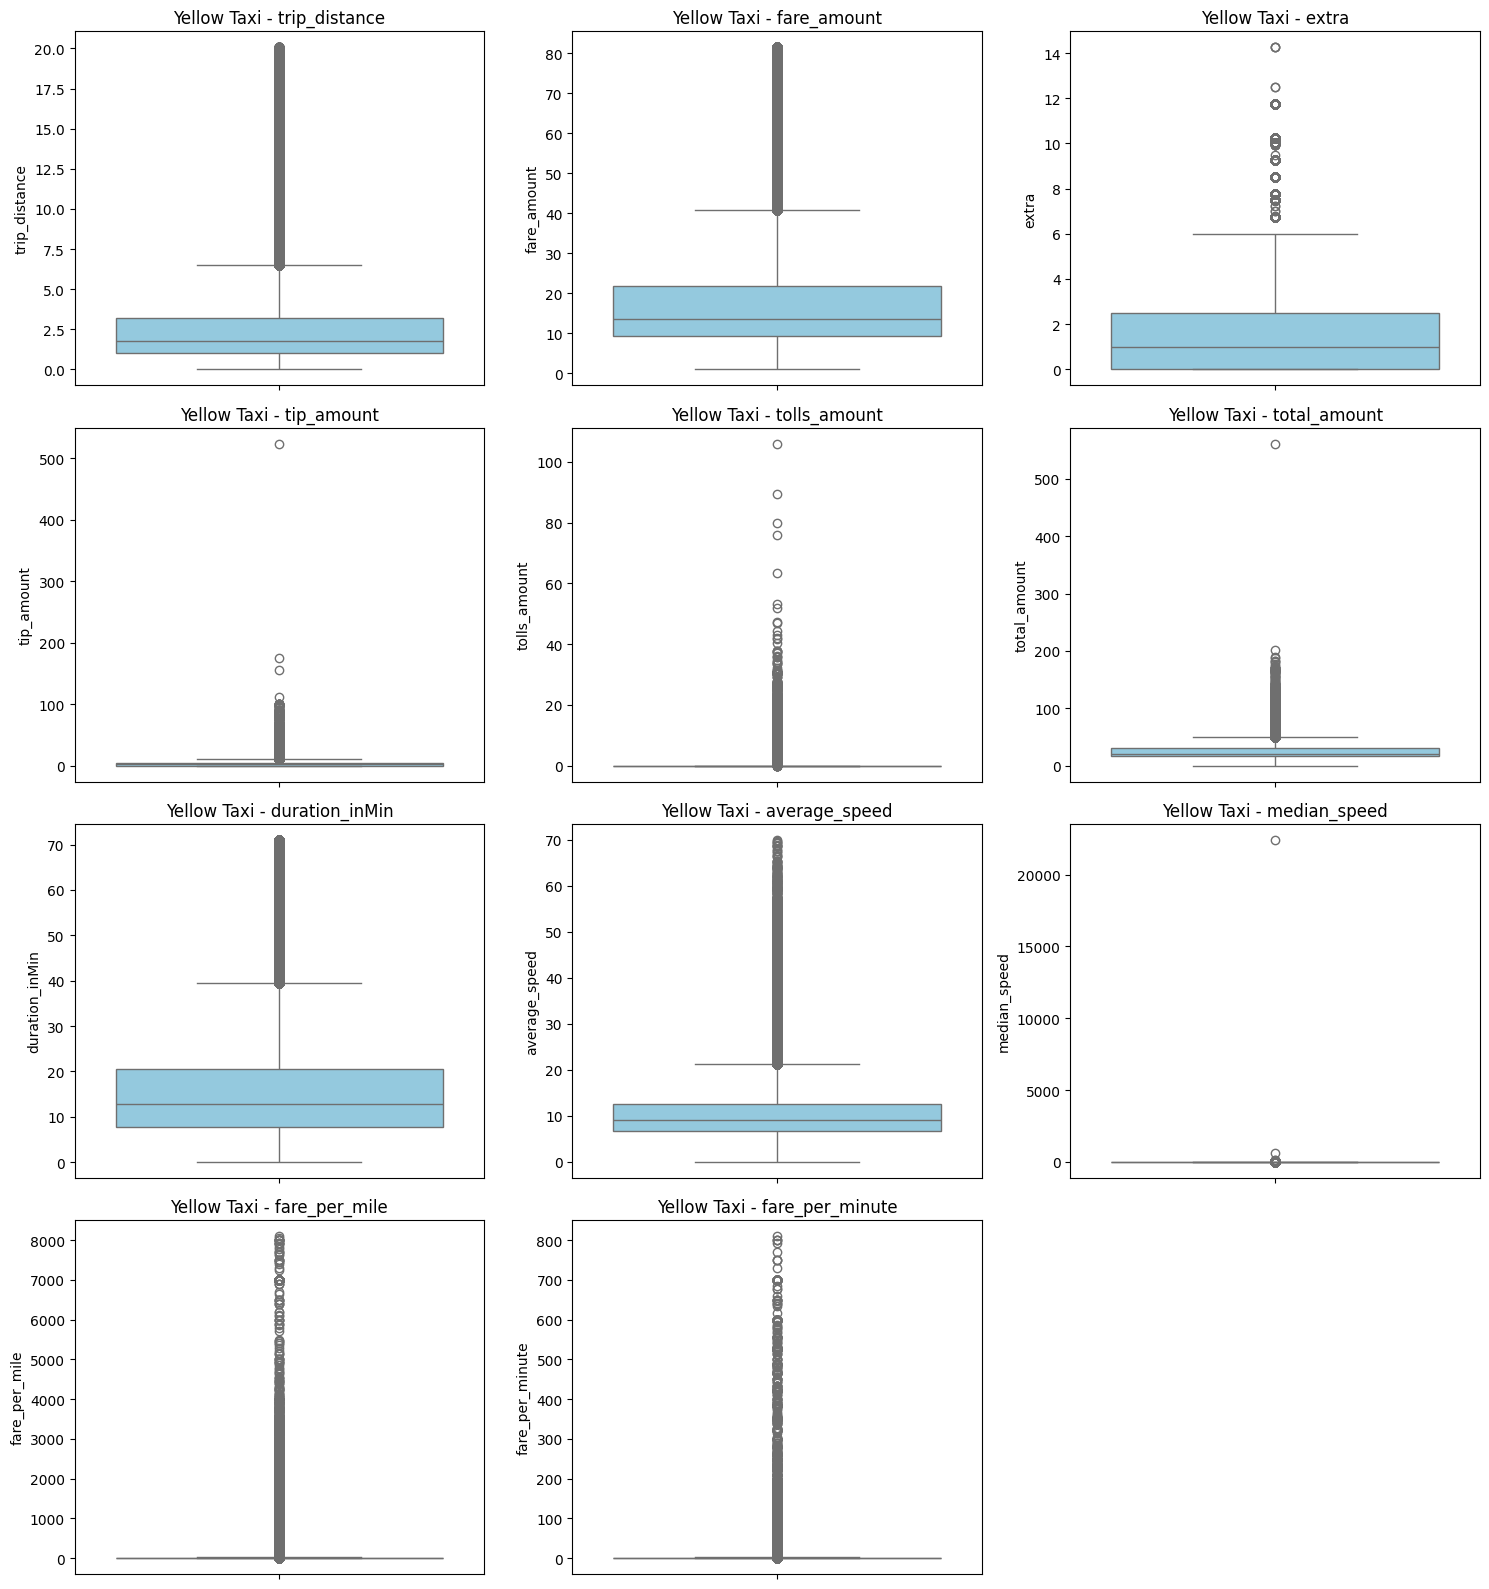

In [83]:
# plot for yellow

plot_outlier_columns(yellow, outlier_cols_yellow, df_name="Yellow Taxi")

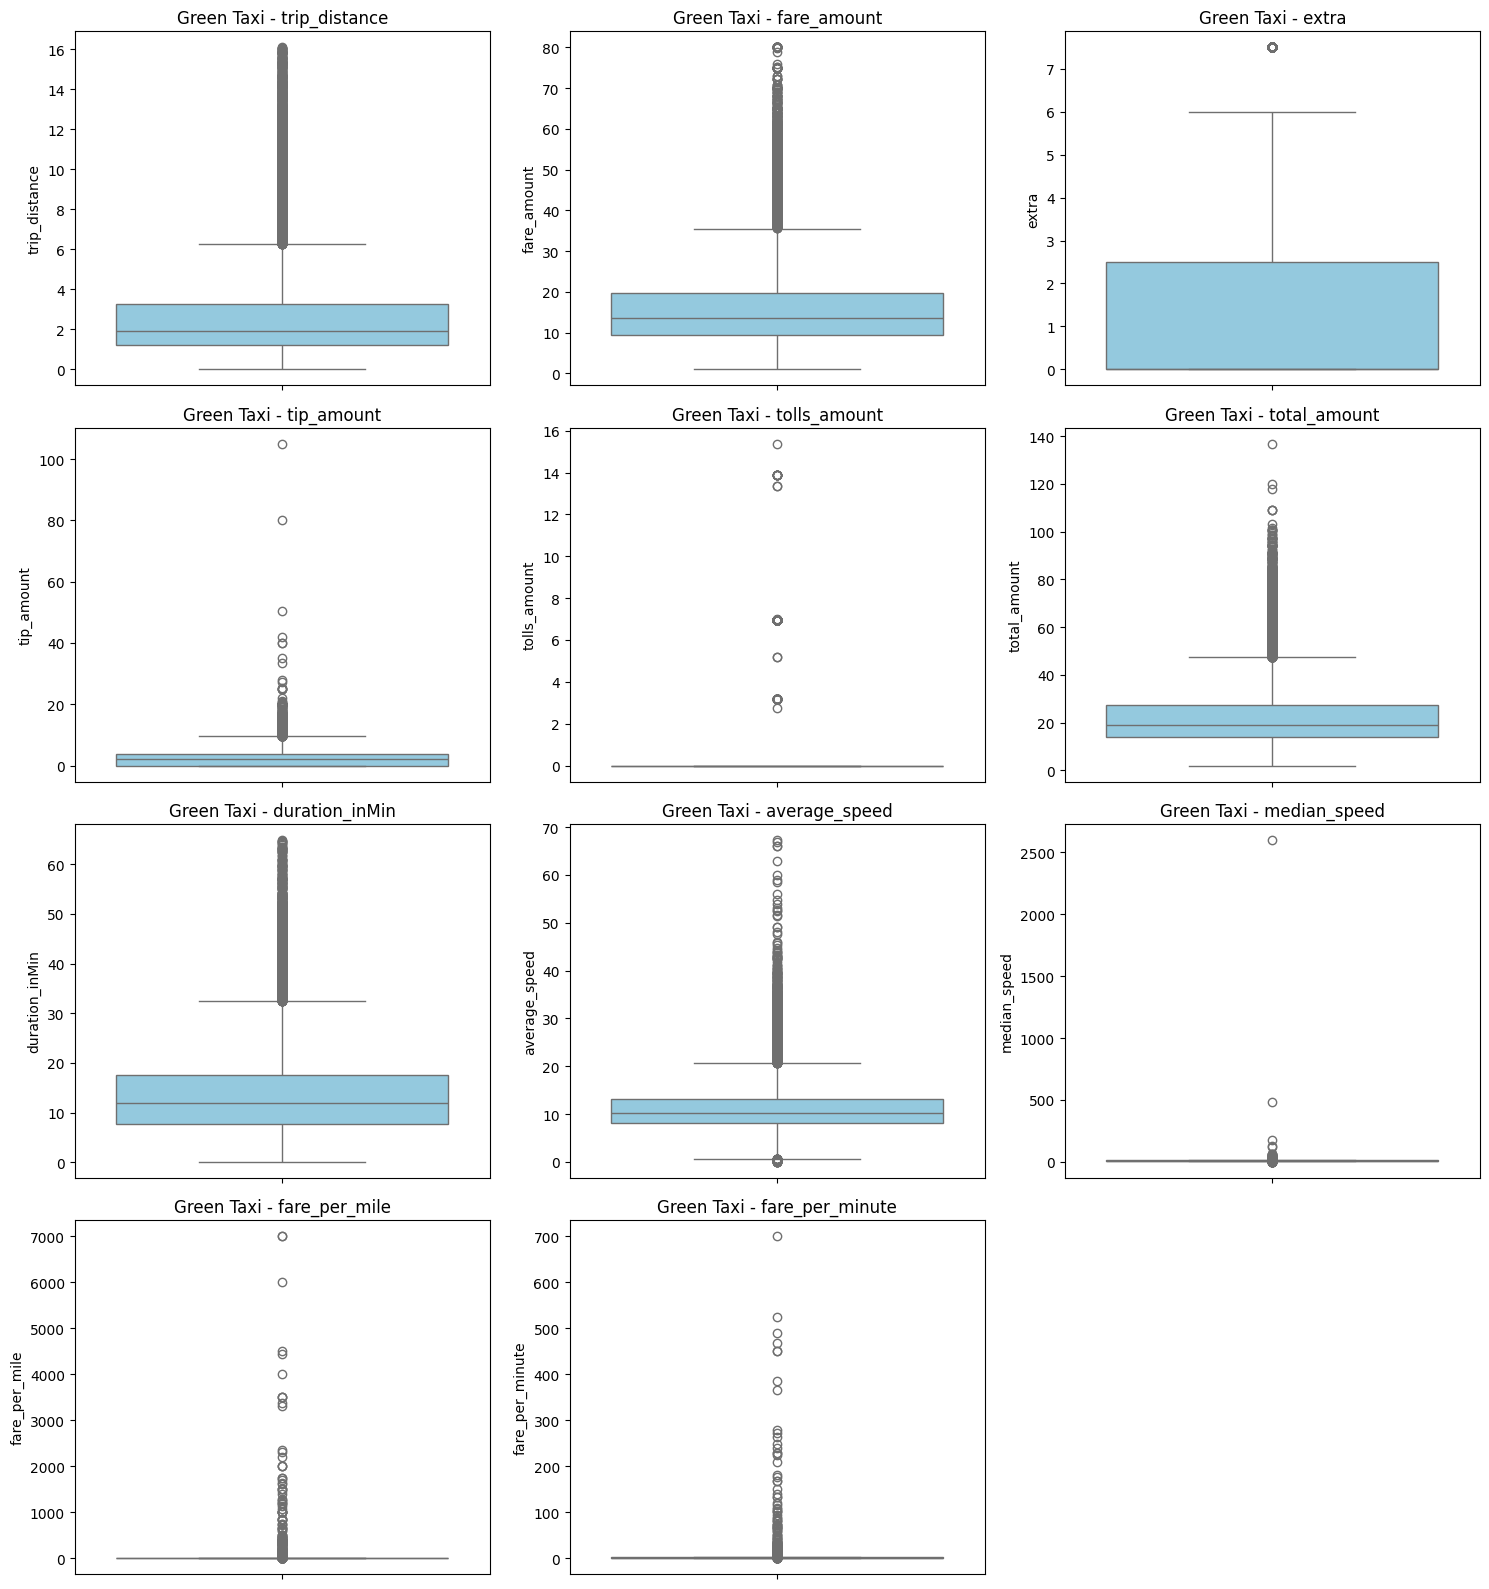

In [84]:
# plot for green
plot_outlier_columns(green, outlier_cols_green, df_name="Green Taxi")

In [85]:

outlier_cols_yellow

['trip_distance',
 'fare_amount',
 'extra',
 'tip_amount',
 'tolls_amount',
 'total_amount',
 'duration_inMin',
 'average_speed',
 'median_speed',
 'fare_per_mile',
 'fare_per_minute']

In [86]:


def transform_outlier_columns_log(df, outlier_columns, df_name):
    """
    Applies log(x + 1) transformation to outlier columns (if numeric),
    and saves the result to 'analysis_ready/{df_name}_ready_ml.csv'.

    Parameters:
    - df (pd.DataFrame): Input DataFrame
    - outlier_columns (list): Columns to transform
    - df_name (str): Name to use in output filename (e.g., 'yellow', 'green')

    Returns:
    - pd.DataFrame: Transformed DataFrame
    """
    df = df.copy()
    transformed_cols = []

    for col in outlier_columns:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            df[col] = np.log1p(df[col])  # log(x + 1)
            transformed_cols.append(col)

    # Ensure directory exists
    output_dir = "analysis_ready"
    os.makedirs(output_dir, exist_ok=True)

    # Build filename
    filename = f"{df_name}_ready_ml.csv"
    path = os.path.join(output_dir, filename)

    df.to_csv(path, index=False)
    print(f"✅ Transformed {len(transformed_cols)} column(s) using log(x + 1) and saved to '{path}'.")

    return df


In [87]:
yellow_transformed = transform_outlier_columns_log(yellow, outlier_cols_yellow, df_name='yellow')
green_transformed = transform_outlier_columns_log(green, outlier_cols_green, df_name='green')


✅ Transformed 11 column(s) using log(x + 1) and saved to 'analysis_ready\yellow_ready_ml.csv'.
✅ Transformed 11 column(s) using log(x + 1) and saved to 'analysis_ready\green_ready_ml.csv'.


In [88]:
yellow_transformed.head()


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
2         1  2024-01-01 12:06:50   2024-01-01 12:10:49              1.0   
3         2  2024-01-01 00:46:22   2024-01-01 01:04:58              3.0   
4         2  2024-01-01 14:41:48   2024-01-01 15:04:38              2.0   
5         1  2024-01-01 03:28:42   2024-01-01 03:36:20              1.0   
6         1  2024-01-01 02:15:43   2024-01-01 02:52:05              2.0   

   trip_distance  RatecodeID store_and_fwd_flag PULocationID DOLocationID  \
2       0.955511        99.0                  N          230           43   
3       0.810930         1.0                  N          164          229   
4       1.327075         1.0                  N           43          164   
5       0.336472         1.0                  N          186          100   
6       2.151762         1.0                  N           48          255   

   payment_type  fare_amount     extra  mta_tax  tip_amount  tolls_amount  \
2             0     2.577182  0.000000      0.5    0.000000           0.0   
3             1     2.850707  0.693147      0.5    1.660131           0.0   
4             2     3.100092  0.000000      0.5    0.000000           0.0   
5             1     2.104134  1.504077      0.5    0.000000           0.0   
6             1     3.732896  1.504077      0.5    3.044522           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  Airport_fee  \
2                    1.0      2.842581                   2.5          0.0   
3                    1.0      3.279406                   2.5          0.0   
4                    1.0      3.265759                   2.5          0.0   
5                    1.0      2.580217                   2.5          0.0   
6                    1.0      4.201703                   2.5          0.0   

  pickup_date PU_Borough                       PU_Zone PU_ServiceZone  \
2  2024-01-01  Manhattan     Times Sq/Theatre District    Yellow Zone   
3  2024-01-01  Manhattan                 Midtown South    Yellow Zone   
4  2024-01-01  Manhattan                  Central Park    Yellow Zone   
5  2024-01-01  Manhattan  Penn Station/Madison Sq West    Yellow Zone   
6  2024-01-01  Manhattan                  Clinton East    Yellow Zone   

  DO_Borough                        DO_Zone DO_ServiceZone  duration_inMin  \
2  Manhattan                   Central Park    Yellow Zone        1.606099   
3  Manhattan  Sutton Place/Turtle Bay North    Yellow Zone        2.975530   
4  Manhattan                  Midtown South    Yellow Zone        3.171085   
5  Manhattan               Garment District    Yellow Zone        2.155631   
6   Brooklyn      Williamsburg (North Side)      Boro Zone        3.620779   

   average_speed  pickup_hour  pickup_dayofweek  pickup_month  dropoff_hour  \
2       3.222885           12                 0             1            12   
3       1.615869            0                 0             1             1   
4       2.113702           14                 0             1            15   
5       1.421687            3                 0             1             3   
6       2.605571            2                 0             1             2   

   is_weekend  median_speed  is_congestion  fare_per_mile  fare_per_minute  
2       False      2.132367          False       2.151762         1.399388  
3       False      2.465489           True       2.641910         0.629325  
4       False      2.182831          False       2.157956         0.656725  
5       False      2.677125           True       2.944439         0.664352  
6       False      2.669392          False       1.851352         0.752315

In [89]:
yellow.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
2         1  2024-01-01 12:06:50   2024-01-01 12:10:49              1.0   
3         2  2024-01-01 00:46:22   2024-01-01 01:04:58              3.0   
4         2  2024-01-01 14:41:48   2024-01-01 15:04:38              2.0   
5         1  2024-01-01 03:28:42   2024-01-01 03:36:20              1.0   
6         1  2024-01-01 02:15:43   2024-01-01 02:52:05              2.0   

   trip_distance  RatecodeID store_and_fwd_flag PULocationID DOLocationID  \
2           1.60        99.0                  N          230           43   
3           1.25         1.0                  N          164          229   
4           2.77         1.0                  N           43          164   
5           0.40         1.0                  N          186          100   
6           7.60         1.0                  N           48          255   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
2             0        12.16    0.0      0.5        0.00           0.0   
3             1        16.30    1.0      0.5        4.26           0.0   
4             2        21.20    0.0      0.5        0.00           0.0   
5             1         7.20    3.5      0.5        0.00           0.0   
6             1        40.80    3.5      0.5       20.00           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  Airport_fee  \
2                    1.0         16.16                   2.5          0.0   
3                    1.0         25.56                   2.5          0.0   
4                    1.0         25.20                   2.5          0.0   
5                    1.0         12.20                   2.5          0.0   
6                    1.0         65.80                   2.5          0.0   

  pickup_date PU_Borough                       PU_Zone PU_ServiceZone  \
2  2024-01-01  Manhattan     Times Sq/Theatre District    Yellow Zone   
3  2024-01-01  Manhattan                 Midtown South    Yellow Zone   
4  2024-01-01  Manhattan                  Central Park    Yellow Zone   
5  2024-01-01  Manhattan  Penn Station/Madison Sq West    Yellow Zone   
6  2024-01-01  Manhattan                  Clinton East    Yellow Zone   

  DO_Borough                        DO_Zone DO_ServiceZone  duration_inMin  \
2  Manhattan                   Central Park    Yellow Zone        3.983333   
3  Manhattan  Sutton Place/Turtle Bay North    Yellow Zone       18.600000   
4  Manhattan                  Midtown South    Yellow Zone       22.833333   
5  Manhattan               Garment District    Yellow Zone        7.633333   
6   Brooklyn      Williamsburg (North Side)      Boro Zone       36.366667   

   average_speed  pickup_hour  pickup_dayofweek  pickup_month  dropoff_hour  \
2      24.100418           12                 0             1            12   
3       4.032258            0                 0             1             1   
4       7.278832           14                 0             1            15   
5       3.144105            3                 0             1             3   
6      12.538955            2                 0             1             2   

   is_weekend  median_speed  is_congestion  fare_per_mile  fare_per_minute  
2       False      7.434810          False       7.600000         3.052720  
3       False     10.769231           True      13.040000         0.876344  
4       False      7.871383          False       7.653430         0.928467  
5       False     13.543225           True      18.000000         0.943231  
6       False     13.431193          False       5.368421         1.121907

# Analysis

In [90]:
yellow.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'pickup_date',
       'PU_Borough', 'PU_Zone', 'PU_ServiceZone', 'DO_Borough', 'DO_Zone',
       'DO_ServiceZone', 'duration_inMin', 'average_speed', 'pickup_hour',
       'pickup_dayofweek', 'pickup_month', 'dropoff_hour', 'is_weekend',
       'median_speed', 'is_congestion', 'fare_per_mile', 'fare_per_minute'],
      dtype='object')

In [91]:
green.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'payment_type', 'trip_type', 'congestion_surcharge', 'pickup_date',
       'PU_Borough', 'PU_Zone', 'PU_ServiceZone', 'DO_Borough', 'DO_Zone',
       'DO_ServiceZone', 'duration_inMin', 'average_speed', 'pickup_hour',
       'pickup_dayofweek', 'pickup_month', 'dropoff_hour', 'is_weekend',
       'median_speed', 'is_congestion', 'fare_per_mile', 'fare_per_minute'],
      dtype='object')

In [92]:
def summarize_key_metrics(df):
    """
    Returns a dictionary of selected summary metrics:
    - Average fare per mile
    - Average duration (in minutes)
    - Average trip distance
    - Max trip distance
    - Max total amount

    Parameters:
        df (pd.DataFrame): DataFrame with taxi trip data

    Returns:
        pd.DataFrame: Summary metrics as a single-row DataFrame
    """
    metrics = {
        'avg_fare_per_mile': df['fare_per_mile'].mean(),
        'avg_duration_inMin': df['duration_inMin'].mean(),
        'avg_trip_distance': df['trip_distance'].mean(),
        'max_trip_distance': df['trip_distance'].max(),
        'max_total_amount': df['total_amount'].max()
    }
    return pd.DataFrame([metrics])
yellow_metrics = summarize_key_metrics(yellow)
green_metrics = summarize_key_metrics(green)

print("Yellow Taxi Key Metrics:")
yellow_metrics




Yellow Taxi Key Metrics:


avg_fare_per_mile  avg_duration_inMin  avg_trip_distance  \
0          12.139519           15.926688           3.075276   

   max_trip_distance  max_total_amount  
0              20.06            561.35

In [93]:
print("\nGreen Taxi Key Metrics:")
green_metrics


Green Taxi Key Metrics:


avg_fare_per_mile  avg_duration_inMin  avg_trip_distance  \
0          11.961124           13.920985           2.703936   

   max_trip_distance  max_total_amount  
0              16.09             136.8

In [94]:
import pandas as pd

def summarize_selected_features(df):
    """
    Returns descriptive statistics for selected numeric trip features.

    Parameters:
        df (pd.DataFrame): The input DataFrame with trip data.

    Returns:
        pd.DataFrame: Summary statistics for the selected features.
    """
    selected_cols = ['median_speed', 'duration_inMin', 'average_speed', 'trip_distance', 'fare_amount']
    existing_cols = [col for col in selected_cols if col in df.columns]

    if not existing_cols:
        raise ValueError("None of the selected columns exist in the DataFrame.")

    summary = df[existing_cols].describe(include='all').transpose()
    return summary

yellow_summary = summarize_selected_features(yellow)
green_summary = summarize_selected_features(green)

print("Yellow Taxi Summary:")
yellow_summary




Yellow Taxi Summary:


count       mean        std       min       25%  \
median_speed    1979285.0   9.917449  16.445566  0.000000  7.558320   
duration_inMin  1979285.0  15.926688  11.504016  0.100000  7.866667   
average_speed   1979285.0  10.631748   6.017200  0.009724  6.802548   
trip_distance   1979285.0   3.075276   3.651449  0.010000  1.040000   
fare_amount     1979285.0  18.438775  14.304858  1.000000  9.300000   

                      50%        75%           max  
median_speed     8.844291  10.429142  22421.969675  
duration_inMin  12.850000  20.516667     71.033333  
average_speed    9.183673  12.558140     70.000000  
trip_distance    1.750000   3.230000     20.060000  
fare_amount     13.500000  21.900000     81.400000

In [95]:
print("\nGreen Taxi Summary:")
green_summary


Green Taxi Summary:


count       mean        std       min       25%        50%  \
median_speed    30869.0  10.731710  15.295644  0.000000  9.185243   9.896408   
duration_inMin  30869.0  13.920985   8.976863  0.100000  7.750000  11.866667   
average_speed   30869.0  11.449549   5.309811  0.013453  8.188841  10.234592   
trip_distance   30869.0   2.703936   2.377030  0.010000  1.230000   1.930000   
fare_amount     30869.0  16.732415  10.877169  1.000000  9.300000  13.500000   

                      75%          max  
median_speed    11.313253  2601.516896  
duration_inMin  17.633333    64.883333  
average_speed   13.213483    67.333333  
trip_distance    3.250000    16.090000  
fare_amount     19.800000    80.000000


📊 Correlation Analysis for: Yellow Taxi (Pearson method)


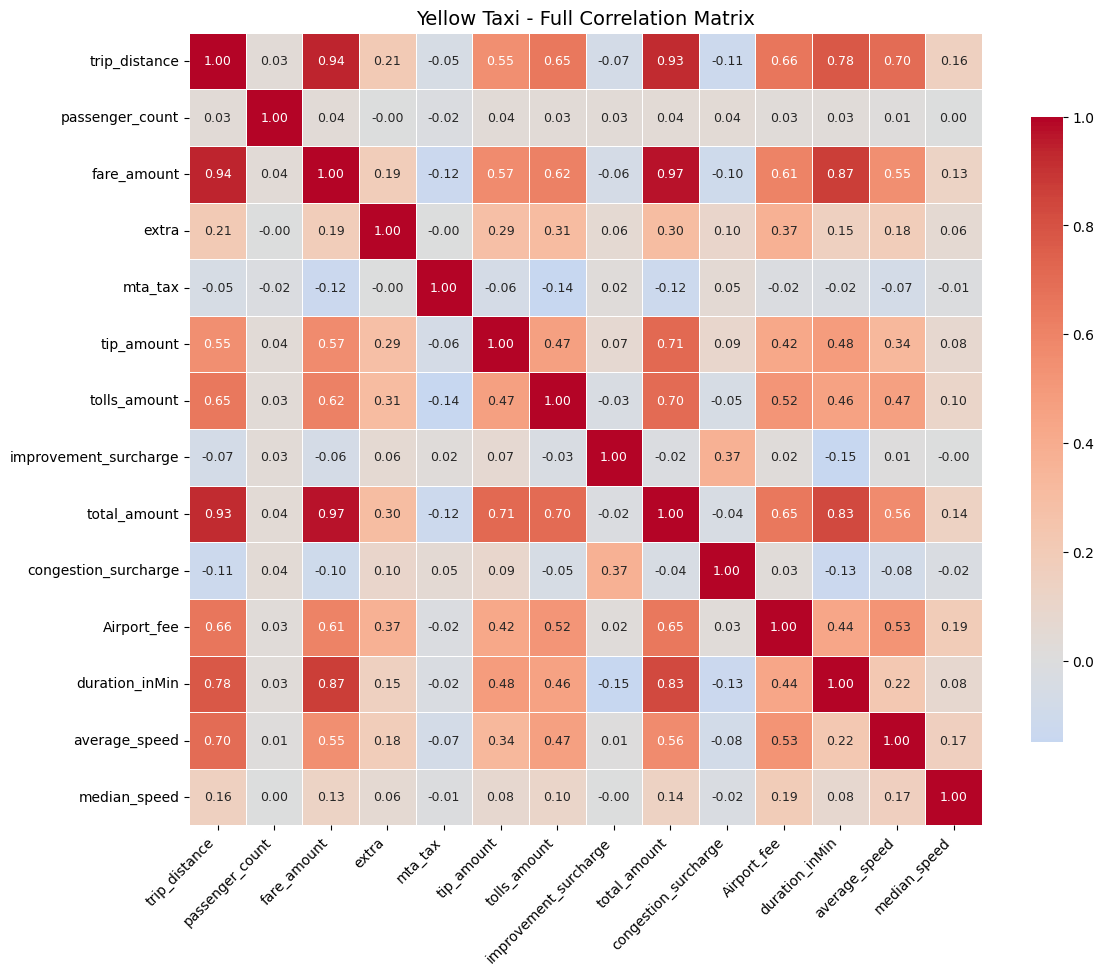


🔍 Significant Correlations (|r| > 0.5):



📊 Correlation Analysis for: Green Taxi (Pearson method)


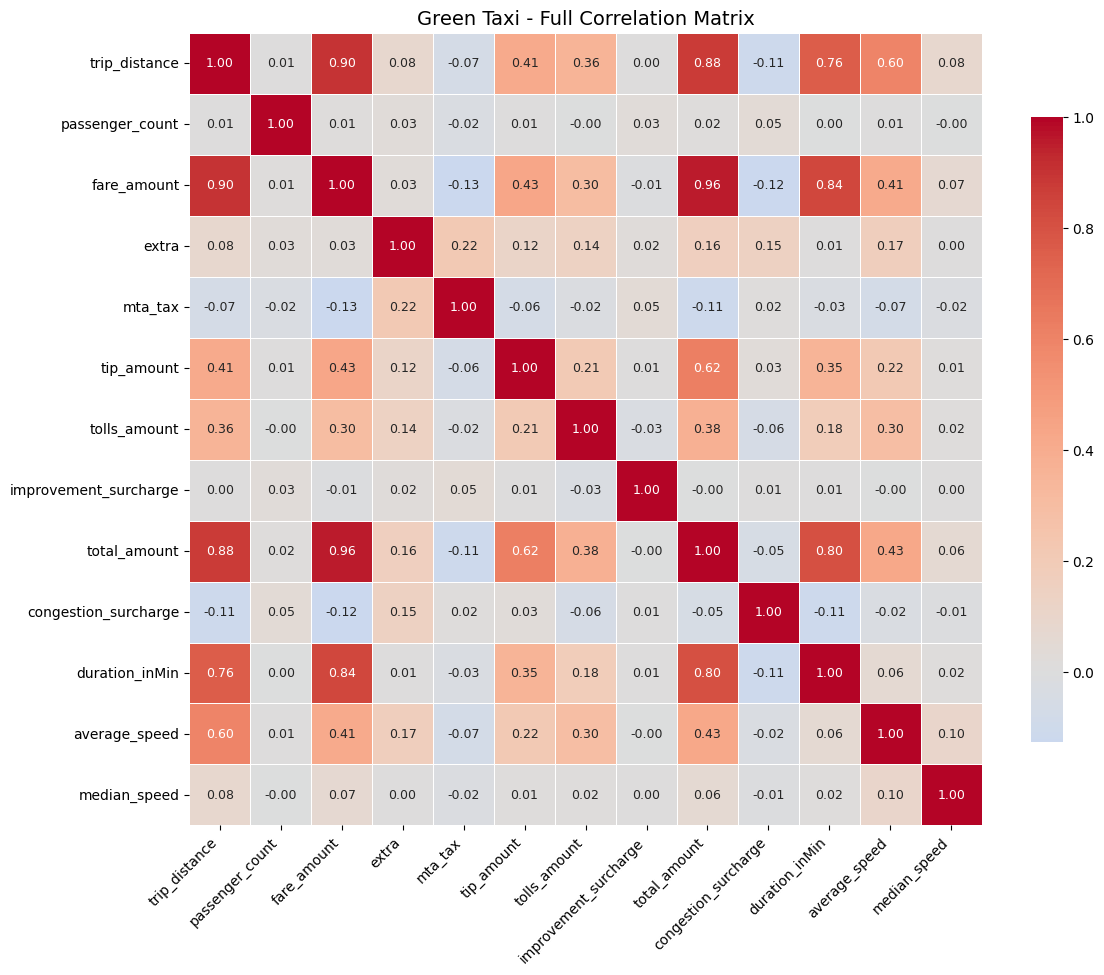


🔍 Significant Correlations (|r| > 0.5):


In [96]:
def correlation_summary(df, df_name='DataFrame', figsize=(12, 10), method='pearson', threshold=0.5):
    """
    Enhanced correlation analysis with:
    1. Full correlation heatmap
    2. Filtered correlation dataframe (|r| > threshold, excluding diagonal)
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        df_name (str): Name for reporting
        figsize (tuple): Figure size
        method (str): Correlation method ('pearson', 'kendall', 'spearman')
        threshold (float): Minimum absolute correlation to include in filtered output
        
    Returns:
        pd.DataFrame: Filtered correlation matrix (|r| > threshold)
    """
    print(f"\n{'='*80}")
    print(f"📊 Correlation Analysis for: {df_name} ({method.title()} method)")
    
    # Select existing numeric columns
    existing_cols = [col for col in target_columns if col in df.columns]
    num_cols = df[existing_cols].select_dtypes(include='number')
    
    if len(num_cols.columns) < 2:
        print("⚠️ Not enough numeric columns for correlation analysis.")
        return None
    
    # Compute correlation matrix
    corr_matrix = num_cols.corr(method=method)
    
    # =================================================================
    # Part 1: Show Full Heatmap
    # =================================================================
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75},
        annot_kws={"size": 9}
    )
    plt.title(f"{df_name} - Full Correlation Matrix", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # =================================================================
    # Part 2: Create Filtered Correlation DataFrame
    # =================================================================
    # Create mask for filtering
    mask = (corr_matrix.abs() > threshold) & (corr_matrix != 1)
    filtered_corr = corr_matrix.where(mask).stack().reset_index()
    filtered_corr.columns = ['Variable1', 'Variable2', 'Correlation']
    
    # Remove duplicates (A vs B is same as B vs A)
    filtered_corr = filtered_corr[filtered_corr['Variable1'] < filtered_corr['Variable2']]
    filtered_corr = filtered_corr.sort_values(by='Correlation', key=abs, ascending=False)
    
    # Print results
    print(f"\n🔍 Significant Correlations (|r| > {threshold}):")
    if filtered_corr.empty:
        print(f"No correlations > {threshold} between different variables.")
    else:
        display(filtered_corr.style.format({'Correlation': '{:.3f}'})
              .background_gradient(cmap='coolwarm', subset=['Correlation'])
              .set_caption(f"Filtered Correlations (|r| > {threshold})"))
    
    return filtered_corr

# Example usage
yellow_corr = correlation_summary(yellow, 'Yellow Taxi')
green_corr = correlation_summary(green, 'Green Taxi')

In [97]:
# # fare vs distance correlation with logged scale

# def plot_fare_vs_distance_logged(
#     df, 
#     df_name='Taxi Data', 
#     add_regression=True, 
#     alpha=0.3, 
#     log_scale=False,
#     clip_min=0.01
# ):
#     """
#     Plots scatterplot of trip_distance vs total_amount for a given taxi DataFrame.
    
#     Parameters:
#         df (pd.DataFrame): DataFrame containing 'trip_distance' and 'total_amount'.
#         df_name (str): Name to display on plot.
#         add_regression (bool): Whether to include regression line.
#         alpha (float): Transparency of points.
#         log_scale (bool): Whether to apply log scale to both axes.
#         clip_min (float): Minimum value to clip for log scale (avoid log(0)).
#     """
#     if 'trip_distance' not in df.columns or 'total_amount' not in df.columns:
#         print(f"⚠️ '{df_name}' is missing required columns.")
#         return

#     print(f"\n{'='*80}")
#     print(f"📈 Plotting Fare vs Distance for: {df_name} {'(Log Scale)' if log_scale else ''}")

#     # Filter or clip data to avoid log(0)
#     plot_df = df.copy()
#     if log_scale:
#         plot_df = plot_df[(plot_df['trip_distance'] > 0) & (plot_df['total_amount'] > 0)]
#         plot_df['trip_distance'] = plot_df['trip_distance'].clip(lower=clip_min)
#         plot_df['total_amount'] = plot_df['total_amount'].clip(lower=clip_min)

#     plt.figure(figsize=(10, 6))

#     if add_regression:
#         sns.regplot(
#             data=plot_df,
#             x='trip_distance',
#             y='total_amount',
#             scatter_kws={'alpha': alpha, 's': 10},
#             line_kws={'color': 'red'}
#         )
#     else:
#         sns.scatterplot(
#             data=plot_df,
#             x='trip_distance',
#             y='total_amount',
#             alpha=alpha,
#             s=10
#         )

#     plt.title(f"{df_name}: Trip Distance vs Total Fare{' (Log Scale)' if log_scale else ''}", fontsize=14)
#     plt.xlabel("Trip Distance (miles)")
#     plt.ylabel("Total Fare ($)")

#     if log_scale:
#         plt.xscale('log')
#         plt.yscale('log')

#     plt.grid(True, linestyle='--', alpha=0.4)
#     plt.tight_layout()
#     plt.show()


# # Linear scale (default)
# plot_fare_vs_distance_logged(yellow, df_name='Yellow Taxi', log_scale=True)

# # Log scale for better visibility of dense areas
# plot_fare_vs_distance_logged(green, df_name='Green Taxi', log_scale=True)


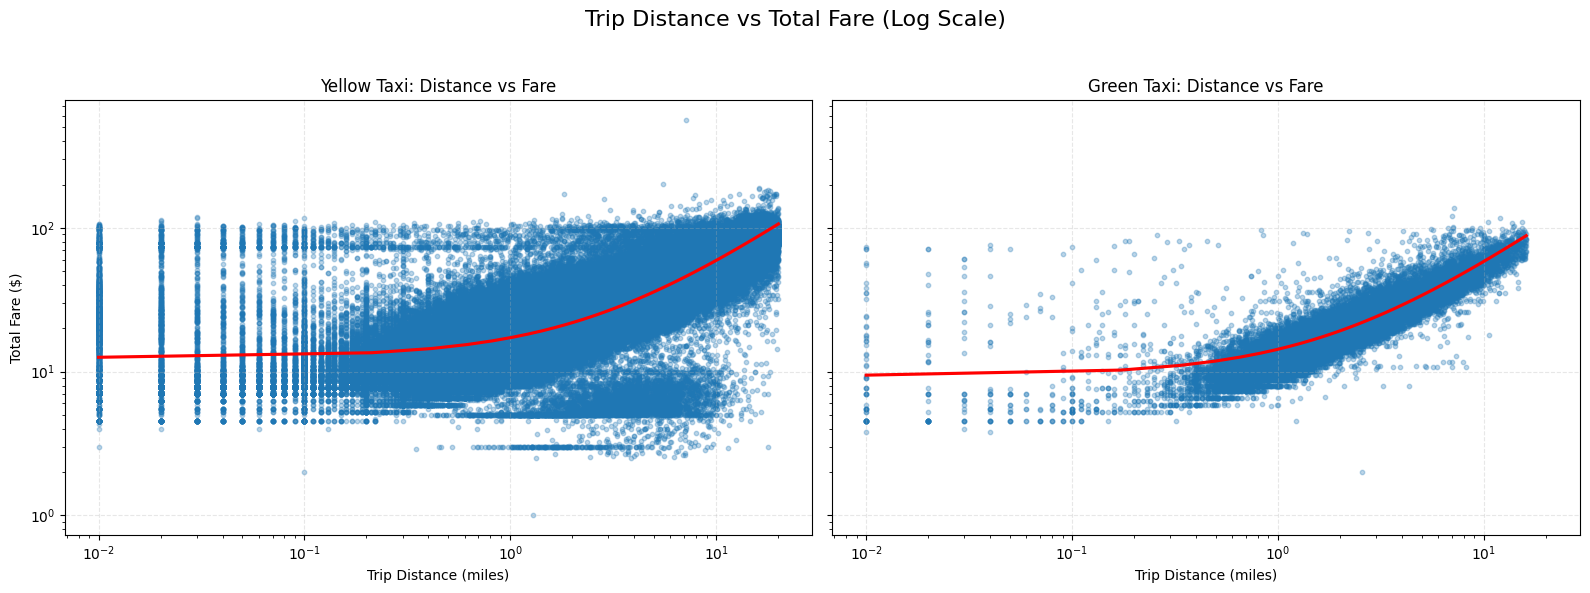

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_fare_vs_distance_logged_dual(
    yellow_df,
    green_df,
    add_regression=True,
    alpha=0.3,
    log_scale=True,
    clip_min=0.01
):
    def preprocess(df):
        df = df.copy()
        if log_scale:
            df = df[(df['trip_distance'] > 0) & (df['total_amount'] > 0)]
            df['trip_distance'] = df['trip_distance'].clip(lower=clip_min)
            df['total_amount'] = df['total_amount'].clip(lower=clip_min)
        return df

    yellow_df = preprocess(yellow_df)
    green_df = preprocess(green_df)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

    # Plot for Yellow Taxi
    if add_regression:
        sns.regplot(
            data=yellow_df,
            x='trip_distance',
            y='total_amount',
            scatter_kws={'alpha': alpha, 's': 10},
            line_kws={'color': 'red'},
            ax=axes[0]
        )
    else:
        sns.scatterplot(
            data=yellow_df,
            x='trip_distance',
            y='total_amount',
            alpha=alpha,
            s=10,
            ax=axes[0]
        )
    axes[0].set_title("Yellow Taxi: Distance vs Fare")
    axes[0].set_xlabel("Trip Distance (miles)")
    axes[0].set_ylabel("Total Fare ($)")
    axes[0].grid(True, linestyle='--', alpha=0.3)

    # Plot for Green Taxi
    if add_regression:
        sns.regplot(
            data=green_df,
            x='trip_distance',
            y='total_amount',
            scatter_kws={'alpha': alpha, 's': 10},
            line_kws={'color': 'red'},
            ax=axes[1]
        )
    else:
        sns.scatterplot(
            data=green_df,
            x='trip_distance',
            y='total_amount',
            alpha=alpha,
            s=10,
            ax=axes[1]
        )
    axes[1].set_title("Green Taxi: Distance vs Fare")
    axes[1].set_xlabel("Trip Distance (miles)")
    axes[1].set_ylabel("")
    axes[1].grid(True, linestyle='--', alpha=0.3)

    # Log scale
    if log_scale:
        axes[0].set_xscale('log')
        axes[0].set_yscale('log')
        axes[1].set_xscale('log')
        axes[1].set_yscale('log')

    plt.suptitle("Trip Distance vs Total Fare (Log Scale)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_fare_vs_distance_logged_dual(yellow, green, add_regression=True, log_scale=True)


# 📊 1. **How do taxi fares vary by hour of the day?**

- Passenger demand and traffic conditions fluctuate throughout the day, affecting fare amounts and trip characteristics. Analyzing fare trends by pickup hour reveals peak times and potential price surges.

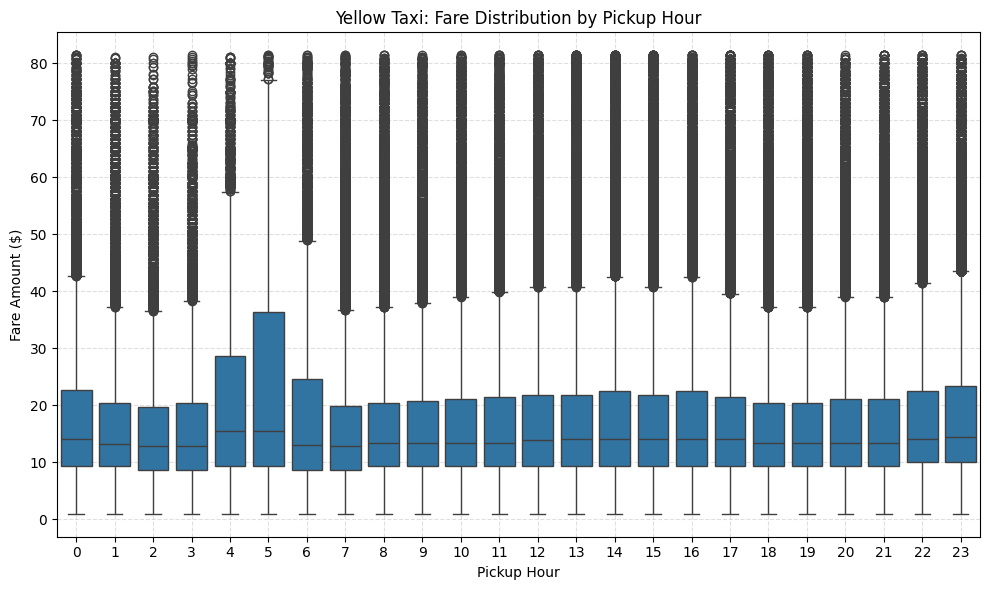

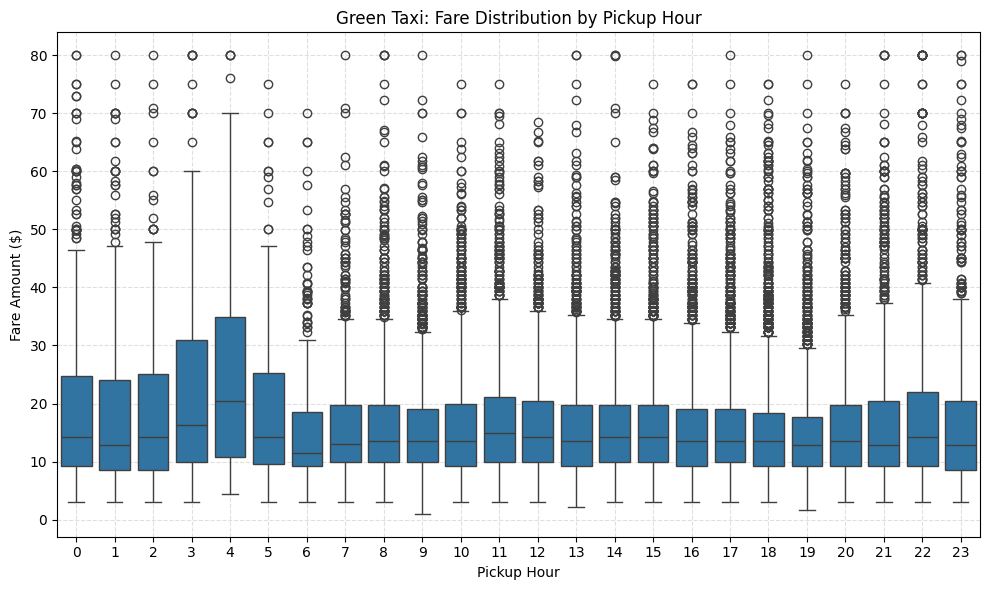

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_hourly_fare(df, df_name):
    plt.figure(figsize=(10,6))
    sns.boxplot(data=df, x='pickup_hour', y='fare_amount')
    plt.title(f"{df_name}: Fare Distribution by Pickup Hour")
    plt.xlabel("Pickup Hour")
    plt.ylabel("Fare Amount ($)")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_hourly_fare(yellow, "Yellow Taxi")
plot_hourly_fare(green, "Green Taxi")


# 📊 2. Which boroughs generate the most pickups?
Analyzing pickup borough frequency helps identify demand hot spots and understand the geographic spread of taxi service usage.

In [100]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# def plot_pickups_by_borough(df, df_name):
#     """
#     Plots taxi pickups by borough with:
#     - Logarithmic scaling to handle dominant boroughs
#     - Exact count annotations
#     - Clean formatting
    
#     Parameters:
#         df (pd.DataFrame): DataFrame containing taxi data
#         df_name (str): Name for chart title
#     """
#     # 1. Prepare the data
#     pickup_counts = df['PU_Borough'].value_counts().sort_values(ascending=False)
    
#     # 2. Create the plot
#     plt.figure(figsize=(8,5))
#     ax = sns.barplot(
#         x=pickup_counts.values, 
#         y=pickup_counts.index, 
#         color="C0",
#         log=True  # This enables logarithmic scaling on x-axis
#     )
    
#     # 3. Customize the plot
#     plt.title(f"{df_name}: Pickups by Borough (Log Scale)", pad=20)
#     plt.xlabel("Number of Pickups (log scale)", labelpad=10)
#     plt.ylabel("Borough", labelpad=10)
    
#     # 4. Add value annotations
#     for i, count in enumerate(pickup_counts):
#         ax.text(
#             count,            # x-position (using original count)
#             i,                # y-position (current borough index)
#             f" {count:,}",    # Formatted text with thousands separator
#             va='center',      # Vertical alignment
#             ha='left',        # Horizontal alignment
#             fontsize=9        # Adjust as needed
#         )
    
#     # 5. Final formatting
#     plt.grid(axis='x', linestyle='--', alpha=0.3)  # Add subtle grid lines
#     plt.tight_layout()
#     plt.show()

# # Example Usage
# plot_pickups_by_borough(yellow, "Yellow Taxi")
# plot_pickups_by_borough(green, "Green Taxi")

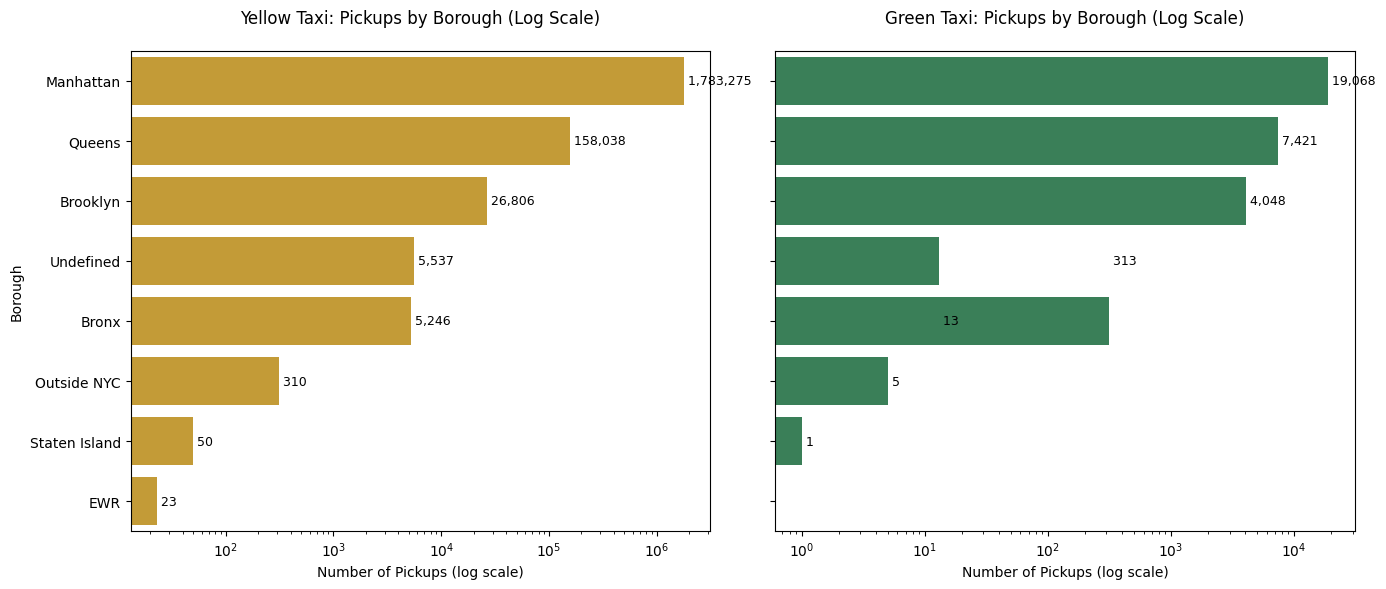

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pickups_by_borough_dual(yellow_df, green_df):
    def prepare_counts(df):
        return df['PU_Borough'].value_counts().sort_values(ascending=False)

    yellow_counts = prepare_counts(yellow_df)
    green_counts = prepare_counts(green_df)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Yellow Plot
    ax1 = sns.barplot(
        x=yellow_counts.values,
        y=yellow_counts.index,
        color="goldenrod",
        log=True,
        ax=axes[0]
    )
    axes[0].set_title("Yellow Taxi: Pickups by Borough (Log Scale)", pad=20)
    axes[0].set_xlabel("Number of Pickups (log scale)")
    axes[0].set_ylabel("Borough")
    for i, count in enumerate(yellow_counts):
        ax1.text(count, i, f" {count:,}", va='center', ha='left', fontsize=9)

    # Green Plot
    ax2 = sns.barplot(
        x=green_counts.values,
        y=green_counts.index,
        color="seagreen",
        log=True,
        ax=axes[1]
    )
    axes[1].set_title("Green Taxi: Pickups by Borough (Log Scale)", pad=20)
    axes[1].set_xlabel("Number of Pickups (log scale)")
    axes[1].set_ylabel("")
    for i, count in enumerate(green_counts):
        ax2.text(count, i, f" {count:,}", va='center', ha='left', fontsize=9)

    plt.tight_layout()
    plt.show()
plot_pickups_by_borough_dual(yellow, green)


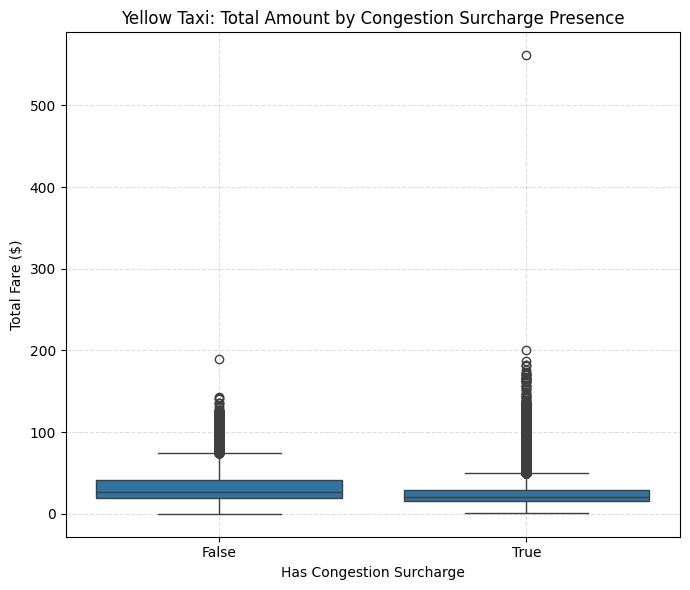

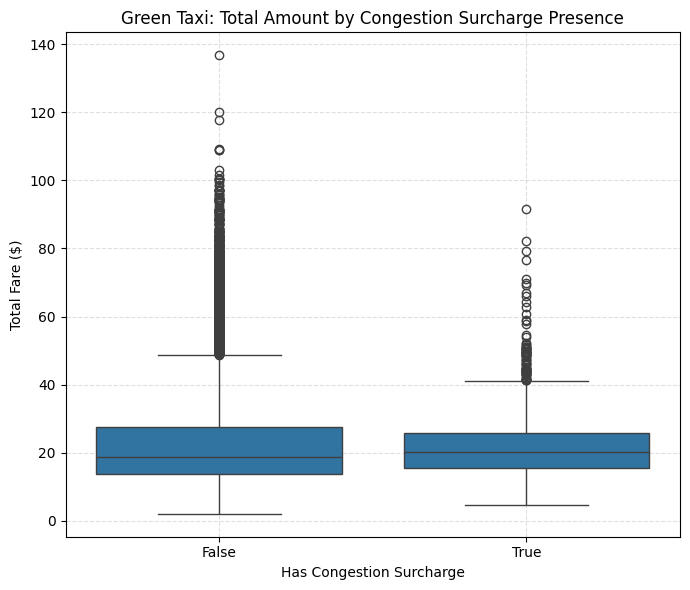

In [102]:
def plot_congestion_impact(df, df_name):
    plt.figure(figsize=(7,6))
    df['has_congestion'] = df['congestion_surcharge'] > 0
    sns.boxplot(data=df, x='has_congestion', y='total_amount')
    plt.title(f"{df_name}: Total Amount by Congestion Surcharge Presence")
    plt.xlabel("Has Congestion Surcharge")
    plt.ylabel("Total Fare ($)")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_congestion_impact(yellow, "Yellow Taxi")
plot_congestion_impact(green, "Green Taxi")


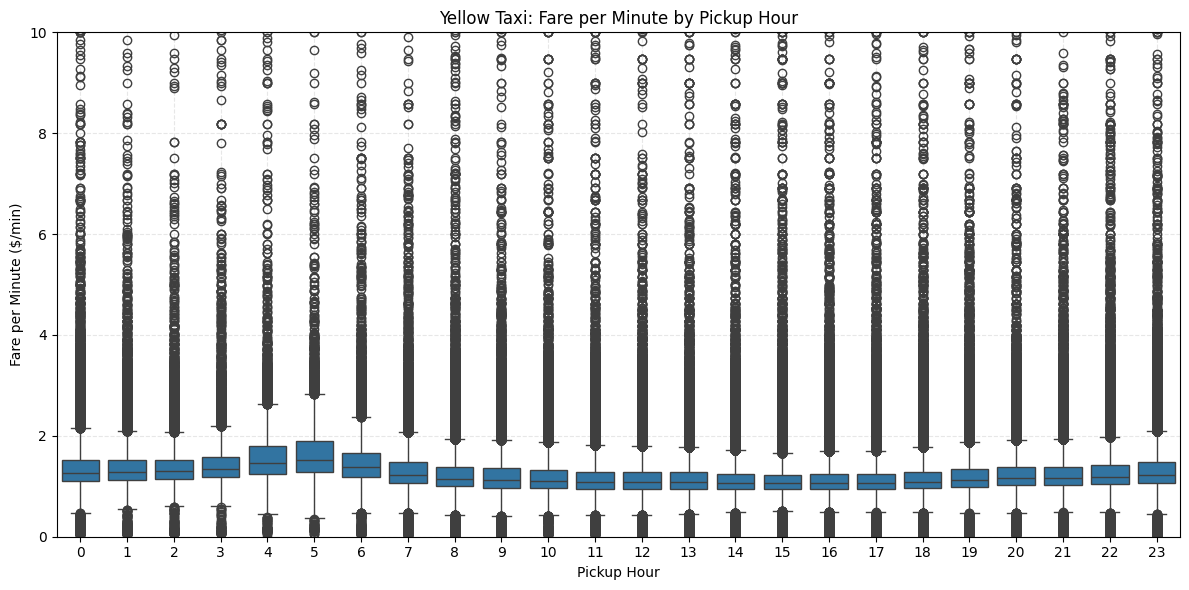

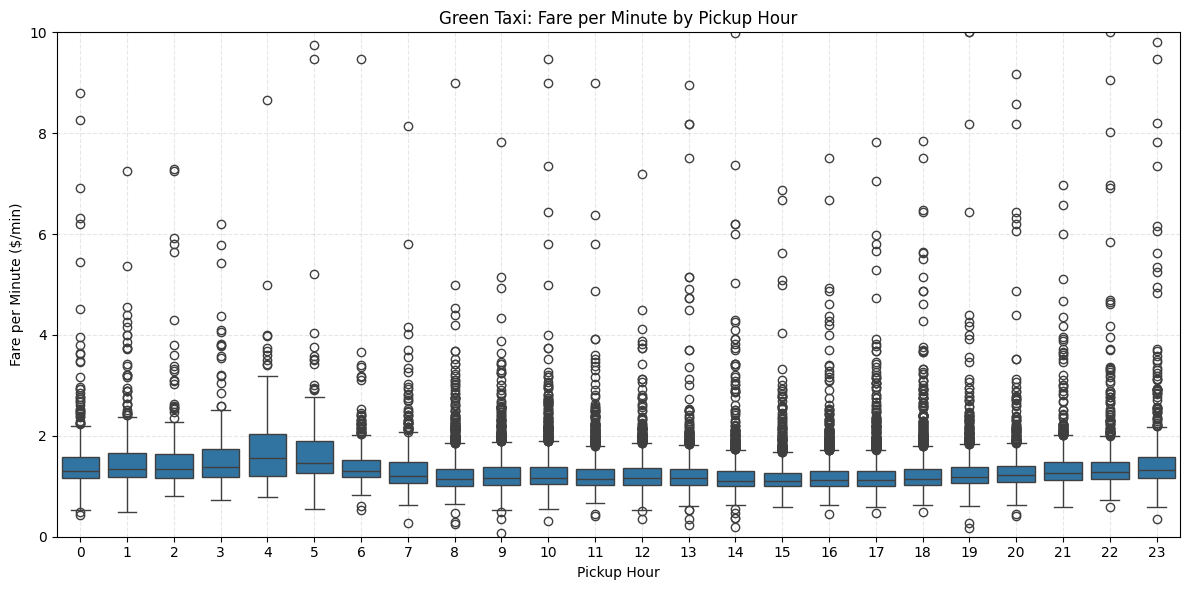

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_fare_per_minute_by_hour(df, df_name):
    #df = df[df['fare_per_minute'] <= 10]
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='pickup_hour', y='fare_per_minute')
    plt.title(f"{df_name}: Fare per Minute by Pickup Hour")
    plt.xlabel("Pickup Hour")
    plt.ylabel("Fare per Minute ($/min)")
    plt.ylim(0, 10)  # adjust depending on your data
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_fare_per_minute_by_hour(yellow, "Yellow Taxi")
plot_fare_per_minute_by_hour(green, "Green Taxi")


- yellow :"Fare per minute tends to remain stable throughout the day, with slight increases during early morning (0–6 AM) and late evening (20–23 PM). The rise in off-peak hours may be due to short, high-fare trips. Outliers suggest frequent expensive short rides, especially during overnight hours."
- green:...

In [104]:
# def plot_top_dropoff_zones(df, df_name, top_n=10):
#     # Count grouped by zone + borough
#     zone_counts = df.groupby(['DO_Zone', 'DO_Borough']).size().reset_index(name='trip_count')
    
#     # Sort and get top N
#     top_zones = zone_counts.sort_values(by='trip_count', ascending=False).head(top_n)
    
#     # Create composite label: "Zone (Borough)"
#     top_zones['label'] = top_zones['DO_Zone'] + " (" + top_zones['DO_Borough'] + ")"
    
#     # Plot
#     plt.figure(figsize=(12, 6))
#     sns.barplot(y=top_zones['label'], x=top_zones['trip_count'], palette="magma")
#     plt.title(f"{df_name}: Top {top_n} Dropoff Zones with Boroughs")
#     plt.xlabel("Number of Trips")
#     plt.ylabel("Dropoff Zone (Borough)")
#     plt.tight_layout()
#     plt.show()
    
# plot_top_dropoff_zones(yellow, "Yellow Taxi")
# plot_top_dropoff_zones(green, "Green Taxi")


In [105]:
# def plot_top_pickup_zones(df, df_name, top_n=10):
#     # Group by pickup zone and borough
#     pickup_counts = df.groupby(['PU_Zone', 'PU_Borough']).size().reset_index(name='trip_count')
    
#     # Sort by count and take top N
#     top_pickups = pickup_counts.sort_values(by='trip_count', ascending=False).head(top_n)
    
#     # Create label like "Zone (Borough)"
#     top_pickups['label'] = top_pickups['PU_Zone'] + " (" + top_pickups['PU_Borough'] + ")"
    
#     # Plot
#     plt.figure(figsize=(12, 6))
#     sns.barplot(y=top_pickups['label'], x=top_pickups['trip_count'], palette="viridis")
#     plt.title(f"{df_name}: Top {top_n} Pickup Zones with Boroughs")
#     plt.xlabel("Number of Trips")
#     plt.ylabel("Pickup Zone (Borough)")
#     plt.tight_layout()
#     plt.show()
# plot_top_pickup_zones(yellow, "Yellow Taxi")
# plot_top_pickup_zones(green, "Green Taxi")


In [106]:
# def plot_top_pickup_dropoff_pairs(df, df_name, top_n=10):
#     # Group by pickup/dropoff zone and borough
#     pair_counts = (
#         df.groupby(['PU_Zone', 'PU_Borough', 'DO_Zone', 'DO_Borough'])
#           .size()
#           .reset_index(name='trip_count')
#           .sort_values(by='trip_count', ascending=False)
#           .head(top_n)
#     )
    
#     # Create label: "PU Zone (PU Borough) → DO Zone (DO Borough)"
#     pair_counts['label'] = (
#         pair_counts['PU_Zone'] + " (" + pair_counts['PU_Borough'] + ") → " +
#         pair_counts['DO_Zone'] + " (" + pair_counts['DO_Borough'] + ")"
#     )

#     # Plot
#     plt.figure(figsize=(12, 6))
#     sns.barplot(y=pair_counts['label'], x=pair_counts['trip_count'], palette="plasma")
#     plt.title(f"{df_name}: Top {top_n} Pickup → Dropoff Routes with Boroughs")
#     plt.xlabel("Number of Trips")
#     plt.ylabel("PU → DO Route (Zone + Borough)")
#     plt.tight_layout()
#     plt.show()
# plot_top_pickup_dropoff_pairs(yellow, "Yellow Taxi")
# plot_top_pickup_dropoff_pairs(green, "Green Taxi")


C:\Users\DELL\AppData\Local\Temp\ipykernel_11748\2764883247.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\DELL\AppData\Local\Temp\ipykernel_11748\2764883247.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


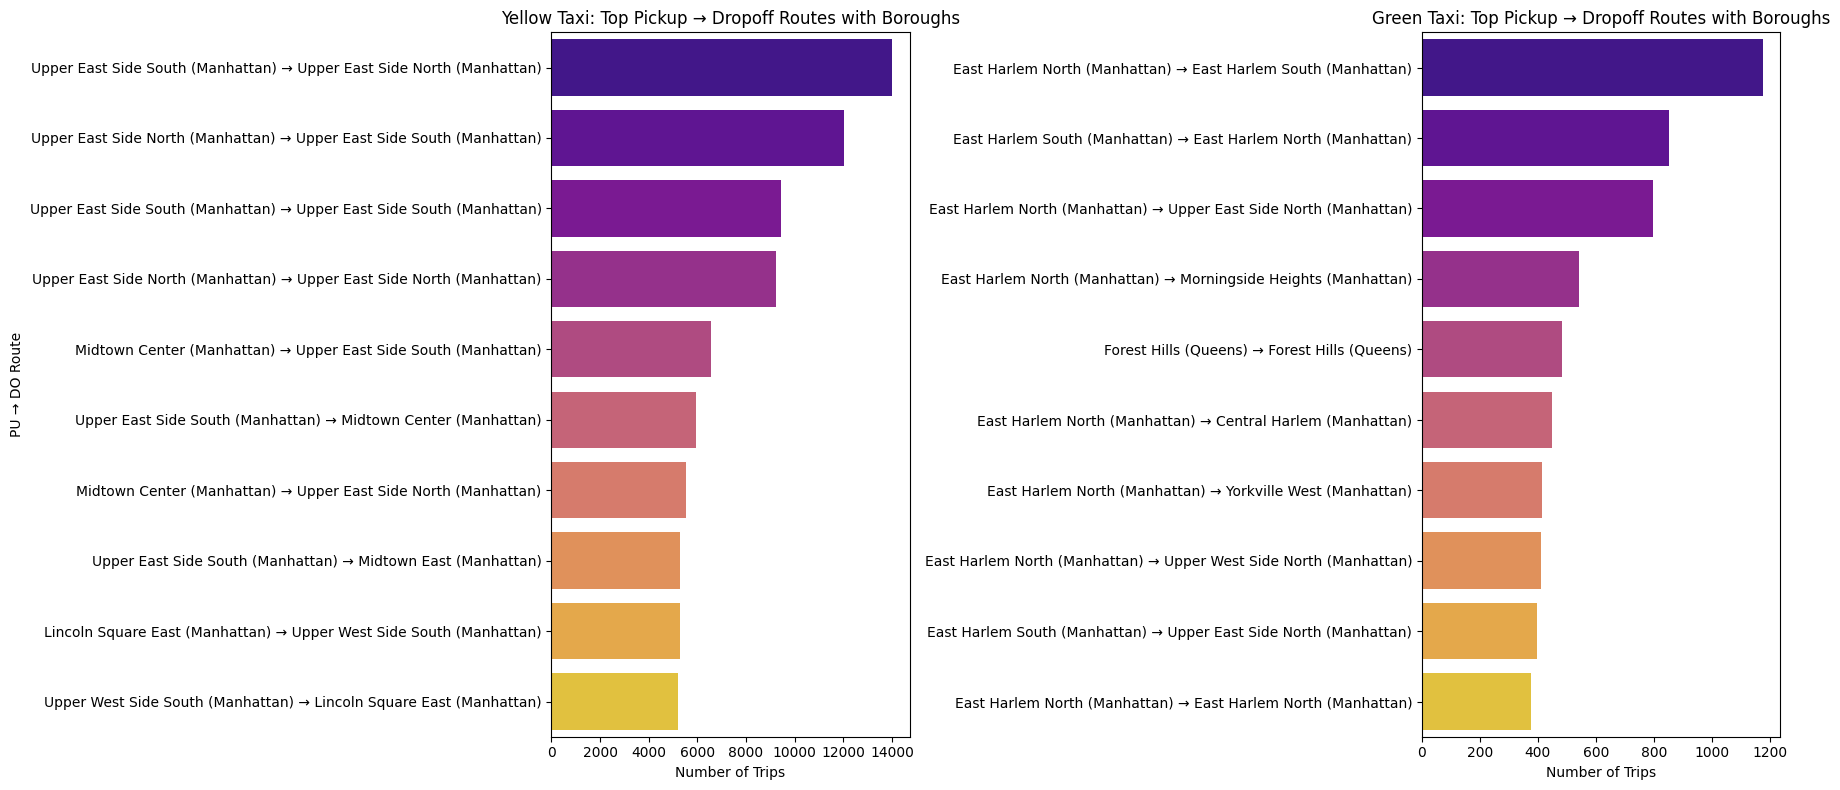

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_top_pickup_dropoff_pairs_dual(yellow_df, green_df, top_n=10):
    def prepare_pair_counts(df):
        pair_counts = (
            df.groupby(['PU_Zone', 'PU_Borough', 'DO_Zone', 'DO_Borough'])
              .size()
              .reset_index(name='trip_count')
              .sort_values(by='trip_count', ascending=False)
              .head(top_n)
        )
        pair_counts['label'] = (
            pair_counts['PU_Zone'] + " (" + pair_counts['PU_Borough'] + ") → " +
            pair_counts['DO_Zone'] + " (" + pair_counts['DO_Borough'] + ")"
        )
        return pair_counts

    # Prepare data
    yellow_pairs = prepare_pair_counts(yellow_df)
    green_pairs = prepare_pair_counts(green_df)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=False)

    sns.barplot(
        data=yellow_pairs,
        y='label',
        x='trip_count',
        palette="plasma",
        ax=axes[0]
    )
    axes[0].set_title("Yellow Taxi: Top Pickup → Dropoff Routes with Boroughs")
    axes[0].set_xlabel("Number of Trips")
    axes[0].set_ylabel("PU → DO Route")

    sns.barplot(
        data=green_pairs,
        y='label',
        x='trip_count',
        palette="plasma",
        ax=axes[1]
    )
    axes[1].set_title("Green Taxi: Top Pickup → Dropoff Routes with Boroughs")
    axes[1].set_xlabel("Number of Trips")
    axes[1].set_ylabel("")

    plt.tight_layout()
    plt.show()
plot_top_pickup_dropoff_pairs_dual(yellow, green, top_n=10)


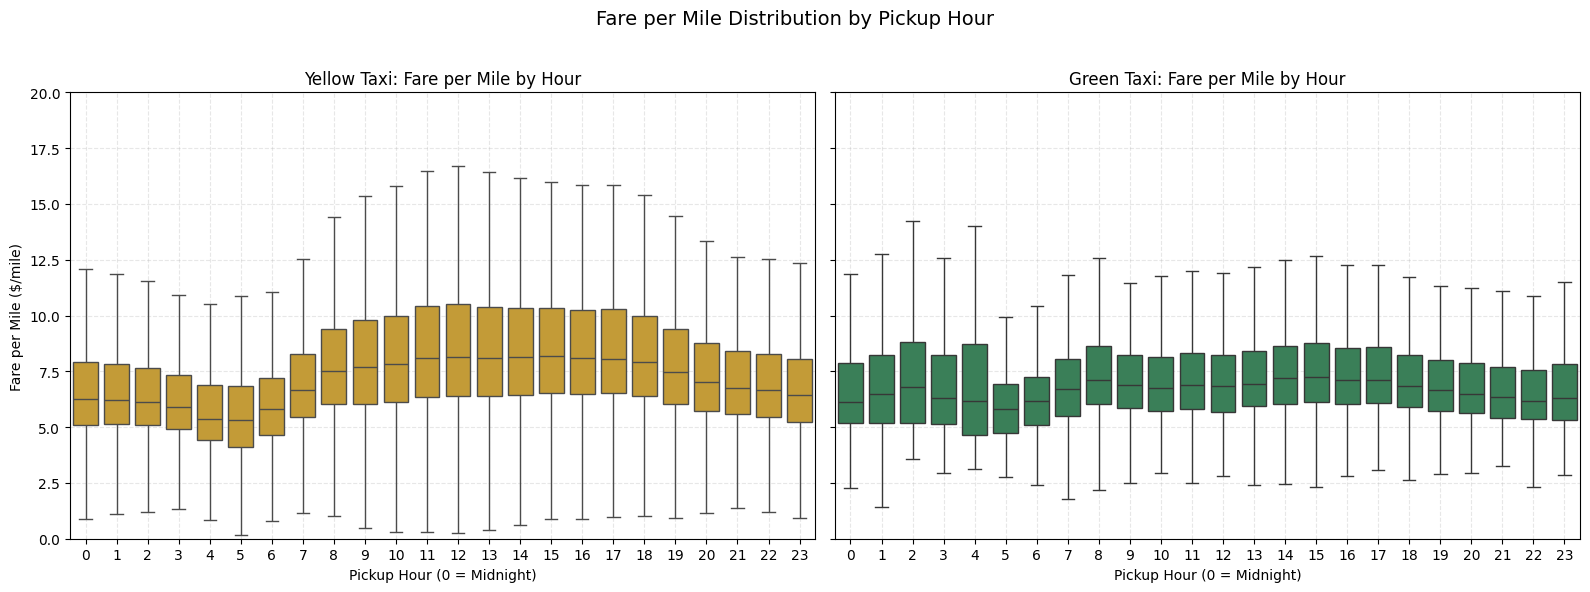

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_fare_per_mile_by_hour_dual(yellow_df, green_df, ylim=(0, 30)):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    # Yellow Taxi
    sns.boxplot(
        data=yellow_df,
        x='pickup_hour',
        y='fare_per_mile',
        showfliers=False,
        ax=axes[0],
        color='goldenrod'
    )
    axes[0].set_title("Yellow Taxi: Fare per Mile by Hour")
    axes[0].set_xlabel("Pickup Hour (0 = Midnight)")
    axes[0].set_ylabel("Fare per Mile ($/mile)")
    axes[0].set_ylim(ylim)
    axes[0].grid(True, linestyle='--', alpha=0.3)

    # Green Taxi
    sns.boxplot(
        data=green_df,
        x='pickup_hour',
        y='fare_per_mile',
        showfliers=False,
        ax=axes[1],
        color='seagreen'
    )
    axes[1].set_title("Green Taxi: Fare per Mile by Hour")
    axes[1].set_xlabel("Pickup Hour (0 = Midnight)")
    axes[1].set_ylabel("")  # Avoid repeat
    axes[1].set_ylim(ylim)
    axes[1].grid(True, linestyle='--', alpha=0.3)

    plt.suptitle("Fare per Mile Distribution by Pickup Hour", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
plot_fare_per_mile_by_hour_dual(yellow, green, ylim=(0, 20))


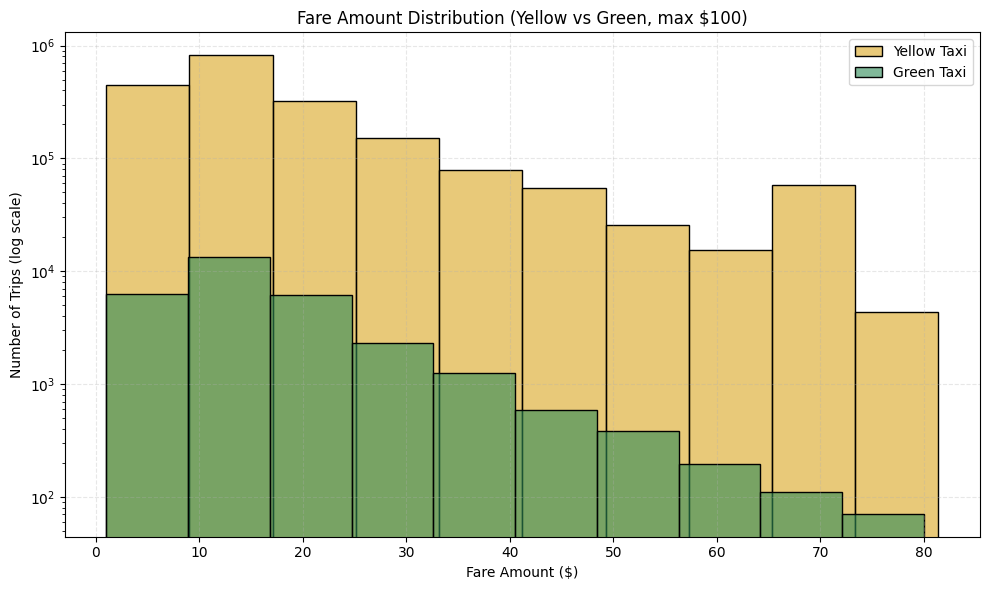

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_combined_fare_amount_histogram(yellow_df, green_df, bin_width=10, max_fare=100):
    # Filter out extreme fare values
    yellow_filtered = yellow_df[yellow_df['fare_amount'] <= max_fare]
    green_filtered = green_df[green_df['fare_amount'] <= max_fare]

    # Set bin count
    bins = int(max_fare // bin_width)

    # Set up plot
    plt.figure(figsize=(10, 6))
    sns.histplot(
        yellow_filtered['fare_amount'],
        bins=bins,
        kde=False,
        color='goldenrod',
        label='Yellow Taxi',
        alpha=0.6
    )
    sns.histplot(
        green_filtered['fare_amount'],
        bins=bins,
        kde=False,
        color='seagreen',
        label='Green Taxi',
        alpha=0.6
    )

    # Apply log scale to y-axis
    plt.yscale('log')

    # Customize chart
    plt.title(f"Fare Amount Distribution (Yellow vs Green, max ${max_fare})")
    plt.xlabel("Fare Amount ($)")
    plt.ylabel("Number of Trips (log scale)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
plot_combined_fare_amount_histogram(yellow, green, bin_width=10, max_fare=100)


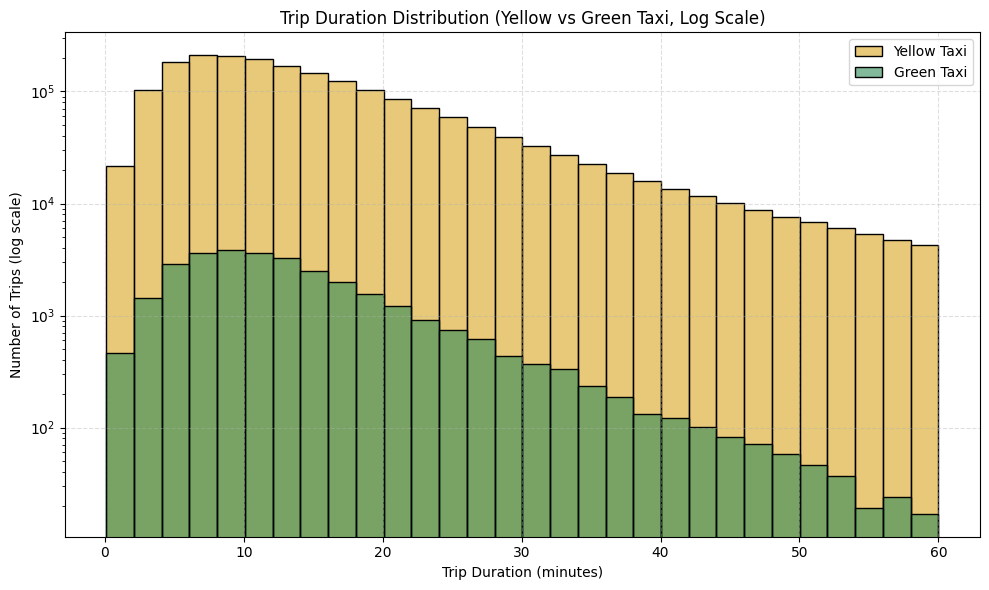

In [110]:
def plot_combined_trip_duration_histogram(yellow_df, green_df, bin_width=2, max_duration=60):
    # Filter durations
    yellow_filtered = yellow_df[yellow_df['duration_inMin'] <= max_duration]
    green_filtered = green_df[green_df['duration_inMin'] <= max_duration]

    # Set bins
    bins = int(max_duration // bin_width)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.histplot(
        yellow_filtered['duration_inMin'],
        bins=bins,
        color='goldenrod',
        alpha=0.6,
        label='Yellow Taxi'
    )
    sns.histplot(
        green_filtered['duration_inMin'],
        bins=bins,
        color='seagreen',
        alpha=0.6,
        label='Green Taxi'
    )

    # Apply log scale to y-axis
    plt.yscale('log')

    # Customize
    plt.title("Trip Duration Distribution (Yellow vs Green Taxi, Log Scale)")
    plt.xlabel("Trip Duration (minutes)")
    plt.ylabel("Number of Trips (log scale)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()
plot_combined_trip_duration_histogram(yellow, green, bin_width=2, max_duration=60)


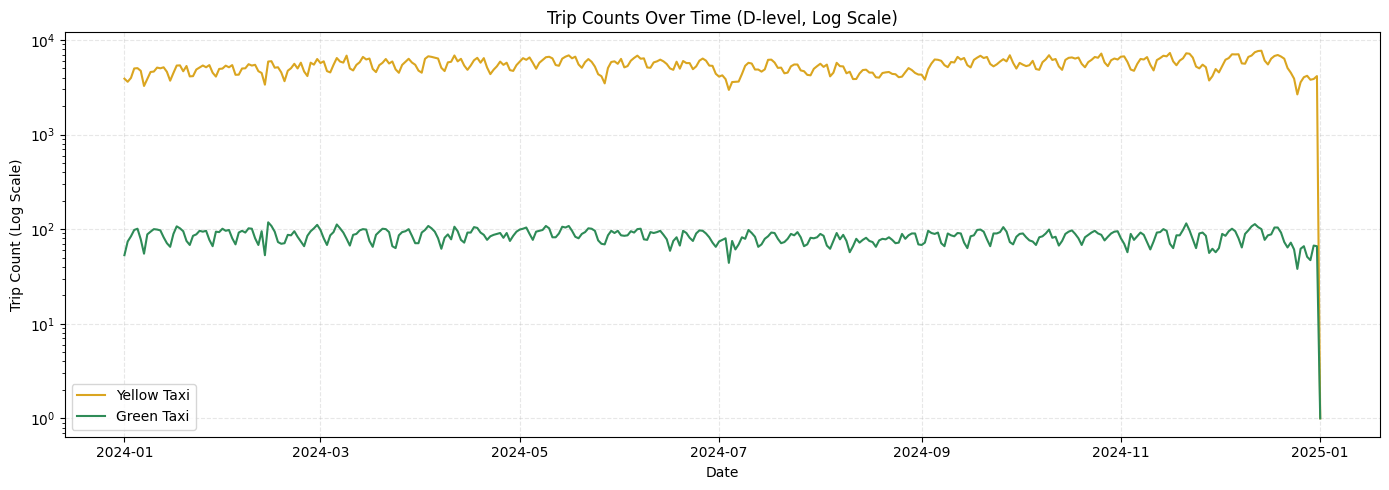

In [111]:
def plot_trip_counts_timeseries_combined_log(yellow_df, green_df, date_col='pickup_date', freq='D'):
    # Ensure date column is datetime
    yellow_df[date_col] = pd.to_datetime(yellow_df[date_col])
    green_df[date_col] = pd.to_datetime(green_df[date_col])

    # Group by date or desired frequency
    yellow_counts = yellow_df.groupby(pd.Grouper(key=date_col, freq=freq)).size()
    green_counts = green_df.groupby(pd.Grouper(key=date_col, freq=freq)).size()

    # Merge counts to align time index (in case dates don't fully overlap)
    all_dates = pd.DataFrame({
        'Yellow Taxi': yellow_counts,
        'Green Taxi': green_counts
    }).fillna(1)  # Use 1 instead of 0 to avoid log(0)

    # Plot
    plt.figure(figsize=(14, 5))
    plt.plot(all_dates.index, all_dates['Yellow Taxi'], linestyle='-', label='Yellow Taxi', color='goldenrod')
    plt.plot(all_dates.index, all_dates['Green Taxi'], linestyle='-', label='Green Taxi', color='seagreen')

    plt.yscale('log')  # Apply log scale
    plt.title(f"Trip Counts Over Time ({freq}-level, Log Scale)")
    plt.xlabel("Date")
    plt.ylabel("Trip Count (Log Scale)")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_trip_counts_timeseries_combined_log(yellow, green)


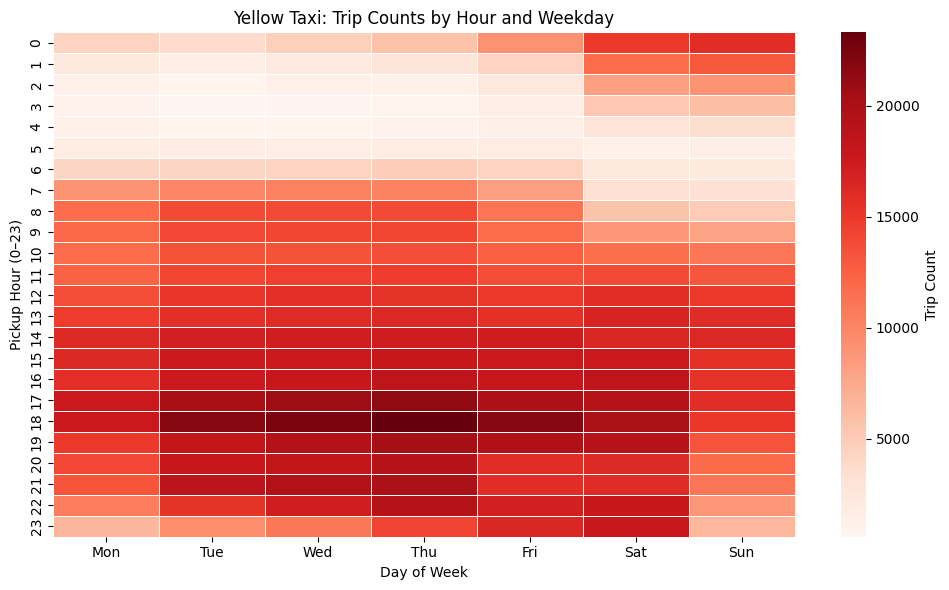

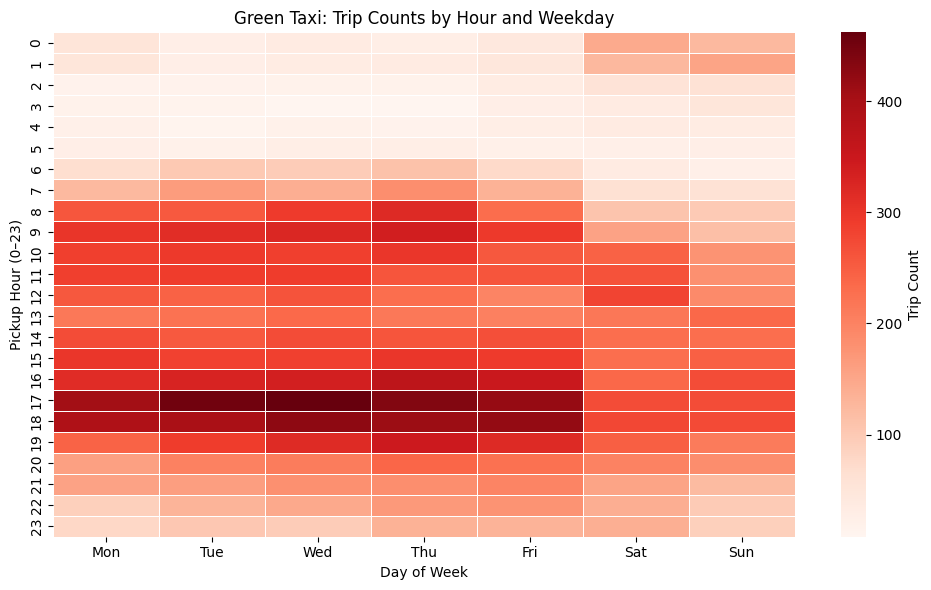

In [112]:
def plot_trip_heatmap_by_day_hour_clean(df_yellow, df_green):
    def prepare_heatmap_data(df):
        # Group and pivot
        heatmap_data = (
            df.groupby(['pickup_dayofweek', 'pickup_hour'])
              .size()
              .reset_index(name='trip_count')
              .pivot(index='pickup_hour', columns='pickup_dayofweek', values='trip_count')
              .fillna(0)
        )
        # Rename columns to weekday names
        weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        heatmap_data.columns = [weekday_labels[i] for i in heatmap_data.columns]
        return heatmap_data

    # Yellow Heatmap
    yellow_heatmap = prepare_heatmap_data(df_yellow)
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        yellow_heatmap,
        cmap='Reds',
        linewidths=0.5,
        cbar_kws={'label': 'Trip Count'},
        annot=False
    )
    plt.title("Yellow Taxi: Trip Counts by Hour and Weekday")
    plt.xlabel("Day of Week")
    plt.ylabel("Pickup Hour (0–23)")
    plt.tight_layout()
    plt.show()

    # Green Heatmap
    green_heatmap = prepare_heatmap_data(df_green)
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        green_heatmap,
        cmap='Reds',
        linewidths=0.5,
        cbar_kws={'label': 'Trip Count'},
        annot=False
    )
    plt.title("Green Taxi: Trip Counts by Hour and Weekday")
    plt.xlabel("Day of Week")
    plt.ylabel("Pickup Hour (0–23)")
    plt.tight_layout()
    plt.show()

plot_trip_heatmap_by_day_hour_clean(yellow, green)


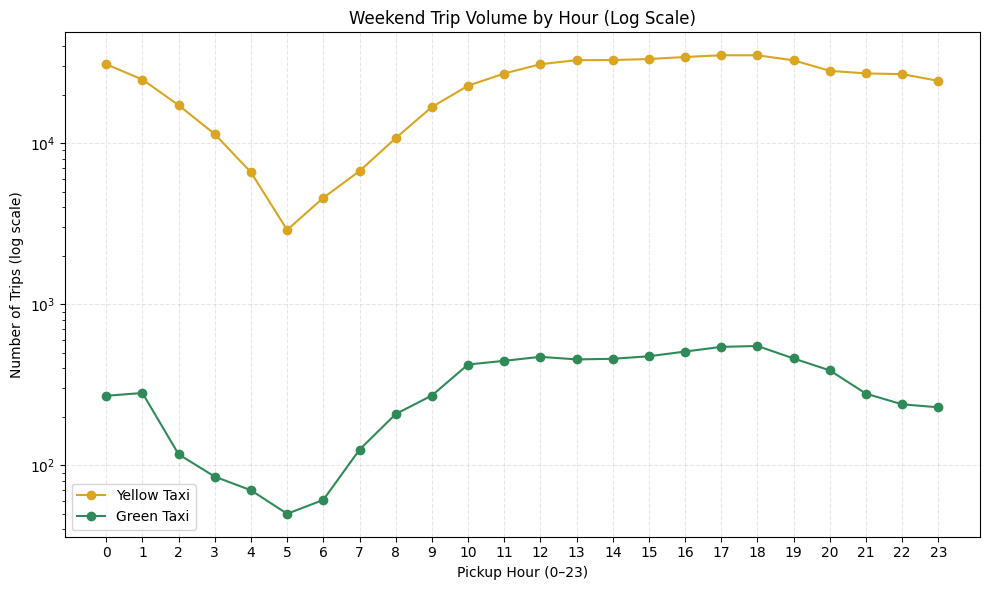

In [113]:
def plot_weekend_demand_by_hour_line(yellow_df, green_df):
    # Filter to weekend trips only: Saturday (5) & Sunday (6)
    yellow_weekend = yellow_df[yellow_df['pickup_dayofweek'].isin([5, 6])]
    green_weekend = green_df[green_df['pickup_dayofweek'].isin([5, 6])]

    # Group each by hour
    yellow_counts = yellow_weekend.groupby('pickup_hour').size().reset_index(name='Yellow Taxi')
    green_counts = green_weekend.groupby('pickup_hour').size().reset_index(name='Green Taxi')

    # Merge on pickup_hour
    merged = pd.merge(yellow_counts, green_counts, on='pickup_hour', how='outer').fillna(1)  # avoid log(0)

    # Sort by hour
    merged = merged.sort_values(by='pickup_hour')

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(merged['pickup_hour'], merged['Yellow Taxi'], marker='o', label='Yellow Taxi', color='goldenrod')
    plt.plot(merged['pickup_hour'], merged['Green Taxi'], marker='o', label='Green Taxi', color='seagreen')

    plt.yscale('log')  # 🔥 log scale to improve visibility
    plt.title("Weekend Trip Volume by Hour (Log Scale)")
    plt.xlabel("Pickup Hour (0–23)")
    plt.ylabel("Number of Trips (log scale)")
    plt.xticks(range(0, 24))
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_weekend_demand_by_hour_line(yellow, green)


In [114]:
# vendor_labels = {
#     1: "Creative Mobile Technologies (CMT)",
#     2: "Curb Mobility",
#     6: "Myle Technologies",
#     7: "Helix"
# }

# def plot_vendorid_pie(df, df_name):
#     # Count trips per vendor
#     vendor_counts = df['VendorID'].value_counts().sort_index()

#     # Map VendorID to descriptive names
#     vendor_labels = {
#         1: "Creative Mobile Technologies (CMT)",
#         2: "Curb Mobility",
#         6: "Myle Technologies",
#         7: "Helix"
#     }
#     labels = [vendor_labels.get(v, f"Vendor {v}") for v in vendor_counts.index]

#     # Plot pie chart
#     plt.figure(figsize=(7, 7))
#     plt.pie(
#         vendor_counts,
#         labels=labels,
#         autopct='%1.1f%%',
#         startangle=140,
#         colors=sns.color_palette("pastel"),
#         wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
#     )
#     plt.title(f"{df_name}: VendorID Trip Distribution")
#     plt.tight_layout()
#     plt.show()

# plot_vendorid_pie(yellow, "Yellow Taxi")
# plot_vendorid_pie(green, "Green Taxi")


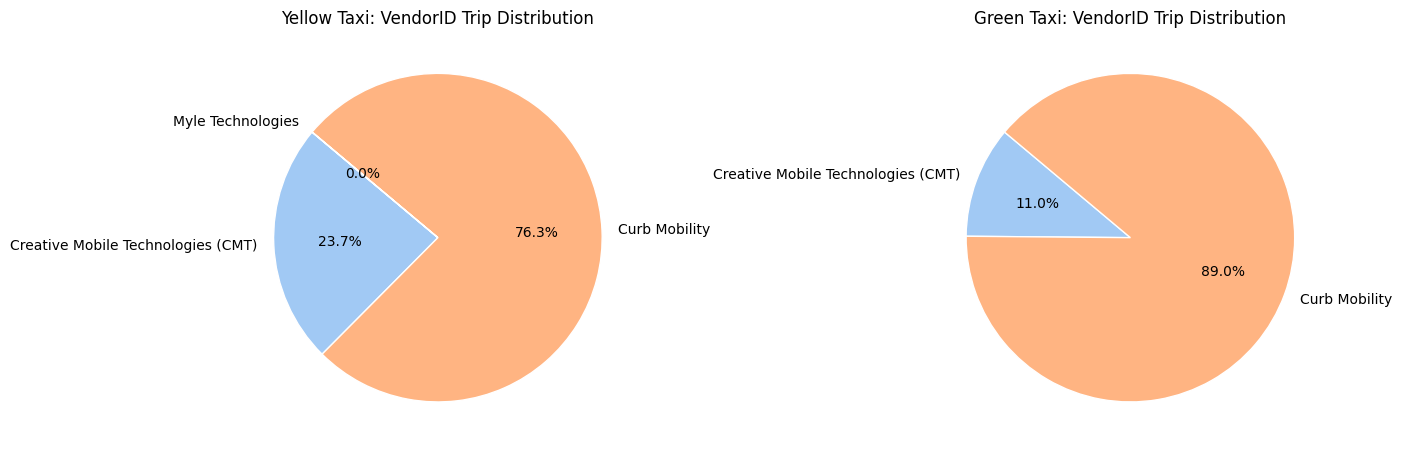

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_vendorid_pie_dual(yellow_df, green_df):
    # Vendor name mapping
    vendor_labels = {
        1: "Creative Mobile Technologies (CMT)",
        2: "Curb Mobility",
        6: "Myle Technologies",
        7: "Helix"
    }

    def get_counts(df):
        counts = df['VendorID'].value_counts().sort_index()
        labels = [vendor_labels.get(v, f"Vendor {v}") for v in counts.index]
        return counts, labels

    # Prepare data
    yellow_counts, yellow_labels = get_counts(yellow_df)
    green_counts, green_labels = get_counts(green_df)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    axes[0].pie(
        yellow_counts,
        labels=yellow_labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette("pastel"),
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
    )
    axes[0].set_title("Yellow Taxi: VendorID Trip Distribution")

    axes[1].pie(
        green_counts,
        labels=green_labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette("pastel"),
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
    )
    axes[1].set_title("Green Taxi: VendorID Trip Distribution")

    plt.tight_layout()
    plt.show()
plot_vendorid_pie_dual(yellow, green)


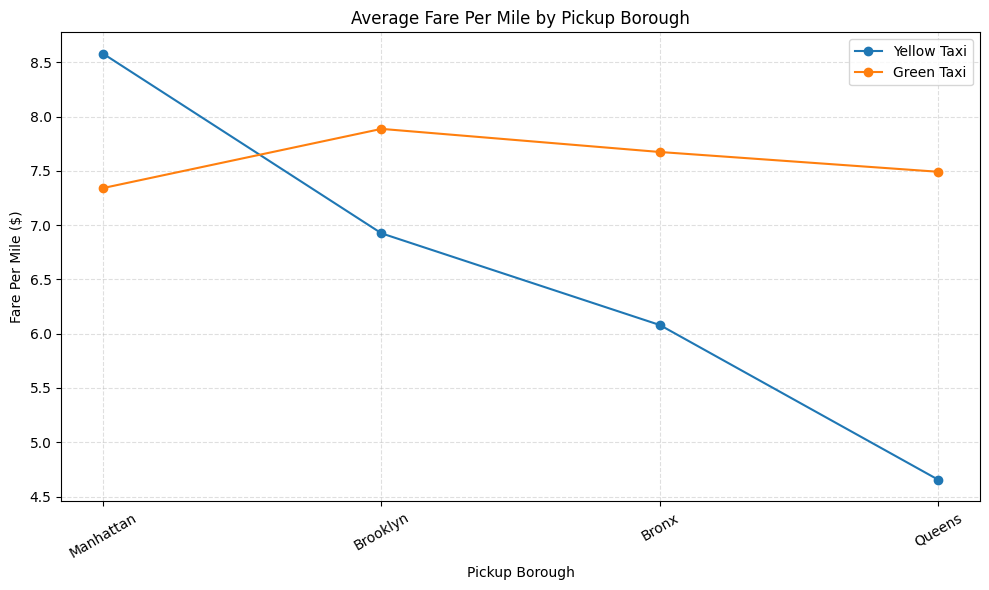

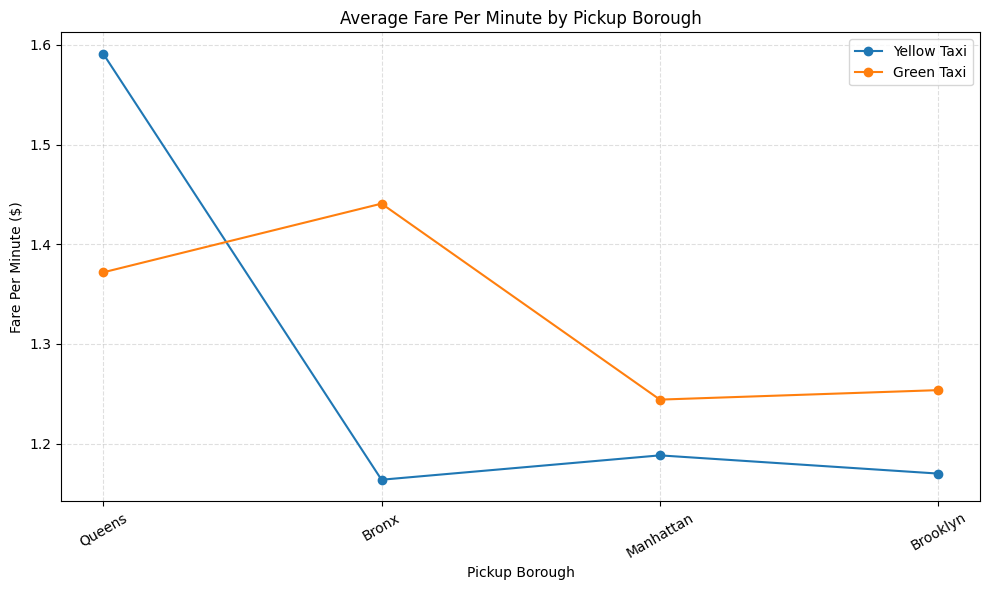

In [116]:
def plot_fare_metric_by_borough_line(metric, yellow_df, green_df):
    # Step 1: Filter valid trips for both datasets
    def clean(df):
        df_filtered = df[
            (df[metric].notnull()) &
            (df['trip_distance'] > 0.0) &
            (df['duration_inMin'] > 1) &
            (df['fare_per_mile'] < 100) 
        ].copy()
        # Drop boroughs with fewer than 50 records
        borough_counts = df_filtered['PU_Borough'].value_counts()
        valid_boroughs = borough_counts[borough_counts >= 50].index
        return df_filtered[df_filtered['PU_Borough'].isin(valid_boroughs)]

    yellow_clean = clean(yellow_df)
    green_clean = clean(green_df)

    # Step 2: Group and average
    yellow_grouped = (
        yellow_clean.groupby('PU_Borough')[metric]
        .mean()
        .reset_index()
        .rename(columns={metric: 'Yellow'})
    )

    green_grouped = (
        green_clean.groupby('PU_Borough')[metric]
        .mean()
        .reset_index()
        .rename(columns={metric: 'Green'})
    )

    # Step 3: Merge on PU_Borough
    merged = pd.merge(yellow_grouped, green_grouped, on='PU_Borough', how='inner')

    # Step 4: Sort by average of both to order the plot
    merged['avg'] = (merged['Yellow'] + merged['Green']) / 2
    merged = merged.sort_values(by='avg', ascending=False)

    # Step 5: Plot
    plt.figure(figsize=(10, 6))
    plt.plot(merged['PU_Borough'], merged['Yellow'], marker='o', label='Yellow Taxi')
    plt.plot(merged['PU_Borough'], merged['Green'], marker='o', label='Green Taxi')

    plt.title(f"Average {metric.replace('_', ' ').title()} by Pickup Borough")
    plt.ylabel(f"{metric.replace('_', ' ').title()} ($)")
    plt.xlabel("Pickup Borough")
    plt.xticks(rotation=30)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_fare_metric_by_borough_line('fare_per_mile', yellow, green)
plot_fare_metric_by_borough_line('fare_per_minute', yellow, green)
